# Business Problem

A empresa Top Bank atua na Europa tendo como principal produto uma conta bancária. Este produto pode manter o salário do cliente e efetuar pagamentos. Essa conta não tem nenhum custo nos primeiros 12 meses, porém, após esse período, o cliente precisa recontratar o banco para os próximos 12 meses e refazer esse processo todos os anos. Recentemente, a equipe de análise notou que a taxa de churn está aumentando.

## Challenge:
Como Cientista de Dados, você precisa criar um plano de ação para diminuir o número de clientes churn e mostrar o retorno financeiro da sua solução.
Além disso, você precisará fornecer um relatório relatando o desempenho de seu modelo e o impacto financeiro de sua solução.
Perguntas que o CEO e a equipe do Analytics gostariam de ver em seu relatório:

1. Qual é a atual taxa de churn do Top Bank?
2. Qual é o desempenho do modelo na classificação de clientes como churns?
3. Qual é o retorno esperado, em termos de receita, se a empresa utilizar seu modelo para evitar o churn de clientes?

## Note:
Como posso responder os 3 desafios do problema???

    R: Conhecer as variáveis (Data Description) e definir plano de desenvolvimento.

# Imports

In [1]:
#Data Processing
import pandas as pd
import numpy as np
from scipy import stats

#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#Data Preparation
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN

#Feature Selection
from sklearn.model_selection import train_test_split
from boruta import BorutaPy

#Machine Learning, Metrics and Hyperparameter Optimization
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, make_scorer, recall_score
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from skopt import dummy_minimize, gp_minimize
from skopt.plots import plot_convergence

#Parameter and Model Saving
import pickle

#Display Jupyter
from IPython.core.display import HTML
from IPython.core.display import Image
import warnings
warnings.filterwarnings('ignore')

## Helper Functions

In [2]:
binary_palette = []
sequencial_palette = ['#ffe14d', '#fac04b', '#f59f49', '#f08048', '#eb6246', '#e64545', '#e0435e', '#db4275', '#d6408b', '#d13fa0', '#cc3db4', '#c73cc7']
categorical_palette = ["#fbbd05", "#ff7a5c", "#ff4d4d", "#ff0000", "#c90000"]

def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [16, 4]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = 50
    pd.options.display.max_rows= False
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    sns.set_palette(categorical_palette)
    
    
def numeric_descriptive_statistical(numeric_attributes):
    mean = pd.DataFrame(numeric_attributes.apply(np.mean)).T
    median = pd.DataFrame(numeric_attributes.apply(np.median)).T
    standard_deviation = pd.DataFrame(numeric_attributes.apply(np.std)).T
    minimum = pd.DataFrame(numeric_attributes.apply(np.min)).T
    maximum = pd.DataFrame(numeric_attributes.apply(np.max)).T
    distance_between_minimum_and_maximum = pd.DataFrame(numeric_attributes.apply(lambda x: x.max() - x.min())).T
    unique = pd.DataFrame(numeric_attributes.apply(lambda x: len(x.unique()))).T
    skewness = pd.DataFrame(numeric_attributes.apply(lambda x: x.skew())).T
    kurtosis = pd.DataFrame(numeric_attributes.apply(lambda x: x.kurtosis())).T
    

    #concatenate
    vizualizer_descriptive_statistical = pd.concat([minimum, maximum, distance_between_minimum_and_maximum, unique, mean, median, standard_deviation, skewness, kurtosis]).T.reset_index()
    vizualizer_descriptive_statistical.columns = ['Variáveis', 'Mínimo', 'Máximo', 'Range', 'Valores Únicos', 'Média', 'Mediana', 'Desv. Padrão', 'Assimetria', 'Curtose']

    return vizualizer_descriptive_statistical


def n_bins(numeric_column):
    n = numeric_column.shape[0]
    k = round(1 + (3.3 * np.log10(n)))    
        
    return k


def plot_univariate_numeric_distributions(dataframe, list_numerical_variables):
    
    for variable in list_numerical_variables:
        
        numeric_column = dataframe[variable]
        
        bins = n_bins(numeric_column)
        
        # Get statistics
        min_val = numeric_column.min()
        max_val = numeric_column.max()
        mean_val = numeric_column.mean()
        med_val = numeric_column.median()
        mod_val = numeric_column.mode()[0]
        first_quartile_val= np.percentile(numeric_column, 25)
        third_quartile_val = np.percentile(numeric_column, 75)

        #print('Mínimo:{:.2f}\nMédia:{:.2f}\nMediana:{:.2f}\nModa:{:.2f}\nMáximo:{:.2f}\nPrimeiro Quartil:{:.2f}\nTerceiro Quartil:{:.2f}'.format(min_val, mean_val,
        #                                                                                                                                         med_val, mod_val, max_val,
        #                                                                                                                                         first_quartile_val,
        #                                                                                                                                         third_quartile_val))
        # programação assincrona p esse print

        # Create a figure for 2 subplots (2 rows, 1 column)
        fig, ax = plt.subplots(2, 1, figsize = (16,4))

        # Plot the histogram   
        ax[0].hist(numeric_column, bins= bins, color= 'salmon')
        ax[0].set_ylabel('frequência')

        # Add lines for the mean, median, and mode
        ax[0].axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2)
        ax[0].axvline(x=first_quartile_val, color = 'yellow', linestyle='dashed', linewidth = 2)
        ax[0].axvline(x=mean_val, color = 'cyan', linestyle='dashed', linewidth = 2)
        ax[0].axvline(x=med_val, color = 'red', linestyle='dashed', linewidth = 2)
        ax[0].axvline(x=mod_val, color = 'green', linestyle='dashed', linewidth = 2)
        ax[0].axvline(x=third_quartile_val, color = 'yellow', linestyle='dashed', linewidth = 2)
        ax[0].axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2)

        # Plot the boxplot   
        ax[1].boxplot(numeric_column, vert=False)
        ax[1].set_xlabel(variable)

        # Add a title to the Figure
        fig.suptitle(f'Frequência de {variable}')

        fig.show()
    
    return  None


def plot_bivariate_numeric_distribuitions(dataframe, list_variables, variable_response, tuple_figsize, order= None):
    
    shape_list = len(list_variables)
    
    for variable in list_variables:

        position_variable = list_variables.index(variable)
        
        plt.figure(figsize= tuple_figsize)
        
        plt.subplot(shape_list, 2, position_variable * 2 + 1)
        sns.boxplot(x= variable, y= variable_response, data= dataframe, orient= 'h', order=order);
        plt.title(f'{variable_response} x {variable}')

        plt.subplot(shape_list, 2, position_variable * 2 + 2)
        sns.distplot(dataframe[(dataframe[variable_response] == 0) | (dataframe[variable_response] == 'no')][variable], label= 'no');
        sns.distplot(dataframe[(dataframe[variable_response] == 1) | (dataframe[variable_response] == 'yes')][variable], label= 'yes');
        plt.legend(title= variable_response);
        plt.title(f'{variable_response} x {variable}')
    
    return None


def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1)*(r - 1)/(n - 1))
    
    kcorr = k - (k - 1)**2/(n - 1)
    rcorr = r - (r - 1)**2/(n - 1)

    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

jupyter_settings()

## Load Data

In [3]:
data_raw = pd.read_csv('../data/churn.csv')
data_raw

RowNumber  CustomerId      Surname  CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited
0             1    15634602     Hargrave          619    France  Female   42       2       0.00              1          1               1        101348.88       1
1             2    15647311         Hill          608     Spain  Female   41       1   83807.86              1          0               1        112542.58       0
2             3    15619304         Onio          502    France  Female   42       8  159660.80              3          1               0        113931.57       1
3             4    15701354         Boni          699    France  Female   39       1       0.00              2          0               0         93826.63       0
4             5    15737888     Mitchell          850     Spain  Female   43       2  125510.82              1          1               1         79084.10       0
5             6    15574012          Chu          645     Spain    Male   44       8  113755.78              2          1               0        149756.71       1
6             7    15592531     Bartlett          822    France    Male   50       7       0.00              2          1               1         10062.80       0
7             8    15656148       Obinna          376   Germany  Female   29       4  115046.74              4          1               0        119346.88       1
8             9    15792365           He          501    France    Male   44       4  142051.07              2          0               1         74940.50       0
...         ...         ...          ...          ...       ...     ...  ...     ...        ...            ...        ...             ...              ...     ...
9991       9992    15769959  Ajuluchukwu          597    France  Female   53       4   88381.21              1          1               0         69384.71       1
9992       9993    15657105  Chukwualuka          726     Spain    Male   36       2       0.00              1          1               0        195192.40       0
9993       9994    15569266       Rahman          644    France    Male   28       7  155060.41              1          1               0         29179.52       0
9994       9995    15719294         Wood          800    France  Female   29       2       0.00              2          0               0        167773.55       0
9995       9996    15606229     Obijiaku          771    France    Male   39       5       0.00              2          1               0         96270.64       0
9996       9997    15569892    Johnstone          516    France    Male   35      10   57369.61              1          1               1        101699.77       0
9997       9998    15584532          Liu          709    France  Female   36       7       0.00              1          0               1         42085.58       1
9998       9999    15682355    Sabbatini          772   Germany    Male   42       3   75075.31              2          1               0         92888.52       1
9999      10000    15628319       Walker          792    France  Female   28       4  130142.79              1          1               0         38190.78       0

[10000 rows x 14 columns]

# Data Description

In [4]:
df2 = data_raw.copy()

## Meaning of Data

- **RowNumber**: o número das colunas
- **CustomerID**: identificador único de clientes
- **Surname**: sobrenome do cliente
- **CreditScore**: pontuação de crédito do cliente para o mercado financeiro (quanto maior o score, é um bom pagador)
- **Geography**: o país do cliente
- **Gender**: o gênero do cliente
- **Age**: a idade do cliente
- **Tenure**: número de anos que o cliente está no banco
- **Balance**: o valor que o cliente tem em sua conta
- **NumOfProducts**: o número de produtos que o cliente possui (no caso, contas)
- **HasCrCard**: se o cliente tiver cartão de crédito
- **IsActiveMember**: se o cliente estiver ativo (nos últimos 12 meses)
- **EstimateSalary**: estimativa de salário anual dos clientes
- **Exited**: se o cliente for churn (*variável resposta*)

## Rename Columns

In [5]:
renamed_columns = ['numero_linha', 'id_cliente', 'sobrenome', 'score_credito', 'geografia', 'genero', 'idade', 'tempo_permanencia', 
                   'saldo', 'numero_de_contas', 'tem_cartao_credito', 'membro_ativo', 'salario_estimado', 'Churn']
df2.columns = renamed_columns

df2.head(1)

numero_linha  id_cliente sobrenome  score_credito geografia  genero  idade  tempo_permanencia  saldo  numero_de_contas  tem_cartao_credito  membro_ativo  salario_estimado  Churn
0             1    15634602  Hargrave            619    France  Female     42                  2    0.0                 1                   1             1         101348.88      1

## Data Dimensions

In [6]:
data_dimensions = df2.shape
print(f'A base de dados possui {data_dimensions[0]} clientes e {data_dimensions[1]} variáveis.')

A base de dados possui 10000 clientes e 14 variáveis.


## Data Types

In [7]:
df2.dtypes

numero_linha            int64
id_cliente              int64
sobrenome              object
score_credito           int64
geografia              object
genero                 object
idade                   int64
tempo_permanencia       int64
saldo                 float64
numero_de_contas        int64
tem_cartao_credito      int64
membro_ativo            int64
salario_estimado      float64
Churn                   int64
dtype: object

### Change Data Types

In [8]:
#Alterando o tipo de dados das colunas binárias: 'tem_cartao_credito', 'membro_ativo' e 'Churn'
categorical_columns = ['tem_cartao_credito', 'membro_ativo', 'Churn']

for columns in categorical_columns:
    df2[columns] = df2[columns].apply(lambda x: 'yes' if x == 1 else 'no')
    
df2.dtypes

numero_linha            int64
id_cliente              int64
sobrenome              object
score_credito           int64
geografia              object
genero                 object
idade                   int64
tempo_permanencia       int64
saldo                 float64
numero_de_contas        int64
tem_cartao_credito     object
membro_ativo           object
salario_estimado      float64
Churn                  object
dtype: object

## Check Duplicates

In [9]:
df2[df2.duplicated('id_cliente', False)]

Empty DataFrame
Columns: [numero_linha, id_cliente, sobrenome, score_credito, geografia, genero, idade, tempo_permanencia, saldo, numero_de_contas, tem_cartao_credito, membro_ativo, salario_estimado, Churn]
Index: []

- A base não possui dados duplicados.

## Check NaN and Null Values

In [10]:
#Dados NaN
df2.isna().sum()

numero_linha          0
id_cliente            0
sobrenome             0
score_credito         0
geografia             0
genero                0
idade                 0
tempo_permanencia     0
saldo                 0
numero_de_contas      0
tem_cartao_credito    0
membro_ativo          0
salario_estimado      0
Churn                 0
dtype: int64

In [11]:
#Dados Null
df2.isnull().sum()

numero_linha          0
id_cliente            0
sobrenome             0
score_credito         0
geografia             0
genero                0
idade                 0
tempo_permanencia     0
saldo                 0
numero_de_contas      0
tem_cartao_credito    0
membro_ativo          0
salario_estimado      0
Churn                 0
dtype: int64

- A base não possui dados faltantes.

## Check Zero Values

In [12]:
df2.dtypes

numero_linha            int64
id_cliente              int64
sobrenome              object
score_credito           int64
geografia              object
genero                 object
idade                   int64
tempo_permanencia       int64
saldo                 float64
numero_de_contas        int64
tem_cartao_credito     object
membro_ativo           object
salario_estimado      float64
Churn                  object
dtype: object

In [13]:
#Transfomando valores diferentes de 0 em "another value" em todas as variáveis numéricas
numerical_variables = df2.select_dtypes(include= ['int64', 'float64']).columns
numerical_variables_verify = df2[numerical_variables]

for column in numerical_variables_verify.columns:
    numerical_variables_verify[column] = numerical_variables_verify[column].apply(lambda x: '0' if x == 0 else 'another value')

In [14]:
numerical_variables_verify.apply(lambda x: x.unique())

numero_linha            [another value]
id_cliente              [another value]
score_credito           [another value]
idade                   [another value]
tempo_permanencia    [another value, 0]
saldo                [0, another value]
numero_de_contas        [another value]
salario_estimado        [another value]
dtype: object

- Apenas as variáveis 'tempo_permanencia' e 'saldo' possuem valores declarados como 0.

De fato, apenas as colunas 'score_credito' (dependendo da regra de negócio), 'tempo_permanencia' e 'saldo' fazem sentido terem valores iguais a 0, mas ainda cabe análise.

In [15]:
percentage_0_in_saldo = numerical_variables_verify['saldo'].value_counts()[1] / numerical_variables_verify.shape[0] * 100
percentage_0_in_tenure = numerical_variables_verify['tempo_permanencia'].value_counts()[1] / numerical_variables_verify.shape[0] * 100
print(f'A coluna \'saldo\' possui {percentage_0_in_saldo}% registros zerados')
print(f'A coluna \'tempo_permanencia\' possui {percentage_0_in_tenure:.2f}% registros zerados')

A coluna 'saldo' possui 36.17% registros zerados
A coluna 'tempo_permanencia' possui 4.13% registros zerados


### *saldo*

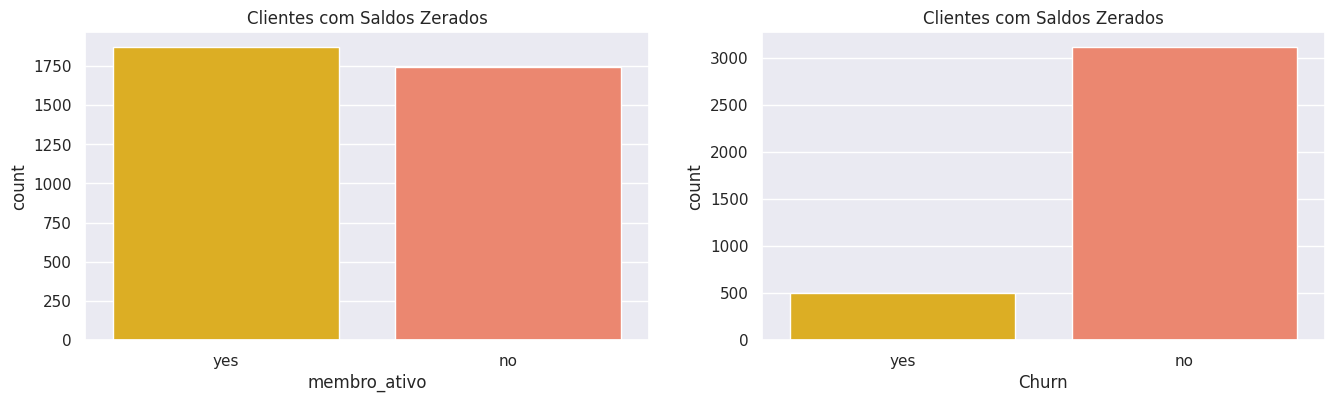

In [16]:
df_zero_balance = df2[['saldo', 'tempo_permanencia', 'membro_ativo', 'Churn']].loc[df2['saldo'] == 0]

plt.subplot(1, 2, 1)
sns.countplot(x= df_zero_balance['membro_ativo']);
plt.title("Clientes com Saldos Zerados");

plt.subplot(1, 2, 2)
sns.countplot(x= df_zero_balance['Churn']);
plt.title("Clientes com Saldos Zerados");

In [17]:
df_aux = df_zero_balance[['saldo', 'tempo_permanencia']].groupby('tempo_permanencia').count()
df_aux2 = df_zero_balance[['saldo', 'tempo_permanencia']].groupby('tempo_permanencia').count() / df_zero_balance.shape[0]

pd.concat([df_aux, df_aux2], axis= 1, keys= ['saldo_abs', 'saldo_perc'])

saldo_abs saldo_perc
                      saldo      saldo
tempo_permanencia                     
0                       137   0.037877
1                       349   0.096489
2                       382   0.105612
3                       352   0.097318
4                       369   0.102018
5                       374   0.103401
6                       367   0.101465
7                       386   0.106718
8                       363   0.100359
9                       360   0.099530
10                      178   0.049212

In [18]:
mean = round(df_zero_balance['tempo_permanencia'].mean(), 2)
print(f'A média do tempo de permanência para contas com saldo zerado é de {mean} anos')

A média do tempo de permanência para contas com saldo zerado é de 5.07 anos


### 'tempo_de_permanencia' zerados:

**Suposição principal**: Como o conjunto de dados não possui dados temporais e registros zerados representam um pequena parte dos dados, vamos assumir que valores zerados nessa variável representam clientes que ainda não possuem 1 ano de empresa.

### 'saldo' zerados:

    1. praticamente se divide igualmentente em membros ativos e não ativos;
    2. de 3617 saldos zerados, apenas 500 são de clientes que irão dar Churn
    3. a média do tempo de permanência para contas com saldo zerado é de 5 anos
    4. a menor frequência de saldos zerados, são para clientes que adquiriram o em menos de 1 ano.

Logo é possível determinar:

    - saldos zerados não siginificam que são de contas pré criadas (obs. 4)
    - saldos zerados não possuem relação clara com membros ativos e inativos.
    
**Suposição principal**: Ignorar os questionamentos levantados na V1. Saldos zerados, representam de fato, contas sem capital disponível.

## Note:
Observações importantes:

Como não existe variável temporal, identificando o momento da extração dos dados, nasce alguns questionamentos:

	1. Qual ponto no tempo a extração de dados foi feita? Qual é a relevância desse período?

	2. Se os dados foi extraído como o resumo de 1 ano, o valor de saldo representa o valor presente na conta(s) no momento da extração, o somátorio de saldo presente na(s) conta(s) durante 1 ano ou o valor máximo do saldo presente nesse período.

	3. A variável Churn significa que o cliente de fato saiu da empresa ou possui a vontade de sair. Pois se o cliente de fato saiu da empresa, existe clientes que saíram do banco, mas que ainda possuiam saldo em sua(s) conta(s).

	4. O que seria de fato 'membro_ativo', clientes que fizeram transações em todos os meses do ano, ou pelo menos uma vez durante o período de extração?

Pra esse projeto, irei modelar sem a resposta dessas questões, embora, ter o contexto melhora o entendimento do problema e possivelmente melhores resultados na modelagem dos dados.


Solução do problema de negócio:
    
1. Qual é a atual taxa de Churn do Top Bank?

        S: Análise Univariada da variável resposta 'Churn' > plotar gráfico de barras de churns e não-churns e printar porcentagem da relação das classes (concluído)

        
2. Qual é o desempenho do modelo na classificação de clientes como churns?

        S: Criar modelo de classificação com as variáveis selecionadas por relevância (Análise Bivariada) e pelo Boruta. (em progresso)
        
3. Qual é o retorno esperado, em termos de receita, se a empresa utilizar seu modelo para evitar o churn de clientes?

        S: Com o modelo criado, é possível estimar o retorno esperado, criando casos de deduções sobre os salários de cada cliente. (em progresso)

# Creation of New Variables

In [19]:
df3 = df2.copy()

In [20]:
#Escala FICO
df3['escala_fico'] = df3['score_credito'].apply(lambda x: 'too bad' if x < 580 else 'bad' if x < 670 else 'good' if x < 740 else 'very good' if x < 800 else 'excellent')


# Exploratory Data Analysis

In [21]:
df4 = df3.copy()

## Defining Variables for Analysis

In [22]:
#Response Variable
response_variable = df4['Churn']

#Numeric Variables
numeric_attributes = df4.select_dtypes(include= ['int64', 'float64'])

#Categorical Variables
categorical_attributes = df4.select_dtypes(exclude= ['int64', 'float64'])

## Univariate Analysis

### Response Variable

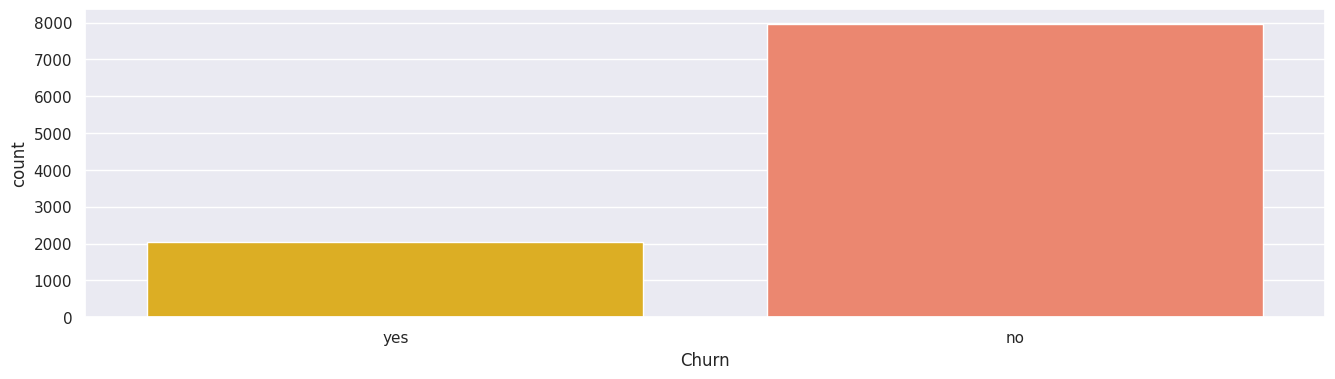

In [23]:
sns.countplot(x= response_variable);

In [24]:
percentage_no_churn = df4[['id_cliente', 'Churn']].loc[df4['Churn'] == 'no'].shape[0] / df4.shape[0] * 100
percentage_yes_churn = df4[['id_cliente', 'Churn']].loc[df4['Churn'] == 'yes'].shape[0] / df4.shape[0] * 100
print(f'Clientes que irão dar Churn correspondem a {percentage_yes_churn:.2f}%  da base de dados e clientes que não irão dar Churn correspondem a {percentage_no_churn:.2f}% da base de dados.')

Clientes que irão dar Churn correspondem a 20.37%  da base de dados e clientes que não irão dar Churn correspondem a 79.63% da base de dados.


- É evidente que a variável resposta possui classes desbalanceadas

### Numeric Variables

In [25]:
numeric_attributes.drop(columns= ['numero_linha', 'id_cliente'], inplace= True)
numeric_descriptive_statistical(numeric_attributes)

Variáveis  Mínimo     Máximo      Range  Valores Únicos          Média     Mediana  Desv. Padrão  Assimetria   Curtose
0      score_credito  350.00     850.00     500.00           460.0     650.528800     652.000     96.648466   -0.071607 -0.425726
1              idade   18.00      92.00      74.00            70.0      38.921800      37.000     10.487282    1.011320  1.395347
2  tempo_permanencia    0.00      10.00      10.00            11.0       5.012800       5.000      2.892030    0.010991 -1.165225
3              saldo    0.00  250898.09  250898.09          6382.0   76485.889288   97198.540  62394.285254   -0.141109 -1.489412
4   numero_de_contas    1.00       4.00       3.00             4.0       1.530200       1.000      0.581625    0.745568  0.582981
5   salario_estimado   11.58  199992.48  199980.90          9999.0  100090.239881  100193.915  57507.617221    0.002085 -1.181518

- **Muitos valores distintos**: *score_credito, idade, saldo, salário estimado.
- **Poucos valores distintos**: *tempo_permanencia, numero_de_contas*;

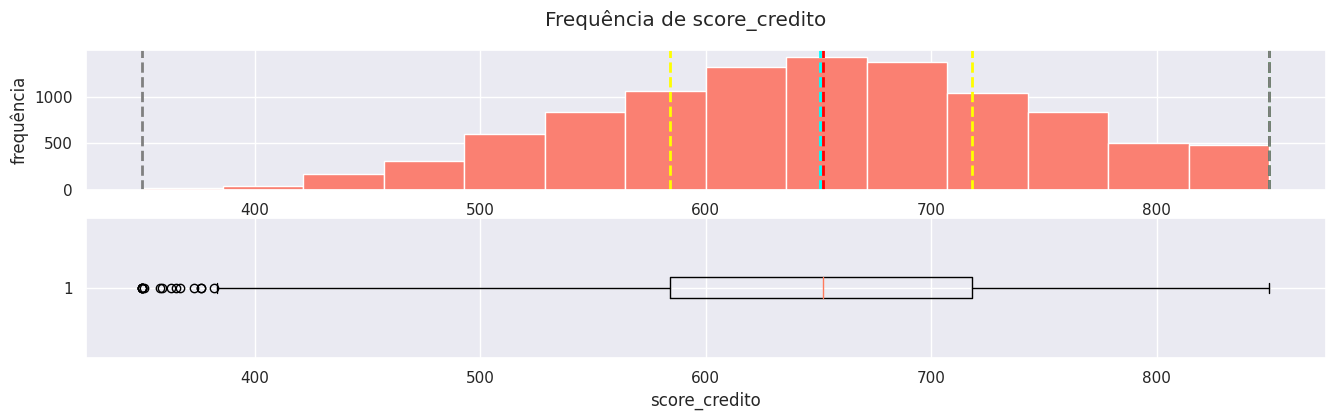

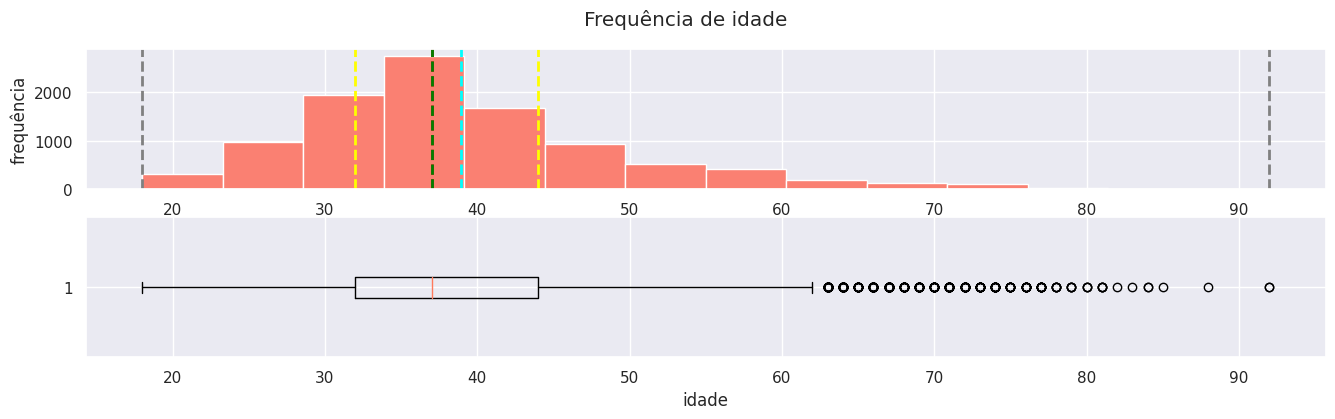

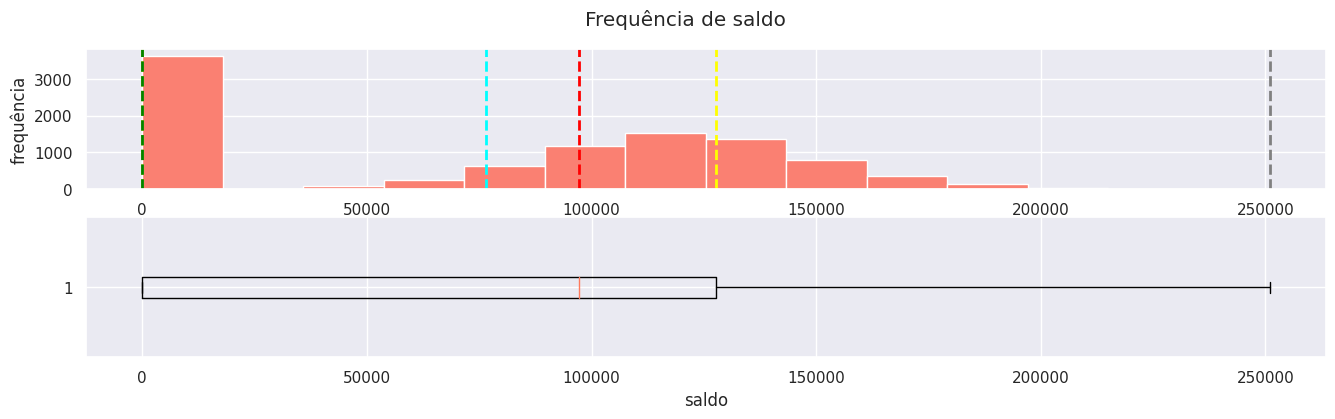

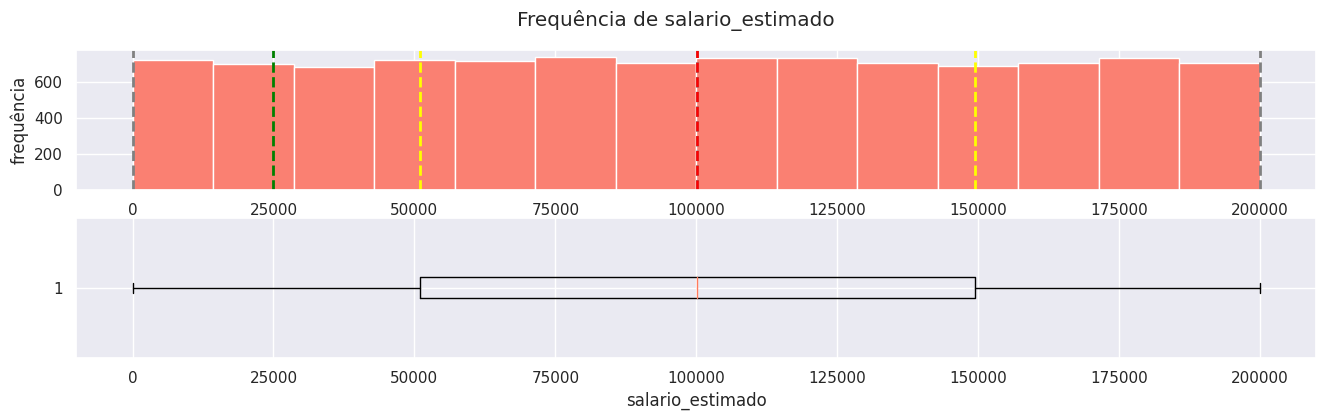

In [26]:
list_numerical_variables = ['score_credito', 'idade', 'saldo', 'salario_estimado']
plot_univariate_numeric_distributions(numeric_attributes, list_numerical_variables= list_numerical_variables)

#### Notes:

In [27]:
# Score de Crédito

# Note: 
	# segundo os intervalos de scores de crédito da FICO:
    	# 300 - 580: muito baixo;
        # 580 - 670: baixo;
        # 670 - 740: bom;
        # 740 - 800: muito bom;
        # 800 - 850: excelente;
        
    # é possível observar outliers para scores que se aproximam do valor mínimo (350) através do boxplot, mas com a curtose em -0.42 indicando que a distribuição tem uma pequena chance de ocorrência de
#outliers, logo o banco possui pouquíssimos clientes se aproximando do mínimo score_permitido pelo banco (aproximadamente uns 10).
    # a moda é igual ao valor máximo, o que pode evidênciar que o banco possui um grupo seleto de cliente que são bons pagadores. (vale criação de caso para esse grupo)
    # com assimetria em -0.07 evidencia que a distribuição de score está um pouco assimétrica à esquerda, logo existe uma maior concentração de valores na zona de valores mais elevados da amostra.
    # hipótese: 'clientes que são bons pagadores, possuem o salário mais alto?' ou 'clentes que possuem salários altos, são bons pagadores?'

In [28]:
# Idade

# Note
    # com a curtose positiva em 1.39 indica uma grande chance de existir outliers, evidenciado pelo boxplot que existe outlier para idade maiores de 62 anos. 
    # a mediana = moda > média, junto com a assimetria  em 1.011, evidencia que a distribuição de idade é assimétrica à direita, possuindo maior concentração de dados na zona de valores mais reduzidos da amostra. 

In [29]:
# Saldo

# Note
	# com a curtose negativa, evidencia que existe uma pequena possibilidade de haver outliers. já o boxplot afirma que não existe outliers nesse conjunto.
    # com assimetria em -0.14, evidencia que a distribuição de score está um pouco assimétrica à esquerda, logo existe uma maior concentração de valores na zona de valores mais elevados da amostra,
#por mais que exista uma alta concentração de dados com valores 0, mostrado no gráfico e abordado na checagem de valores zerados.
	# mais de 36% dos clientes possuem contas zeradas.

In [30]:
# Salário Estimado

# Note:
	# a distribuição dos salários é praticamente simétrica (evidenciado pelo valor da assimetria e pelos gráficos acima).
    # a distribuição dos salários também possui pouca chance de possuir valores dispersos, outliers (evidenciado pelo valor negativo da curtose e pelos gráficos acima).

#### *tempo_permanencia*

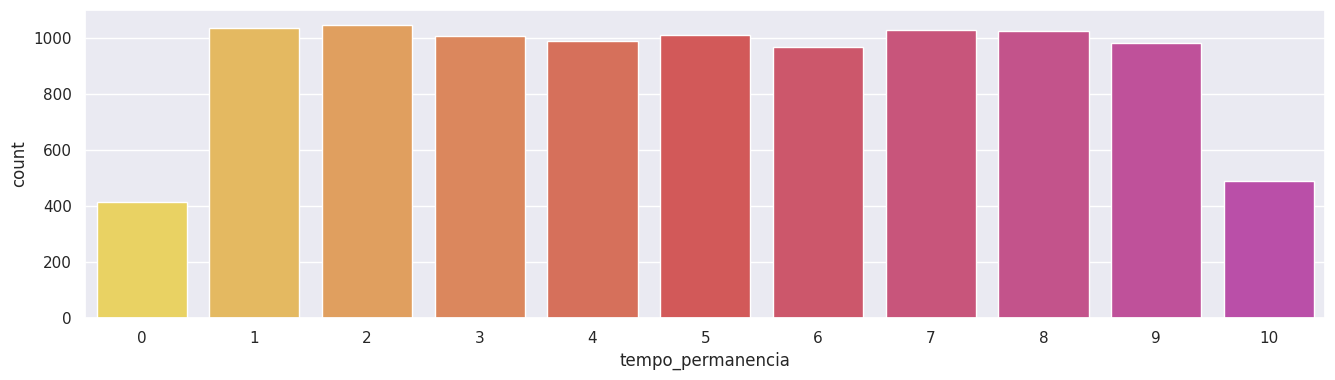

In [31]:
sns.countplot(x= df4['tempo_permanencia'], palette= sequencial_palette);

In [32]:
pd.DataFrame({'absoluto': df4['tempo_permanencia'].value_counts(), 'percentual (%)': df4['tempo_permanencia'].value_counts(normalize= True) * 100})

absoluto  percentual (%)
2       1048           10.48
1       1035           10.35
7       1028           10.28
8       1025           10.25
5       1012           10.12
3       1009           10.09
4        989            9.89
9        984            9.84
6        967            9.67
10       490            4.90
0        413            4.13

#### *numero_de_contas*

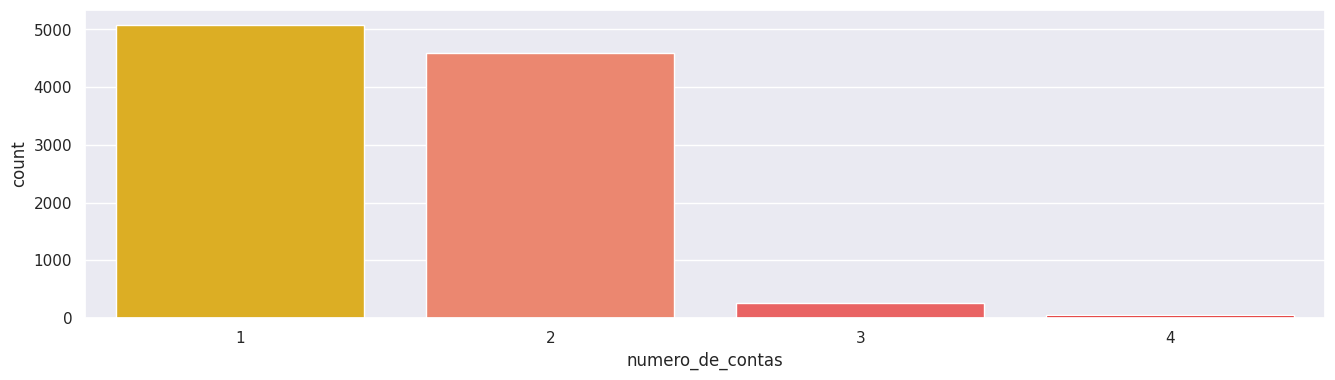

In [33]:
sns.countplot(x= df4['numero_de_contas']);

In [34]:
pd.DataFrame({'absoluto': df4['numero_de_contas'].value_counts(), 'percentual (%)': df4['numero_de_contas'].value_counts(normalize= True) * 100})

absoluto  percentual (%)
1      5084           50.84
2      4590           45.90
3       266            2.66
4        60            0.60

### Categorical Variables

#### *geografia*

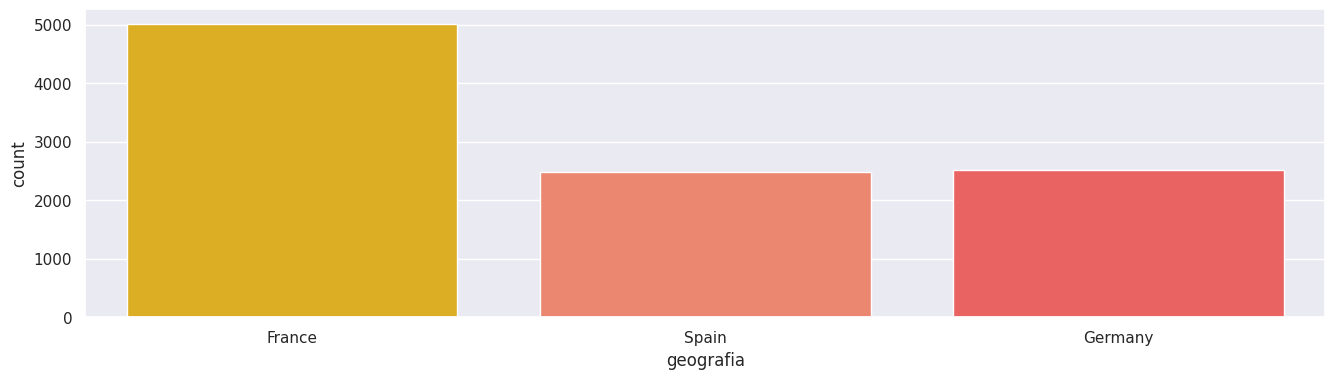

In [35]:
sns.countplot(x= df4['geografia'], palette= categorical_palette);

In [36]:
pd.DataFrame({'absoluto': df4['geografia'].value_counts(), 'percentual (%)': df4['geografia'].value_counts(normalize= True) * 100})

absoluto  percentual (%)
France       5014           50.14
Germany      2509           25.09
Spain        2477           24.77

#### *genero*

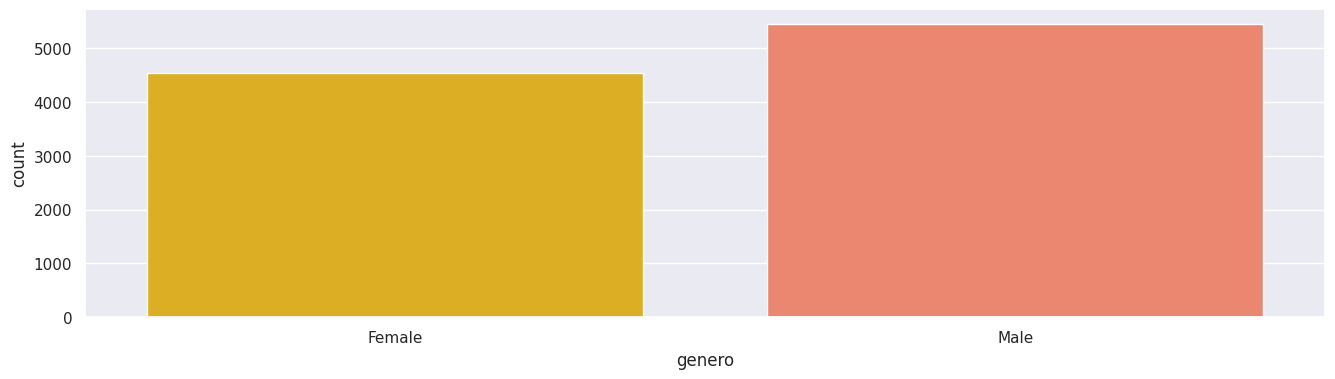

In [37]:
sns.countplot(x= df4['genero'], palette= categorical_palette);

In [38]:
pd.DataFrame({'absoluto': df4['genero'].value_counts(), 'percentual (%)': df4['genero'].value_counts(normalize= True) * 100})

absoluto  percentual (%)
Male        5457           54.57
Female      4543           45.43

#### *tem_cartao_credito*

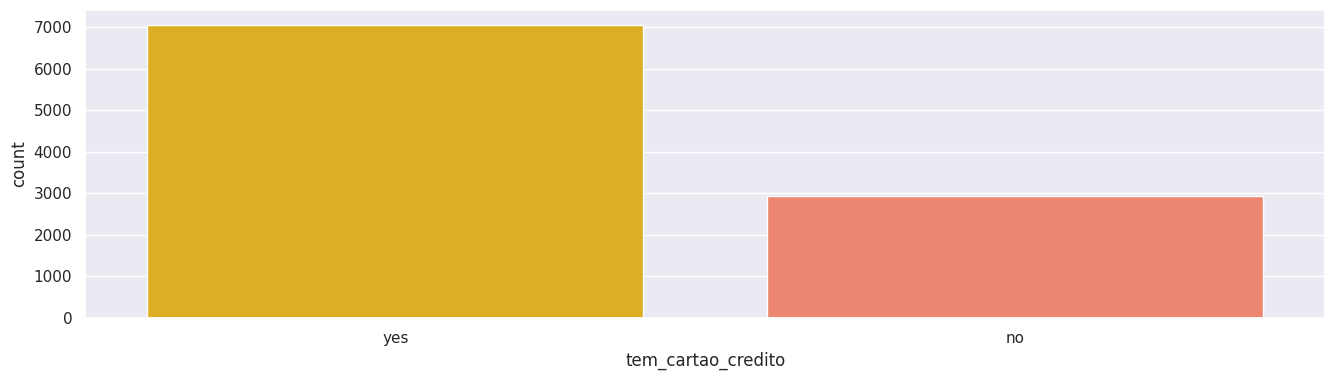

In [39]:
sns.countplot(x= df4['tem_cartao_credito'], palette= categorical_palette);

In [40]:
pd.DataFrame({'absoluto': df4['tem_cartao_credito'].value_counts(), 'percentual (%)': df4['tem_cartao_credito'].value_counts(normalize= True) * 100})

absoluto  percentual (%)
yes      7055           70.55
no       2945           29.45

#### *membro_ativo*

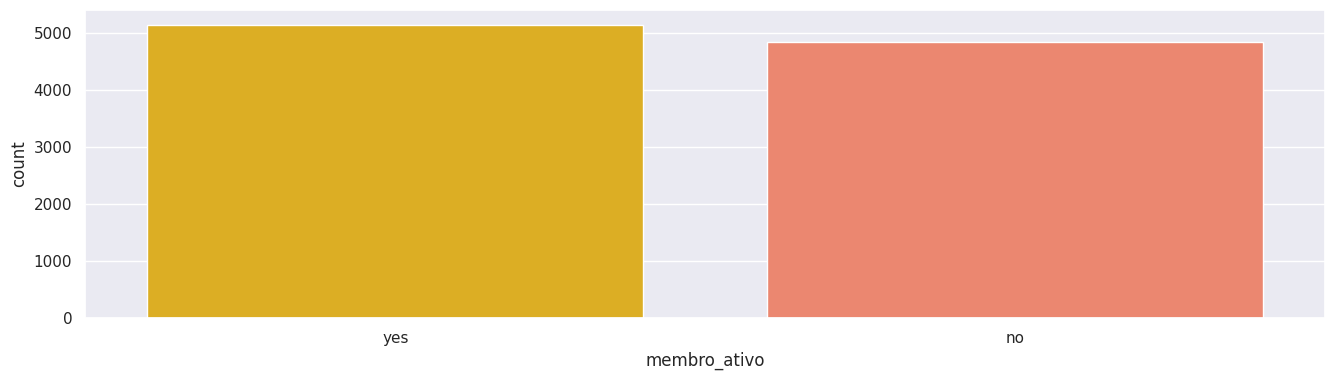

In [41]:
sns.countplot(x= df4['membro_ativo'], palette= categorical_palette);

In [42]:
pd.DataFrame({'absoluto': df4['membro_ativo'].value_counts(), 'percentual (%)': df4['membro_ativo'].value_counts(normalize= True) * 100})

absoluto  percentual (%)
yes      5151           51.51
no       4849           48.49

#### *escala_fico*

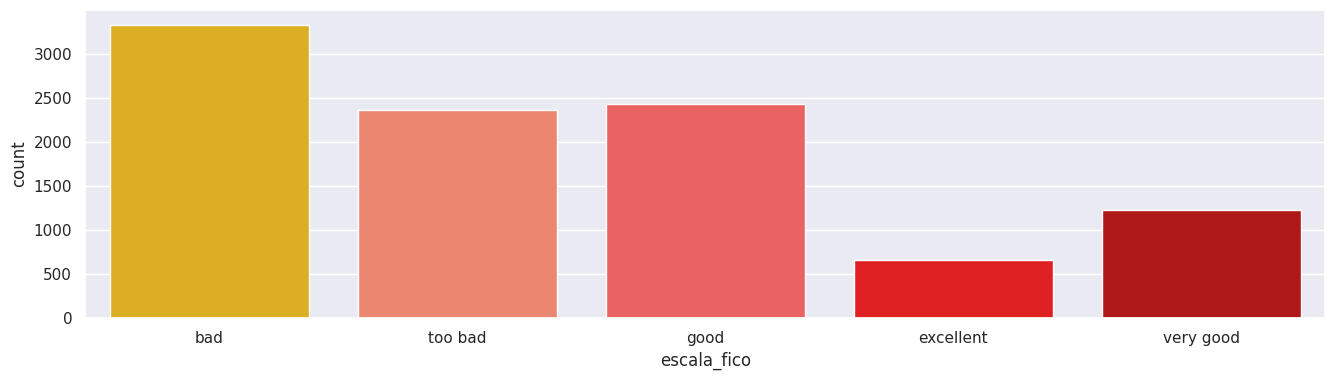

In [43]:
sns.countplot(x= df4['escala_fico'], palette= categorical_palette);

In [44]:
pd.DataFrame({'absoluto': df4['escala_fico'].value_counts(), 'percentual (%)': df4['escala_fico'].value_counts(normalize= True) * 100})

absoluto  percentual (%)
bad            3331           33.31
good           2428           24.28
too bad        2362           23.62
very good      1224           12.24
excellent       655            6.55

## Bivariate and Multivariate Analysis

### Response Variable x Numeric Variables (lots and few distinct values)

#### *score_credito, idade, saldo, salario_estimado*

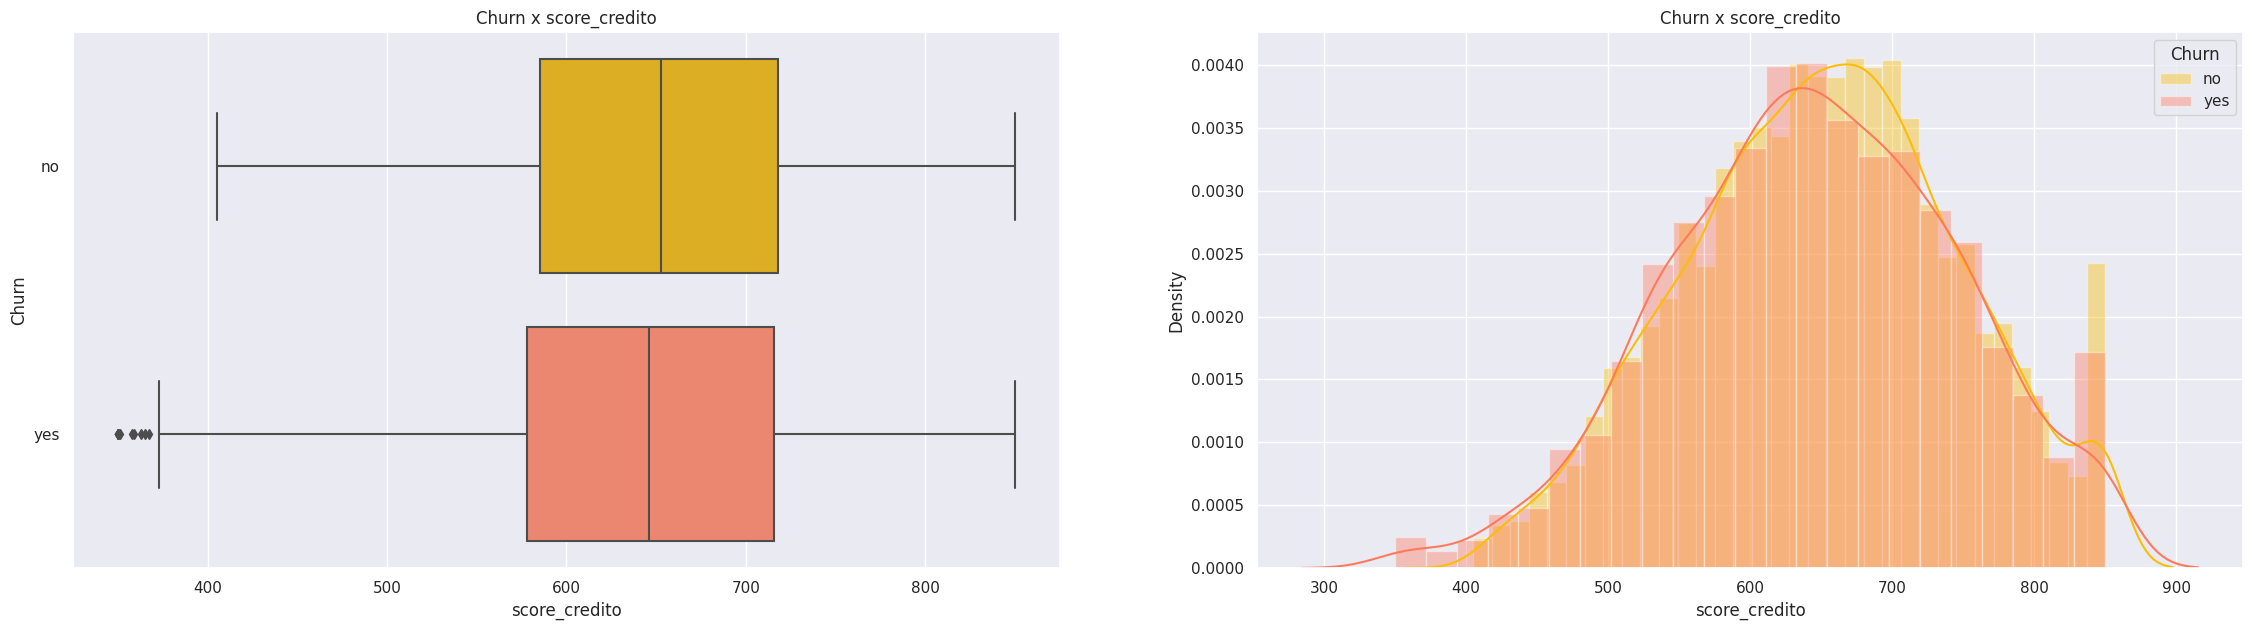

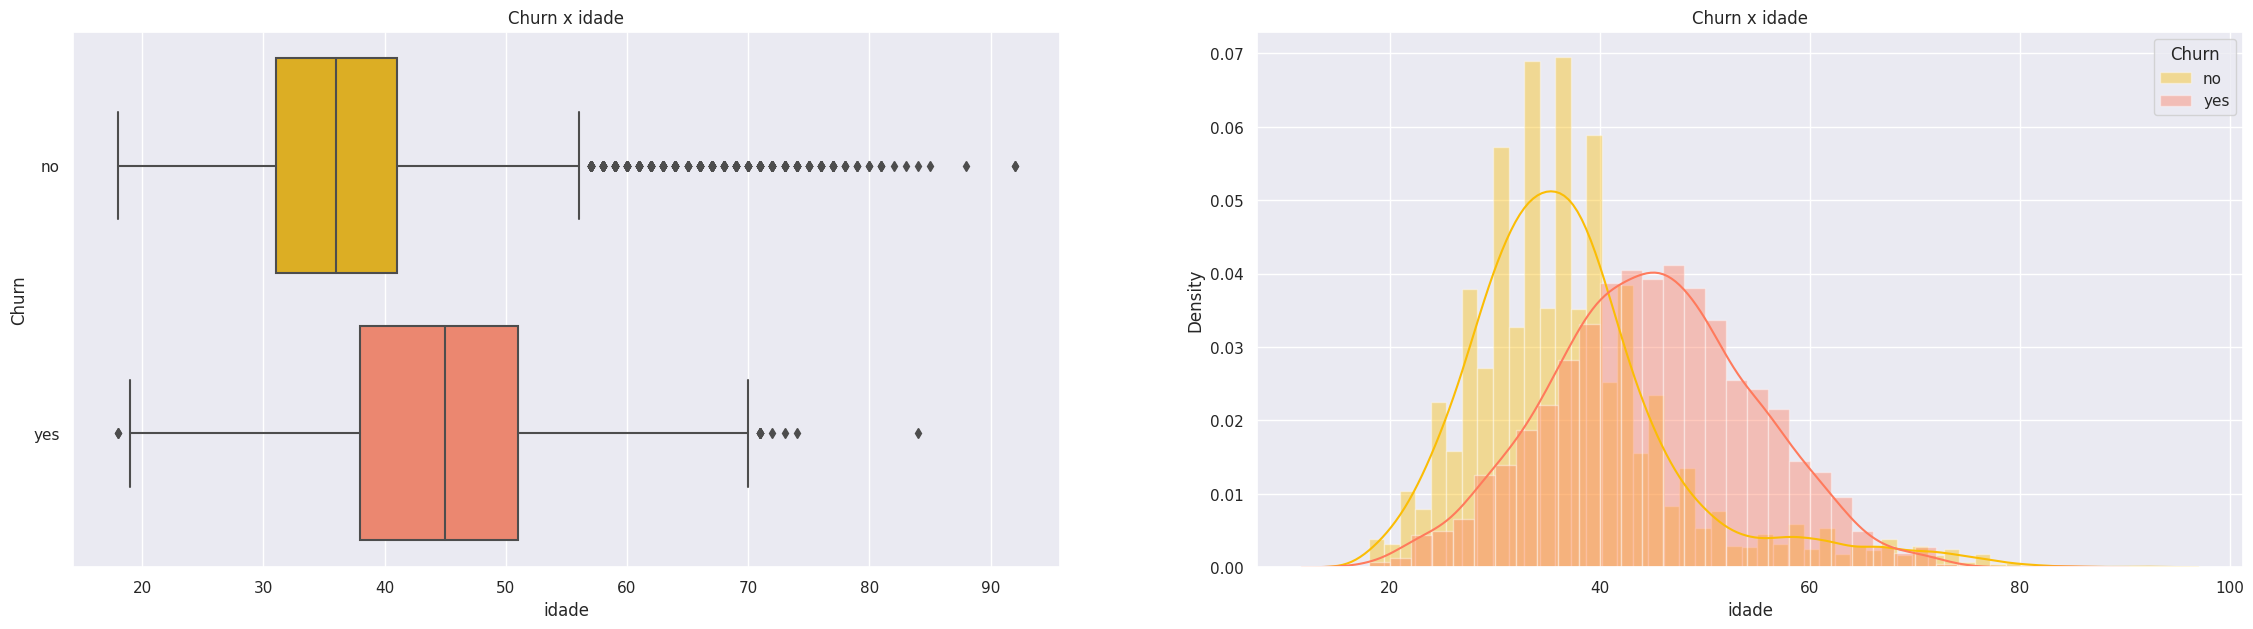

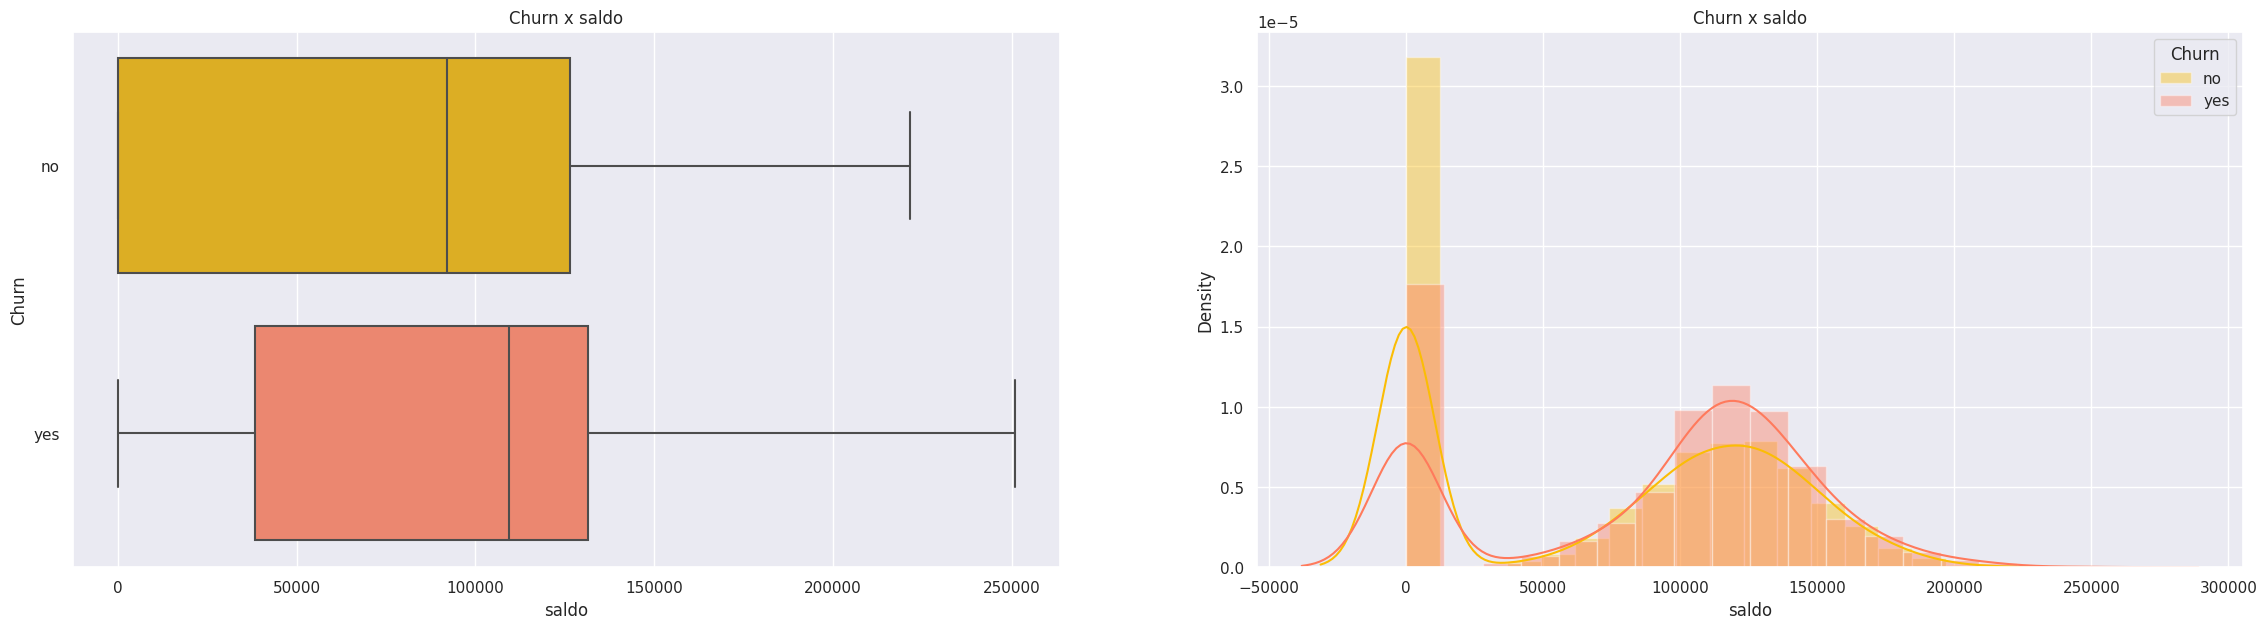

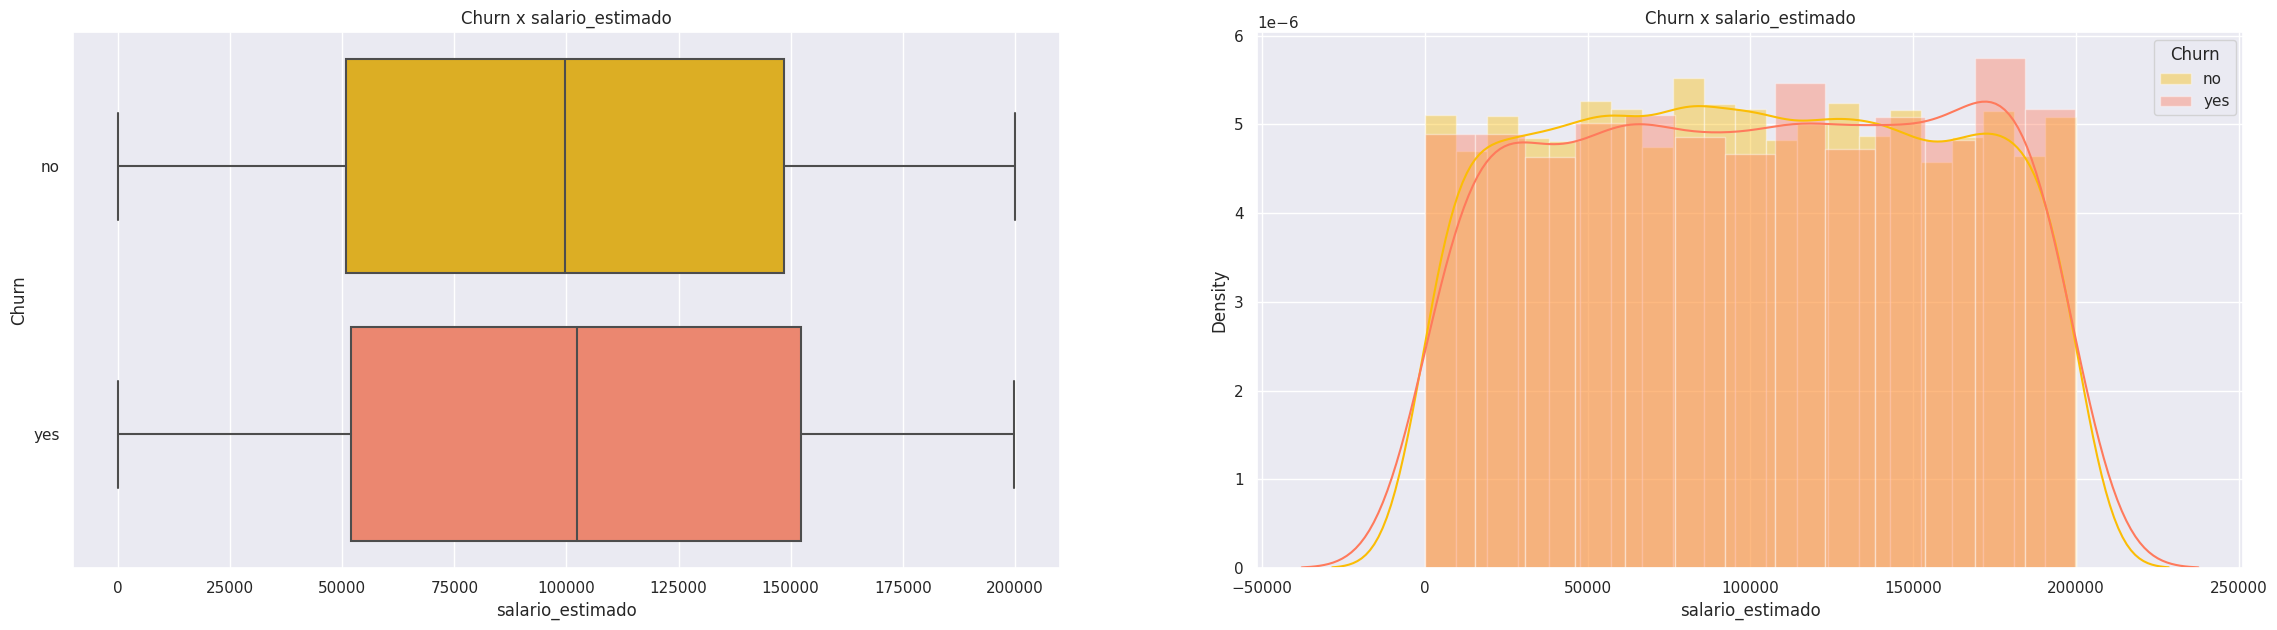

In [45]:
list_variables = ['score_credito', 'idade', 'saldo', 'salario_estimado']
order = ['no', 'yes']
tuple_figsize = (28, 32)
                         
plot_bivariate_numeric_distribuitions(df4, list_variables, 'Churn', tuple_figsize, order= order)

#### *tempo_permanencia*

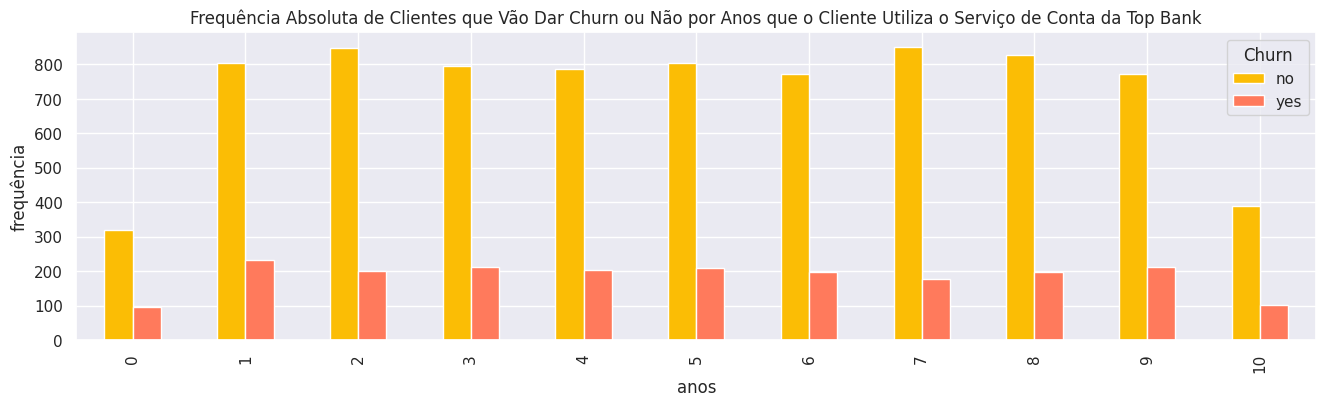

In [46]:
df_aux = df4[['id_cliente','Churn', 'tempo_permanencia']].groupby(['Churn','tempo_permanencia']).count()
df_aux.reset_index().pivot(index='tempo_permanencia', columns='Churn', values='id_cliente').plot(kind='bar')

# Adiciona títulos e etiquetas
plt.title('Frequência Absoluta de Clientes que Vão Dar Churn ou Não por Anos que o Cliente Utiliza o Serviço de Conta da Top Bank')
plt.xlabel('anos')
plt.ylabel('frequência')
plt.legend(title= 'Churn');

# Exibe o gráfico
plt.show()

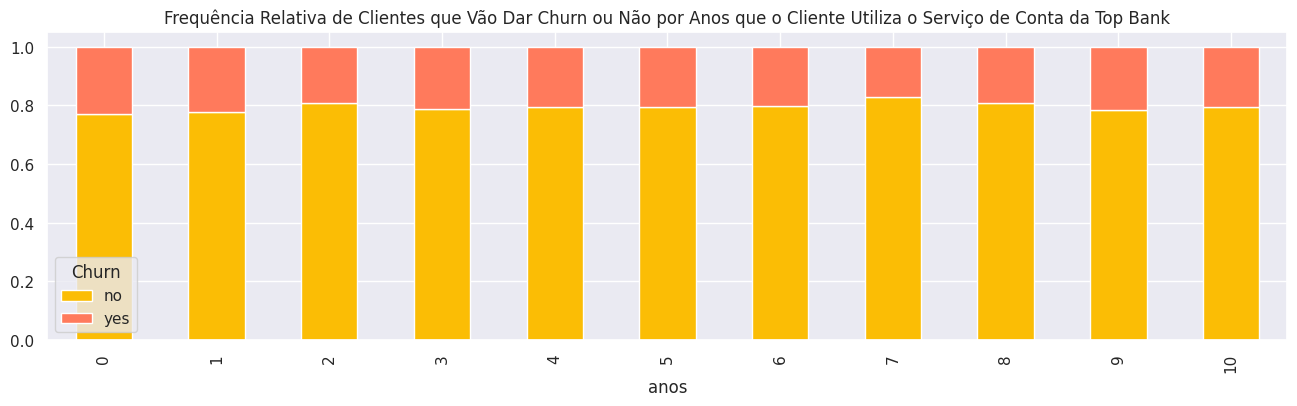

In [47]:
table = pd.crosstab(df4['tempo_permanencia'], df4['Churn'], normalize='index')
table = table.div(table.sum(1), axis=0)
table.plot(kind='bar', stacked=True)

# Adiciona títulos e etiquetas
plt.title('Frequência Relativa de Clientes que Vão Dar Churn ou Não por Anos que o Cliente Utiliza o Serviço de Conta da Top Bank')
plt.xlabel('anos')

# Exibe o gráfico
plt.show()

#### numero_de_contas

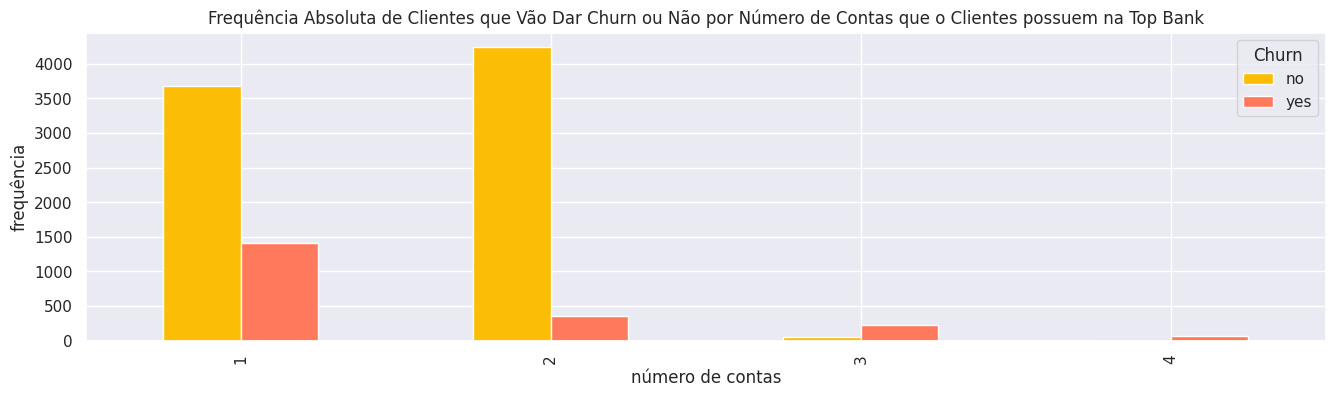

In [48]:
df_aux = df4[['id_cliente','Churn', 'numero_de_contas']].groupby(['Churn','numero_de_contas']).count()
df_aux.reset_index().pivot(index='numero_de_contas', columns='Churn', values='id_cliente').plot(kind='bar')

# Adiciona títulos e etiquetas
plt.title('Frequência Absoluta de Clientes que Vão Dar Churn ou Não por Número de Contas que o Clientes possuem na Top Bank')
plt.xlabel('número de contas')
plt.ylabel('frequência')
plt.legend(title= 'Churn');

# Exibe o gráfico
plt.show()

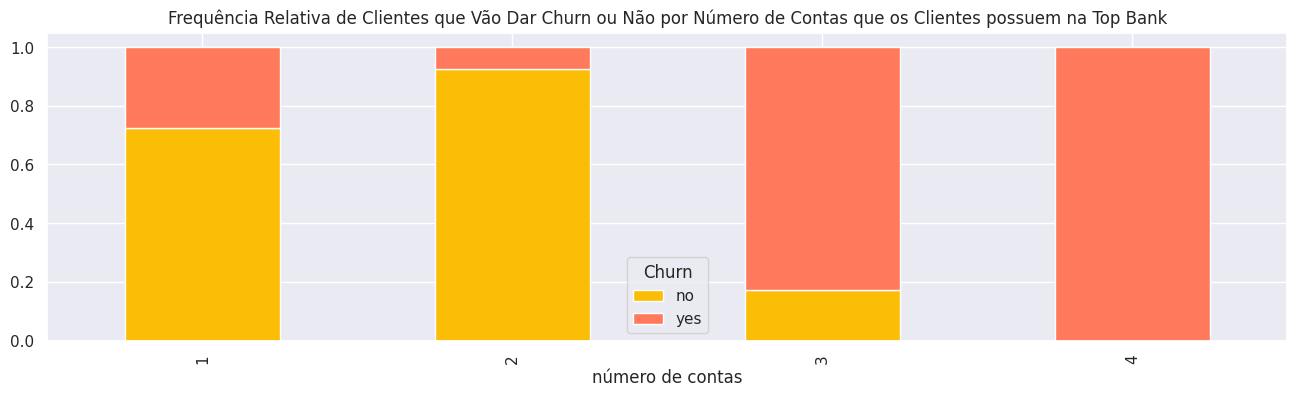

In [49]:
table = pd.crosstab(df4['numero_de_contas'], df4['Churn'], normalize='index')
table = table.div(table.sum(1), axis=0)
table.plot(kind='bar', stacked=True)

# Adiciona títulos e etiquetas
plt.title('Frequência Relativa de Clientes que Vão Dar Churn ou Não por Número de Contas que os Clientes possuem na Top Bank')
plt.xlabel('número de contas')

# Exibe o gráfico
plt.show()

### Response Variable x Categorical Variables

#### *geografia*

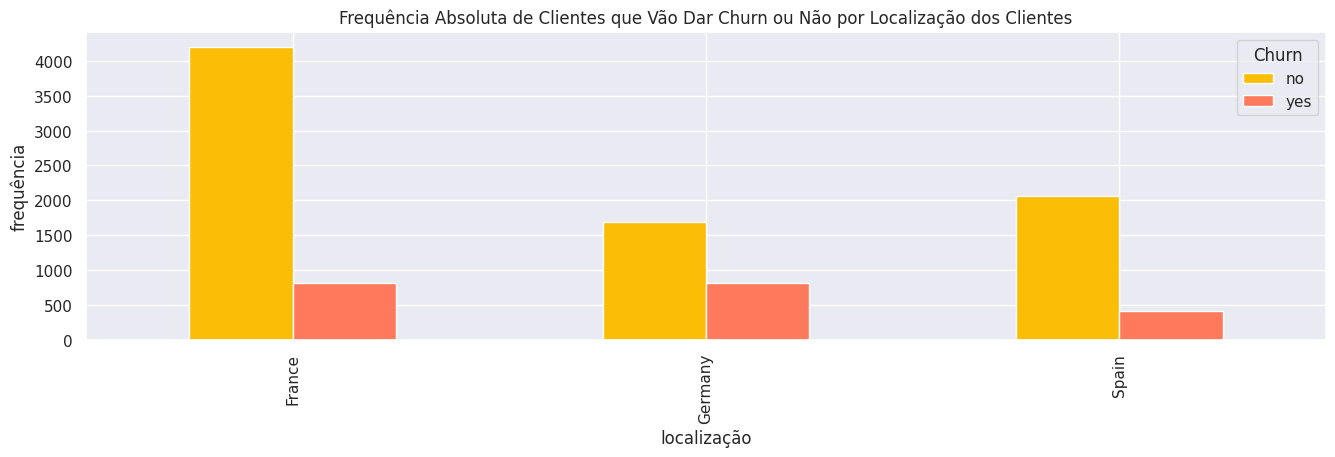

In [50]:
df_aux = df4[['id_cliente','Churn', 'geografia']].groupby(['Churn','geografia']).count()
df_aux.reset_index().pivot(index='geografia', columns='Churn', values='id_cliente').plot(kind='bar')

# Adiciona títulos e etiquetas
plt.title('Frequência Absoluta de Clientes que Vão Dar Churn ou Não por Localização dos Clientes')
plt.xlabel('localização')
plt.ylabel('frequência')
plt.legend(title= 'Churn');

# Exibe o gráfico
plt.show()

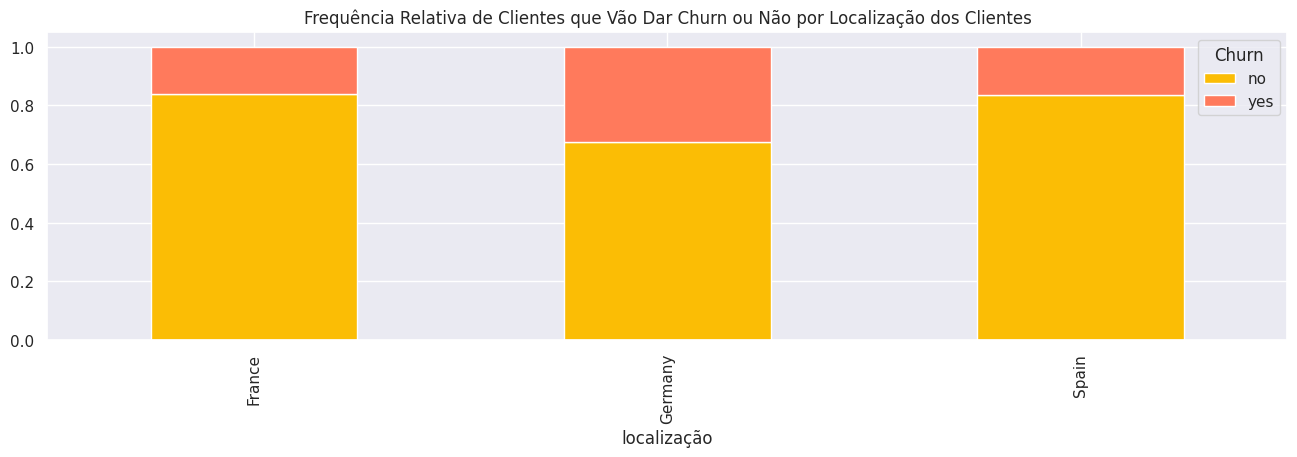

In [51]:
table = pd.crosstab(df4['geografia'], df4['Churn'], normalize='index')
table = table.div(table.sum(1), axis=0)
table.plot(kind='bar', stacked=True)

# Adiciona títulos e etiquetas
plt.title('Frequência Relativa de Clientes que Vão Dar Churn ou Não por Localização dos Clientes')
plt.xlabel('localização')

# Exibe o gráfico
plt.show()

#### *genero*

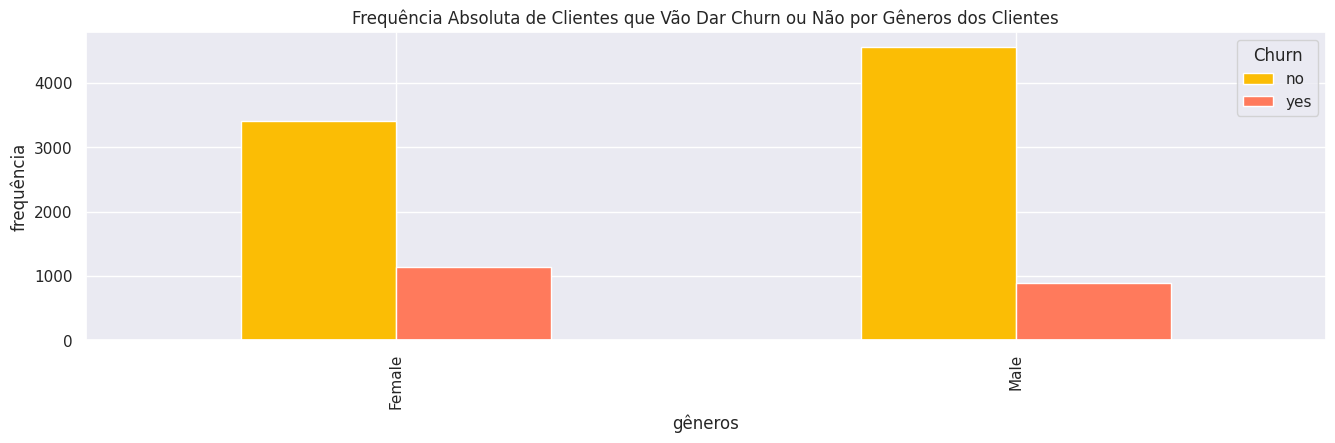

In [52]:
df_aux = df4[['id_cliente','Churn', 'genero']].groupby(['Churn','genero']).count()
df_aux.reset_index().pivot(index='genero', columns='Churn', values='id_cliente').plot(kind='bar')

# Adiciona títulos e etiquetas
plt.title('Frequência Absoluta de Clientes que Vão Dar Churn ou Não por Gêneros dos Clientes')
plt.xlabel('gêneros')
plt.ylabel('frequência')
plt.legend(title= 'Churn');

# Exibe o gráfico
plt.show()

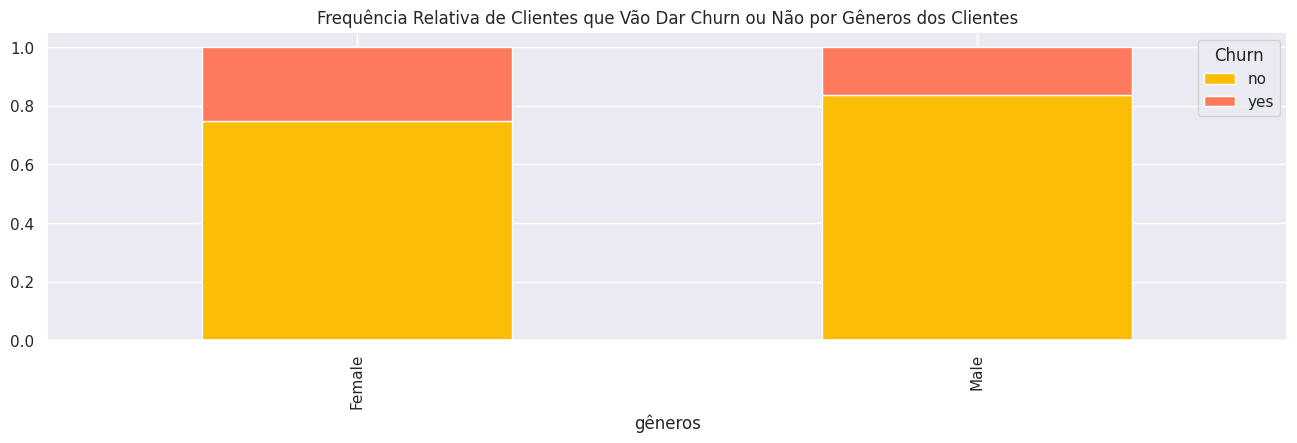

In [53]:
table = pd.crosstab(df4['genero'], df4['Churn'], normalize='index')
table = table.div(table.sum(1), axis=0)
table.plot(kind='bar', stacked=True)

# Adiciona títulos e etiquetas
plt.title('Frequência Relativa de Clientes que Vão Dar Churn ou Não por Gêneros dos Clientes')
plt.xlabel('gêneros')

# Exibe o gráfico
plt.show()

#### *tem_cartao_credito*

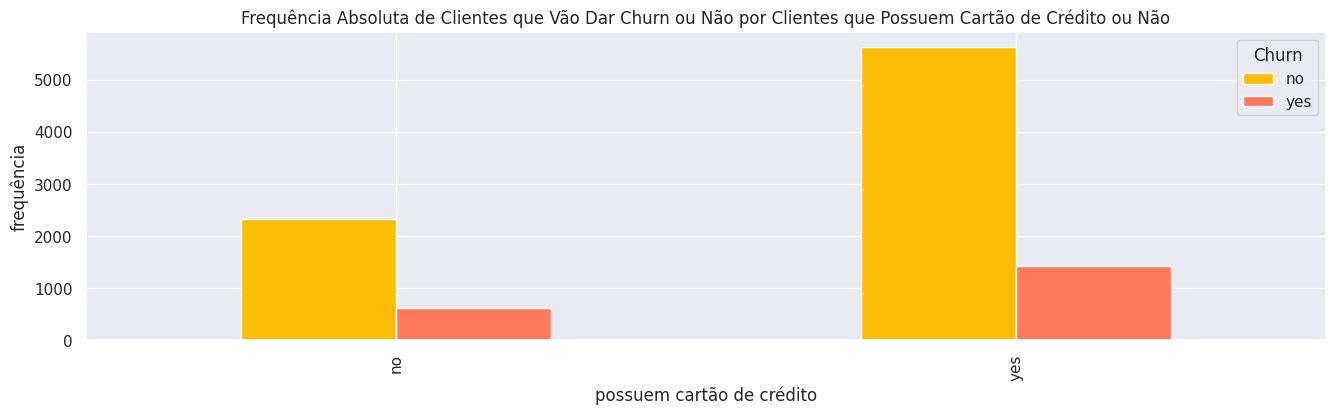

In [54]:
df_aux = df4[['id_cliente','Churn', 'tem_cartao_credito']].groupby(['Churn','tem_cartao_credito']).count()
df_aux.reset_index().pivot(index='tem_cartao_credito', columns='Churn', values='id_cliente').plot(kind='bar')

# Adiciona títulos e etiquetas
plt.title('Frequência Absoluta de Clientes que Vão Dar Churn ou Não por Clientes que Possuem Cartão de Crédito ou Não')
plt.xlabel('possuem cartão de crédito')
plt.ylabel('frequência')
plt.legend(title= 'Churn');

# Exibe o gráfico
plt.show()

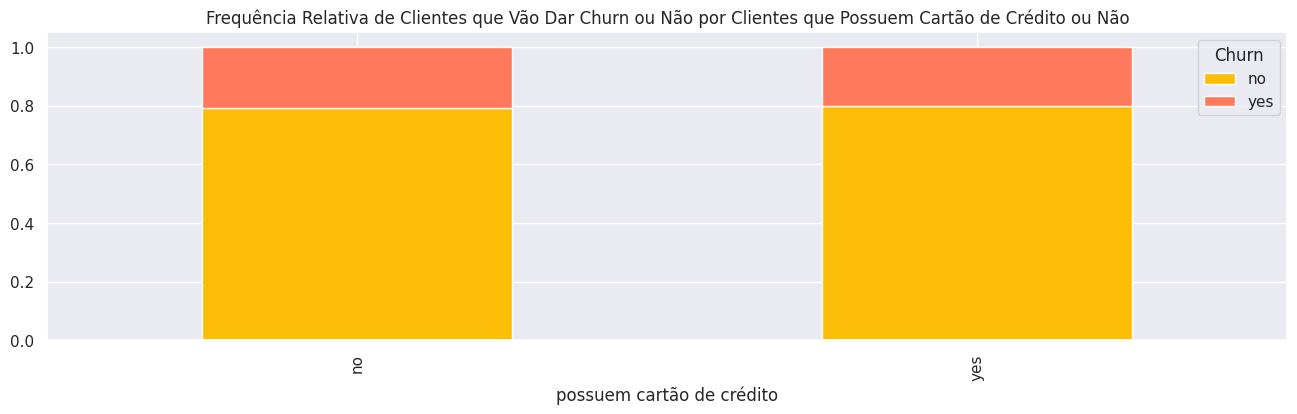

In [55]:
table = pd.crosstab(df4['tem_cartao_credito'], df4['Churn'], normalize='index')
table = table.div(table.sum(1), axis=0)
table.plot(kind='bar', stacked=True)

# Adiciona títulos e etiquetas
plt.title('Frequência Relativa de Clientes que Vão Dar Churn ou Não por Clientes que Possuem Cartão de Crédito ou Não')
plt.xlabel('possuem cartão de crédito')

# Exibe o gráfico
plt.show()

#### *membro_ativo*

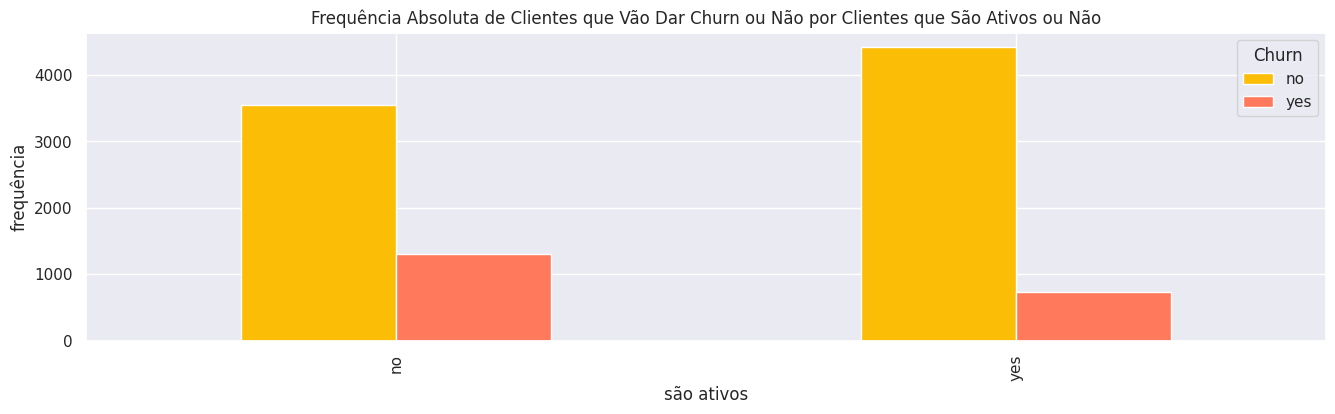

In [56]:
df_aux = df4[['id_cliente','Churn', 'membro_ativo']].groupby(['Churn','membro_ativo']).count()
df_aux.reset_index().pivot(index='membro_ativo', columns='Churn', values='id_cliente').plot(kind='bar')

# Adiciona títulos e etiquetas
plt.title('Frequência Absoluta de Clientes que Vão Dar Churn ou Não por Clientes que São Ativos ou Não')
plt.xlabel('são ativos')
plt.ylabel('frequência')
plt.legend(title= 'Churn');

# Exibe o gráfico
plt.show()

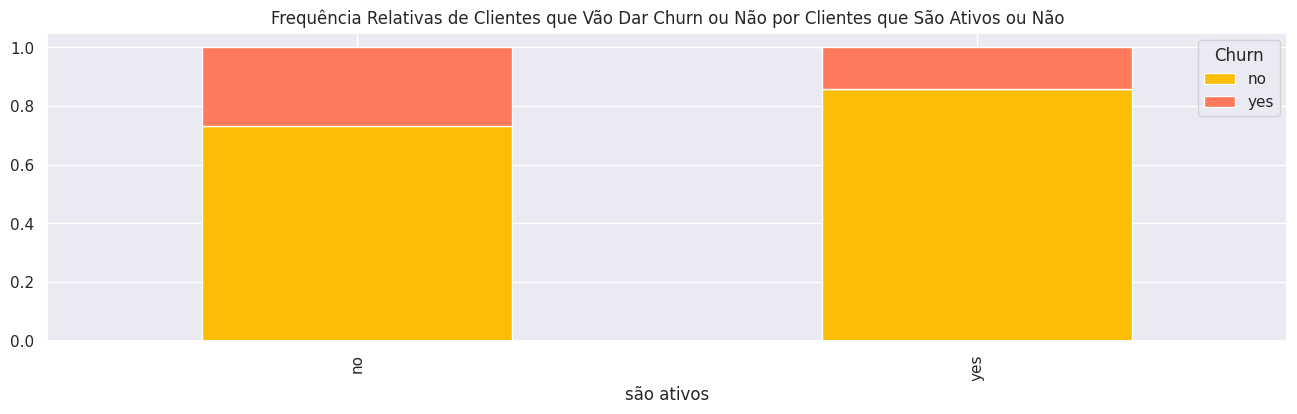

In [57]:
table = pd.crosstab(df4['membro_ativo'], df4['Churn'], normalize='index')
table = table.div(table.sum(1), axis=0)
table.plot(kind='bar', stacked=True)

# Adiciona títulos e etiquetas
plt.title('Frequência Relativas de Clientes que Vão Dar Churn ou Não por Clientes que São Ativos ou Não')
plt.xlabel('são ativos')

# Exibe o gráfico
plt.show()

#### *escala_fico*

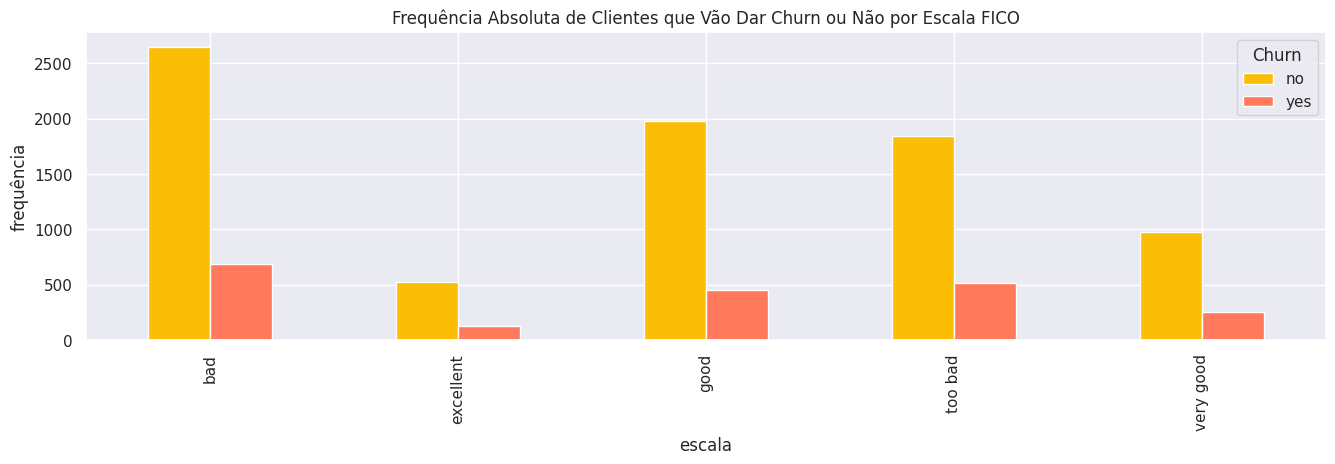

In [58]:
df_aux = df4[['id_cliente','Churn', 'escala_fico']].groupby(['Churn','escala_fico']).count()
df_aux.reset_index().pivot(index='escala_fico', columns='Churn', values='id_cliente').plot(kind='bar')

# Adiciona títulos e etiquetas
plt.title('Frequência Absoluta de Clientes que Vão Dar Churn ou Não por Escala FICO')
plt.xlabel('escala')
plt.ylabel('frequência')
plt.legend(title= 'Churn');

# Exibe o gráfico
plt.show()

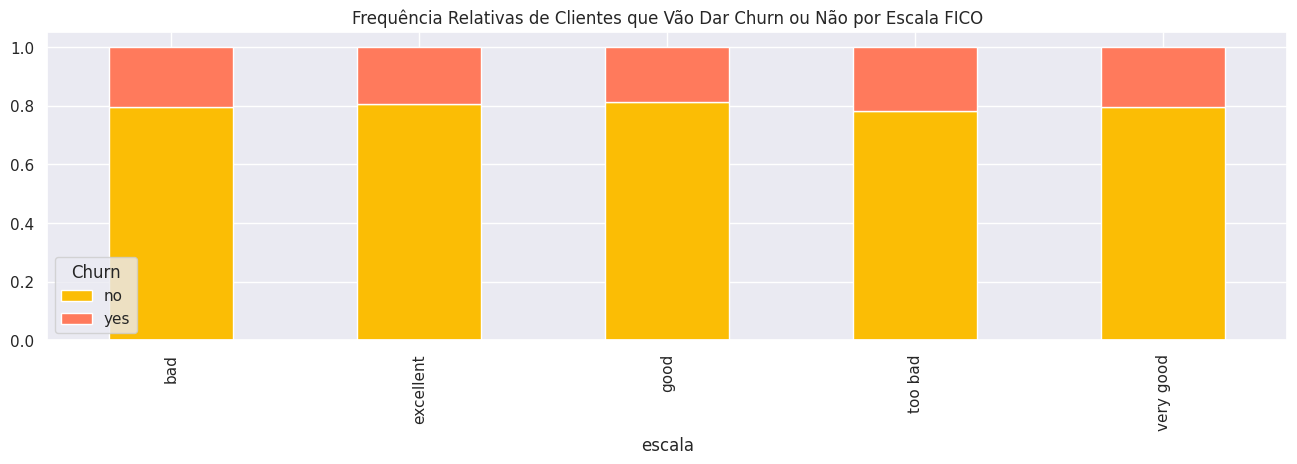

In [59]:
table = pd.crosstab(df4['escala_fico'], df4['Churn'], normalize='index')
table = table.div(table.sum(1), axis=0)
table.plot(kind='bar', stacked=True)

# Adiciona títulos e etiquetas
plt.title('Frequência Relativas de Clientes que Vão Dar Churn ou Não por Escala FICO')
plt.xlabel('escala')

# Exibe o gráfico
plt.show()

## Multivariate Analysis

### Categorical Variables

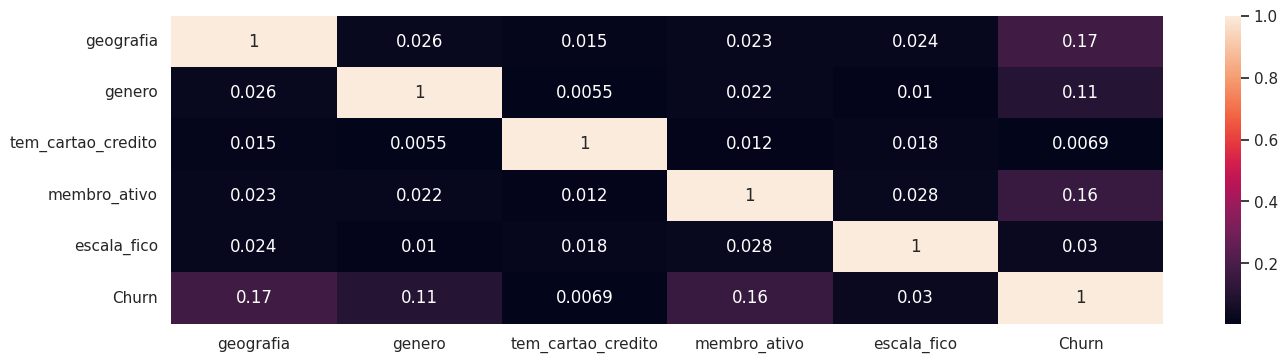

In [60]:
categorical_dataframe = categorical_attributes

#calculate Cramer's V
cramer_v1 = cramer_v(categorical_dataframe['geografia'], categorical_dataframe['geografia'])
cramer_v2 = cramer_v(categorical_dataframe['geografia'], categorical_dataframe['genero'])
cramer_v3 = cramer_v(categorical_dataframe['geografia'], categorical_dataframe['tem_cartao_credito'])
cramer_v4 = cramer_v(categorical_dataframe['geografia'], categorical_dataframe['membro_ativo'])
cramer_v5 = cramer_v(categorical_dataframe['geografia'], categorical_dataframe['escala_fico'])
cramer_v6 = cramer_v(categorical_dataframe['geografia'], categorical_dataframe['Churn'])

cramer_v7 = cramer_v(categorical_dataframe['genero'], categorical_dataframe['geografia'])
cramer_v8 = cramer_v(categorical_dataframe['genero'], categorical_dataframe['genero'])
cramer_v9 = cramer_v(categorical_dataframe['genero'], categorical_dataframe['tem_cartao_credito'])
cramer_v10 = cramer_v(categorical_dataframe['genero'], categorical_dataframe['membro_ativo'])
cramer_v11 = cramer_v(categorical_dataframe['genero'], categorical_dataframe['escala_fico'])
cramer_v12 = cramer_v(categorical_dataframe['genero'], categorical_dataframe['Churn'])

cramer_v13 = cramer_v(categorical_dataframe['tem_cartao_credito'], categorical_dataframe['geografia'])
cramer_v14 = cramer_v(categorical_dataframe['tem_cartao_credito'], categorical_dataframe['genero'])
cramer_v15 = cramer_v(categorical_dataframe['tem_cartao_credito'], categorical_dataframe['tem_cartao_credito'])
cramer_v16 = cramer_v(categorical_dataframe['tem_cartao_credito'], categorical_dataframe['membro_ativo'])
cramer_v17 = cramer_v(categorical_dataframe['tem_cartao_credito'], categorical_dataframe['escala_fico'])
cramer_v18 = cramer_v(categorical_dataframe['tem_cartao_credito'], categorical_dataframe['Churn'])

cramer_v19 = cramer_v(categorical_dataframe['membro_ativo'], categorical_dataframe['geografia'])
cramer_v20 = cramer_v(categorical_dataframe['membro_ativo'], categorical_dataframe['genero'])
cramer_v21 = cramer_v(categorical_dataframe['membro_ativo'], categorical_dataframe['tem_cartao_credito'])
cramer_v22 = cramer_v(categorical_dataframe['membro_ativo'], categorical_dataframe['membro_ativo'])
cramer_v23 = cramer_v(categorical_dataframe['membro_ativo'], categorical_dataframe['escala_fico'])
cramer_v24 = cramer_v(categorical_dataframe['membro_ativo'], categorical_dataframe['Churn'])

cramer_v25 = cramer_v(categorical_dataframe['escala_fico'], categorical_dataframe['geografia'])
cramer_v26 = cramer_v(categorical_dataframe['escala_fico'], categorical_dataframe['genero'])
cramer_v27 = cramer_v(categorical_dataframe['escala_fico'], categorical_dataframe['tem_cartao_credito'])
cramer_v28 = cramer_v(categorical_dataframe['escala_fico'], categorical_dataframe['membro_ativo'])
cramer_v29 = cramer_v(categorical_dataframe['escala_fico'], categorical_dataframe['escala_fico'])
cramer_v30 = cramer_v(categorical_dataframe['escala_fico'], categorical_dataframe['Churn'])

cramer_v31 = cramer_v(categorical_dataframe['Churn'], categorical_dataframe['geografia'])
cramer_v32 = cramer_v(categorical_dataframe['Churn'], categorical_dataframe['genero'])
cramer_v33 = cramer_v(categorical_dataframe['Churn'], categorical_dataframe['tem_cartao_credito'])
cramer_v34 = cramer_v(categorical_dataframe['Churn'], categorical_dataframe['membro_ativo'])
cramer_v35 = cramer_v(categorical_dataframe['Churn'], categorical_dataframe['escala_fico'])
cramer_v36 = cramer_v(categorical_dataframe['Churn'], categorical_dataframe['Churn'])

#final dataset
cramer_v_dataset = pd.DataFrame({'geografia': [cramer_v1, cramer_v2, cramer_v3, cramer_v4, cramer_v5, cramer_v6],
                                 'genero': [cramer_v7, cramer_v8, cramer_v9, cramer_v10, cramer_v11, cramer_v12], 
                                 'tem_cartao_credito': [cramer_v13, cramer_v14, cramer_v15, cramer_v16, cramer_v17, cramer_v18],
                                 'membro_ativo': [cramer_v19, cramer_v20, cramer_v21, cramer_v22, cramer_v23, cramer_v24],
                                 'escala_fico': [cramer_v25, cramer_v26, cramer_v27, cramer_v28, cramer_v29, cramer_v30],
                                 'Churn': [cramer_v31, cramer_v32, cramer_v33, cramer_v34, cramer_v35, cramer_v36]})

cramer_v_dataset = cramer_v_dataset.set_index(cramer_v_dataset.columns)

sns.heatmap(cramer_v_dataset, annot= True);

### Numeric Variables

In [61]:
df4['Churn'] = df4['Churn'].apply(lambda x: 1 if x == 'yes' else 0)

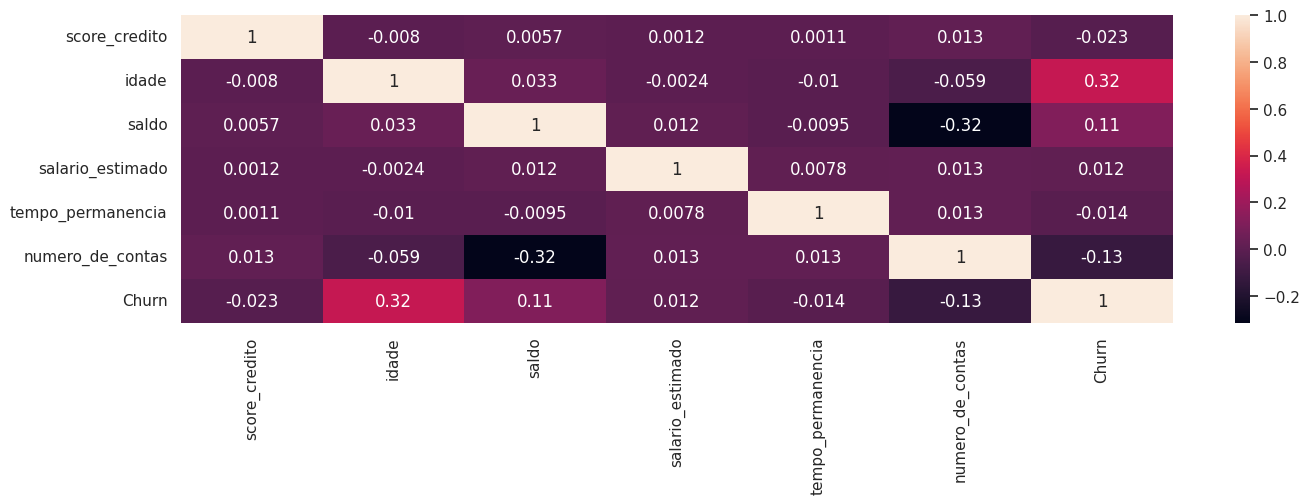

In [62]:
variables =  df4[['score_credito', 'idade', 'saldo', 'salario_estimado', 'tempo_permanencia', 'numero_de_contas', 'Churn']]
correlation = variables.corr(method= 'spearman')
sns.heatmap(correlation, annot= True);

## Note:
Informações Importantes:

**Análise Univariada:**
- ***score_credito***: existem poucos outliers que não são tão relevantes devido ao valor da curtose, logo podem permanecer.
- ***idade***: existem muitos outliers relevantes na variável, acima de 62 anos. Vale tratá-los.
- ***salario_estimado***: mais de 36% dos clientes possuem contas zeradas, evidenciado pela variável .
- ***numero_de_contas***: apenas 3,26% de cleintes possuem 3 ou 4 contas.
- ***geografia***: metade dos clientes são da França (50,14%). A outra metade se divide praticamente igual entre Alemanha (25.09%) e Espanha (24.77%)
- ***tem_cartao_credito***: 70.55% dos clientes possuem cartão de crédito.
- ***escala_fico***: menos de 20% possuem scores muito bons ou excelentes.

**Análise Bivariada e Multivariada**
- ***score_credito***: não há efeito significativo na variável Churn. Apenas poucos outliers com scores próximos de 350 na distribuição de clientes positivos para Churn. Correlação muito fraca com a variável Churn = -0.023
- ***idade***: <span style="background:LightGreen">pode ter efeito significativo na variável Churn. Clientes negativos para churn tendem a ser mais novos (metade dos dados entre 32 - 42 anos e presença de muitos outliers a partir de 56 anos) e clientes positivos tendem a ser mais velhos (metade dos dados entre 36 - 52 anos e presença de poucos outliers a partir de 70 anos e abaixo de 19). Correlação moderada com a variável Churn = 0.32</span>
- ***saldo***: <span style="background:LightYellow">pode ter pouco efeito significativo na variável Churn. A diferença que chama atenção entre as distribuições, é a presença de 0, onde clientes positivos para churn e que possuem o saldo zerado são quase o dobro em relação aos clientes negativos para churn e que possuem o saldo zerado. Correlação fraca com a variável Churn = 0.11</span>
- ***salario_estimado***: não deve ter efeito significativo na variável Churn. Apenas chama atenção um detalhe, onde salários maiores, próximos de US200000.00 tem uma proporção de Churn maior. Correlação muito fraca com a variável Churn = 0.012
- ***tempo_permanencia***: não deve ter efeito significativo na variável Churn. Todas os anos possuem quase o mesmo padrão, onde 20% querem sair do banco e 80% não. Correlação muito fraca com a variável Churn = -0.014
- ***numero_de_contas***: <span style="background:LightYellow">pode ter pouco efeito na variável Churn. 100% dos que possuem 4 contas e 80% dos que possuem 3 contas querem sair do banco, porém esses clientes que possuem 3 ou 4 representam um porcentagem muito pequena do conjunto de dados (menos de 5%). Mas possui uma correlação fraca com a variável Churn = -0.13</span>

- ***geografia***: <span style="background:LightYellow">pode ter pouco efeito significativo na variável Churn. De todos os clientes que residem na França ou na Espanha, apenas 16% querem sair do banco. Mas a Alemanha tem essa proporção dobrada, 32% querem sair do banco. Correlação fraca com a variável Churn = 0.17</span>

- ***genero***: <span style="background:LightYellow">pode ter pouco efeito significativo na variável Churn. Mulheres querem sair do banco mais que os homens. 25% das mulheres e 16% dos homens. Correlação fraca com a variável Churn = 0.11</span>

- ***tem_cartao_credito***: não há efeito significativo na variável Churn. De todos os cliente que possuem cartão ou não, apenas 20% querem sair do banco. Correlação muito fraca com a variável Churn = 0.0069

- ***membro_ativo***: <span style="background:LightYellow">pode ter pouco efeito significativo na variável Churn. Essa variável possui quase o mesmo comportamento da variável gênero, onde Clientes inativos querem sair do banco mais que os inativos. 26%  dos inativos e 14% dos ativos. Correlação fraca com a variável Churn = 0.16</span>

- ***escala_fico***: não há efeito significativo na variável Churn. Todas as classes possuem quase o mesmo padrão, onde 20% querem sair do banco e 80% não. Correlação muito fraca com a variável Churn = 0.03

Observação:
- Como o conjunto de dados possui muita dispersão, estou usando a relação de correlação de Jacob Cohen (1992):

	- corr = 0,10 => correlação fraca.
    - corr = 0,30 => correlação moderada.
    - corr = 0,50 => correlação forte

Próxima versão: 
- Utilizar testes estatísticos para validar comportamento das distribuições;
- Testar método PolynomialFeatures sklearn para criação de Features Interactions;
- Melhorar funções para plotagens dos gráficos;

# Feature Engineering (Data Preparation)

In [63]:
df5 = df4.copy()

## Data Filtering

In [64]:
data_for_filtering = df5.copy()

In [65]:
columns_to_delete = ['numero_linha', 'id_cliente', 'sobrenome']
filtered_data = data_for_filtering.drop(columns_to_delete, axis= 1) 

In [66]:
filtered_data.head()

score_credito geografia  genero  idade  tempo_permanencia      saldo  numero_de_contas tem_cartao_credito membro_ativo  salario_estimado  Churn escala_fico
0            619    France  Female     42                  2       0.00                 1                yes          yes         101348.88      1         bad
1            608     Spain  Female     41                  1   83807.86                 1                 no          yes         112542.58      0         bad
2            502    France  Female     42                  8  159660.80                 3                yes           no         113931.57      1     too bad
3            699    France  Female     39                  1       0.00                 2                 no           no          93826.63      0        good
4            850     Spain  Female     43                  2  125510.82                 1                yes          yes          79084.10      0   excellent

## Splitting Dataframe into Training and Test Dataset

In [67]:
X = filtered_data
y = filtered_data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33, random_state= 33)

In [68]:
X_train.reset_index(drop= True, inplace= True)
X_test.reset_index(drop= True, inplace= True)
y_train.reset_index(drop= True, inplace= True)
y_test.reset_index(drop= True, inplace= True)

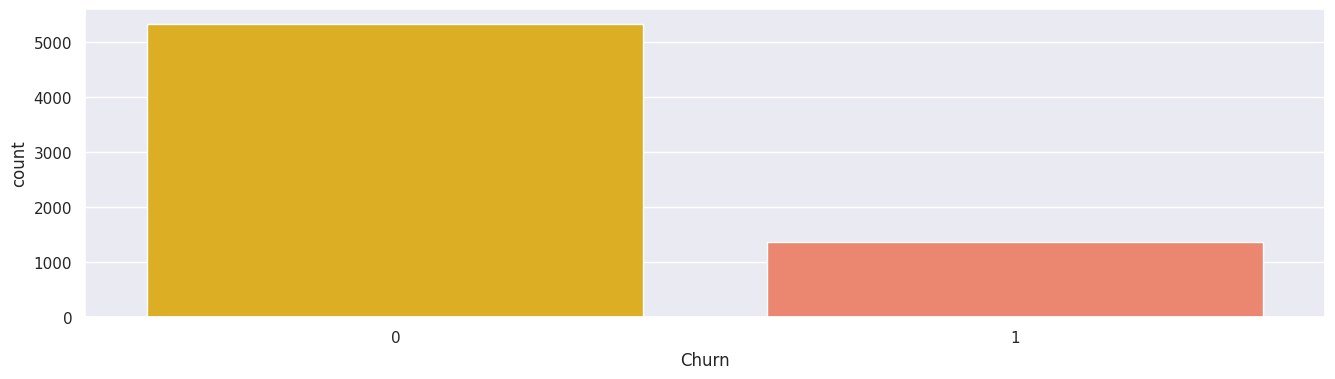

In [69]:
sns.countplot(x= y_train);

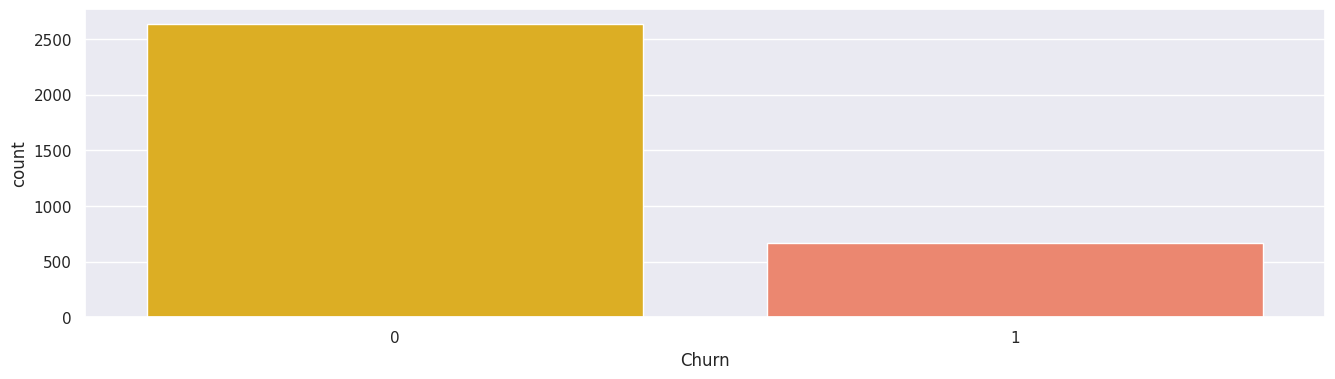

In [70]:
sns.countplot(x= y_test);

## Creation of the New Features II or Feature Interactions

- A estratégia na criação de novas variáveis é usar variáveis reconhecidas pelo brainstorm de negócio e com efeitos significativos na variável Churn evidenciada pela análise exploratória de dados e combiná-las para potencializar seus impactos. 

**Brainstorm**

Principais fatores para um cliente querer fechar uma conta/sair de um banco:

1. Corte de gastos

		P: O que leva uma pessoa a cortar gastos?
		R: Ou o salário foi reduzido, ou faltou organização financeira, entrando em endividamento.
		Variáveis disponíveis impactadas: salario_estimado baixo, score_credito baixo, saldo baixo, tem_cartao_credito, numero de contas alto
	
2. Insatisfação com o Banco

		P: O que leva uma pessoa a estar insatisfeita com um banco?
    	R: Suporte ruim, taxas elevadas, falta de transparência, problemas com transações ou aplicações, falta na segurança dos dados.
		Variáveis disponíveis impactadas: tempo_permanencia curto, negativo para membro_ativo.

3. Concorrente tem mais benefícios
		
        Variáveis disponíveis impactadas: nenhuma.

Principais fatores para um cliente não querer fechar uma conta/sair de um banco:

1. Comodidade aliado com benefícios, e bom produto.
		Variáveis disponíveis que impactam a causa: tempo_permanencia, membro_ativo, numero_de_contas, tem_cartao_credito

**Variáveis**

- Variáveis do Brainstorm: [<span style="background:LightYellow">'saldo', 'membro_ativo', 'numero_de_contas'</span>, 'salario_estimado', 'score_credito', 'tem_cartao_credito', 'tempo_permanencia']
- Variáveis da Análise Exploratória: [<span style="background:LightGreen">'idade'</span>, <span style="background:LightYellow">'saldo', 'geografia', 'genero', 'membro_ativo'</span>, 'salario_estimado'] 

Idéias de Variáveis:

	- saldo por salário (saldo/salario_estimado) -> combinação de impacto fraco + impacto fraco
	- saldo por score de crédito (saldo/score_credito) -> combinação de impacto fraco + impacto muito fraco
    - saldo por numero de contas (saldo/numero_contas) -> combinação de impacto fraco + impacto fraco
	- saldo acumulado por cada ano de idade (saldo/idade) > combinação de impacto fraco + impacto forte
	- salário por numero de contas (salario_estimado/numero_de_contas) -> combinação de impacto fraco + impacto fraco
	- salário por score de crédito (salario_estimado/score_credito) -> combinação de impacto fraco + impacto muito fraco
	- salário total em x ano de permanencia (salario_estimado * tempo_permanencia) -> combinação de impacto fraco + impacto muito fraco
	- salário por idade (salario_estimado/idade) -> combinação de impacto fraco + impacto forte
	- score de crédito por idade (score_credito/idade) -> combinação de impacto muito fraco + impacto forte
	- score de crédito por numero de contas (score_credito/numero_de_contas) -> combinação de impacto muito fraco + impacto fraco
	- tempo no banco por idade (tempo_permanencia/idade) -> combinação de impacto muito fraco + impacto forte
    - tempo no banco por numero de contas (tempo_permanencia/numero_de_contas) combinação de impacto muito fraco + impacto fraco
	- numero de contas por idade (numero_de_contas/idade) -> combinação de impacto fraco + impacto forte
	- numero de contas por tempo permanencia (numero_de_contas/tempo_permanencia) -> combinação impacto fraco + impacto muito fraco
	- média de saldo por idade (media de saldo por agrupamento de idade) -> combinação de impacto fraco + impacto forte
	- média de salário por idade (media de salario_estimado por agrupamento de idade) -> combinação de impacto fraco + impacto forte
    
Observação:

- Criei muitas métricas/features nesse ciclo por dois motivos:

		1. Os significados das variáveis e o período da extração dos dados não são bem definidos. Logo, com mais features criadas, maior a chance de encontrar alguma interação que tenha uma correlação significativa com a variável resposta.
        2. Features Interactions são úteis para modelos lineares. Já modelos baseados em árvore de decisão, já fazem interações desse tipo em seu funcionamento.

In [71]:
X_train['saldo_por_salario'] = X_train['saldo'] / X_train['salario_estimado']
X_test['saldo_por_salario'] = X_test['saldo'] / X_test['salario_estimado']

In [72]:
X_train['saldo_por_score'] = X_train['saldo'] / X_train['score_credito']
X_test['saldo_por_score'] = X_test['saldo'] / X_test['score_credito']

In [73]:
X_train['saldo_por_numero_contas'] = X_train['saldo'] / X_train['numero_de_contas']
X_test['saldo_por_numero_contas'] = X_test['saldo'] / X_test['numero_de_contas']

In [74]:
X_train['saldo_por_idade'] = X_train['saldo'] / X_train['idade']
X_test['saldo_por_idade'] = X_test['saldo'] / X_test['idade']

In [75]:
X_train['salario_por_numero_de_contas'] = X_train['salario_estimado'] / X_train['numero_de_contas']
X_test['salario_por_numero_de_contas'] = X_test['salario_estimado'] / X_test['numero_de_contas']

In [76]:
X_train['salario_por_score'] = X_train['salario_estimado'] / X_train['score_credito']
X_test['salario_por_score'] = X_test['salario_estimado'] / X_test['score_credito']

In [77]:
X_train['salario_x_tempo_permanencia'] = X_train['salario_estimado'] * X_train['tempo_permanencia']
X_test['salario_x_tempo_permanencia'] = X_test['salario_estimado'] * X_test['tempo_permanencia']

In [78]:
X_train['salario_por_idade'] = X_train['salario_estimado'] / X_train['idade']
X_test['salario_por_idade'] = X_test['salario_estimado'] / X_test['idade']

In [79]:
X_train['score_credito_por_idade'] = X_train['score_credito'] / X_train['idade']
X_test['score_credito_por_idade'] = X_test['score_credito'] / X_test['idade']

In [80]:
X_train['score_credito_por_numero_de_contas'] = X_train['score_credito'] / X_train['numero_de_contas']
X_test['score_credito_por_numero_de_contas'] = X_test['score_credito'] / X_test['numero_de_contas']

In [81]:
X_train['tempo_permanencia_por_idade'] = X_train['tempo_permanencia'] / X_train['idade']
X_test['tempo_permanencia_por_idade'] = X_test['tempo_permanencia'] / X_test['idade']

In [82]:
X_train['tempo_permanencia_por_numero_de_contas'] = X_train['tempo_permanencia'] / X_train['numero_de_contas']
X_test['tempo_permanencia_por_numero_de_contas'] = X_test['tempo_permanencia'] / X_test['numero_de_contas']

In [83]:
X_train['numero_contas_por_idade'] = X_train['numero_de_contas'] / X_train['idade']
X_test['numero_contas_por_idade'] = X_test['numero_de_contas'] / X_test['idade']

In [84]:
X_train['numero_de_contas_por_tempo_permanencia'] = X_train['numero_de_contas'] / X_train['tempo_permanencia']
X_train['numero_de_contas_por_tempo_permanencia'] = X_train['numero_de_contas_por_tempo_permanencia'].apply(lambda x: 0 if x == np.inf else x)
X_test['numero_de_contas_por_tempo_permanencia'] = X_test['numero_de_contas'] / X_test['tempo_permanencia']
X_test['numero_de_contas_por_tempo_permanencia'] = X_test['numero_de_contas_por_tempo_permanencia'].apply(lambda x: 0 if x == np.inf else x)

In [85]:
# X_train
mean_balance_for_age = X_train[['saldo', 'idade']].groupby('idade').mean().reset_index()
mean_balance_for_age.columns = ['idade', 'media_saldo_por_idade']

#merge'
X_train = pd.merge(X_train, mean_balance_for_age, on= 'idade', how= 'left')

#X_test
mean_balance_for_age = X_test[['saldo', 'idade']].groupby('idade').mean().reset_index()
mean_balance_for_age.columns = ['idade', 'media_saldo_por_idade']

#merge'
X_test = pd.merge(X_test, mean_balance_for_age, on= 'idade', how= 'left')

In [86]:
#X_train
mean_salary_for_age = X_train[['salario_estimado', 'idade']].groupby('idade').mean().reset_index()
mean_salary_for_age.columns = ['idade', 'media_salarial_por_idade']

#merge'
X_train = pd.merge(X_train, mean_salary_for_age, on= 'idade', how= 'left')

#X_test
mean_salary_for_age = X_test[['salario_estimado', 'idade']].groupby('idade').mean().reset_index()
mean_salary_for_age.columns = ['idade', 'media_salarial_por_idade']

#merge'
X_test = pd.merge(X_test, mean_salary_for_age, on= 'idade', how= 'left')

In [87]:
X_train.sample(5)

score_credito geografia  genero  idade  tempo_permanencia      saldo  numero_de_contas tem_cartao_credito membro_ativo  salario_estimado  Churn escala_fico  saldo_por_salario  saldo_por_score  saldo_por_numero_contas  saldo_por_idade  salario_por_numero_de_contas  salario_por_score  salario_x_tempo_permanencia  salario_por_idade  score_credito_por_idade  score_credito_por_numero_de_contas  tempo_permanencia_por_idade  tempo_permanencia_por_numero_de_contas  numero_contas_por_idade  numero_de_contas_por_tempo_permanencia  media_saldo_por_idade  media_salarial_por_idade
2133            828   Germany  Female     25                  7  144351.86                 1                yes           no         116613.26      0   excellent           1.237868       174.337995               144351.860      5774.074400                    116613.260         140.837271                    816292.82        4664.530400                33.120000                               828.0                     0.280000                                     7.0                 0.040000                                0.142857           77371.084000             101429.951400
5736            596    France    Male     21                  4  210433.08                 2                 no          yes         197297.77      1         bad           1.066576       353.075638               105216.540     10020.622857                     98648.885         331.036527                    789191.08        9395.131905                28.380952                               298.0                     0.190476                                     2.0                 0.095238                                0.500000           77029.354444             104111.554444
2397            599     Spain  Female     28                  4  126833.79                 2                yes           no          60843.09      1         bad           2.084605       211.742554                63416.895      4529.778214                     30421.545         101.574441                    243372.36        2172.967500                21.392857                               299.5                     0.142857                                     2.0                 0.071429                                0.500000           74520.678670              93805.731968
540             543    France  Female     34                  8       0.00                 2                 no          yes         145601.80      0     too bad           0.000000         0.000000                    0.000         0.000000                     72800.900         268.143278                   1164814.40        4282.405882                15.970588                               271.5                     0.235294                                     4.0                 0.058824                                0.250000           68099.856742             100470.116355
1012            573     Spain    Male     46                  3   65269.23                 1                 no          yes         189988.65      1     too bad           0.343543       113.907906                65269.230      1418.896304                    189988.650         331.568325                    569965.95        4130.188043                12.456522                               573.0                     0.065217                                     3.0                 0.021739                                0.333333           72952.702949              94244.243782

### Exploratory Analysis of New Features

#### Univariate Analysis

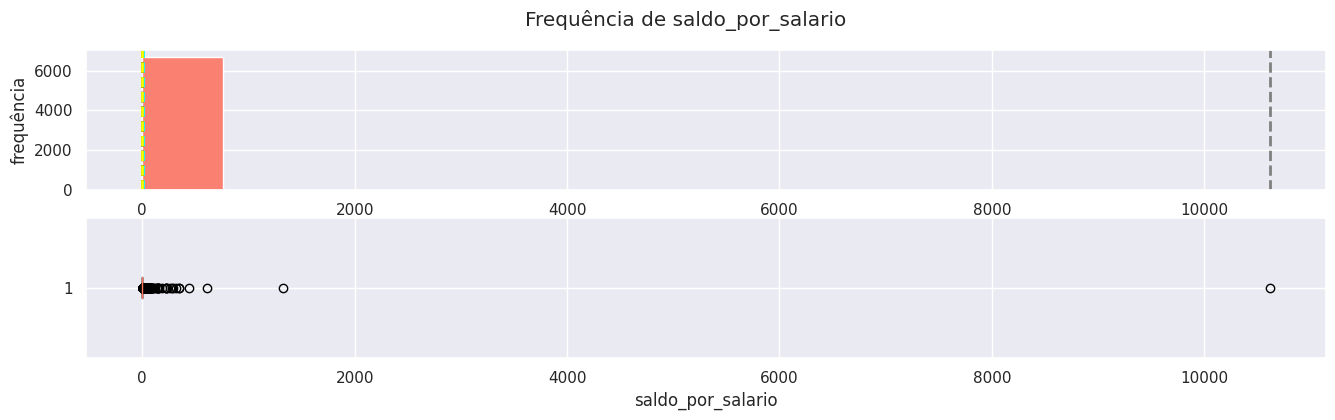

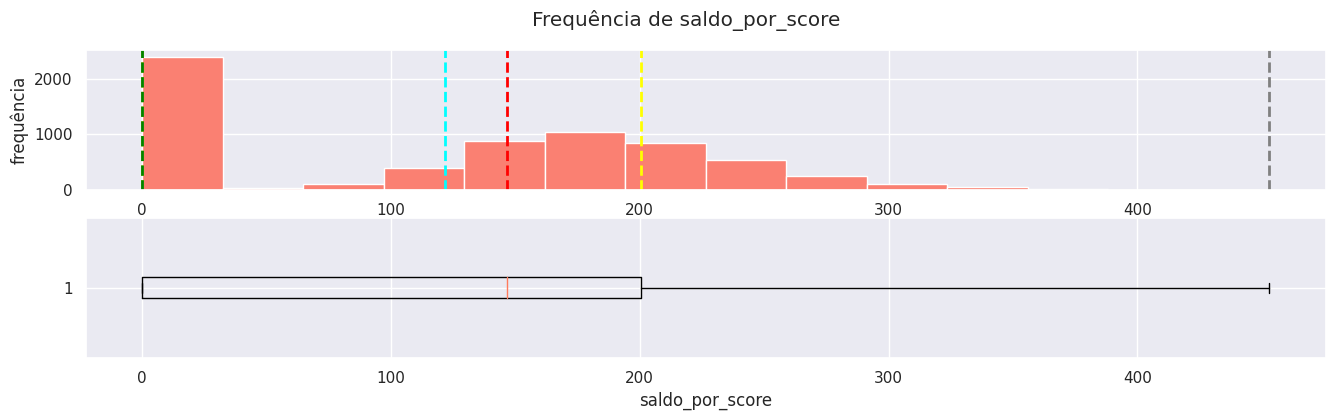

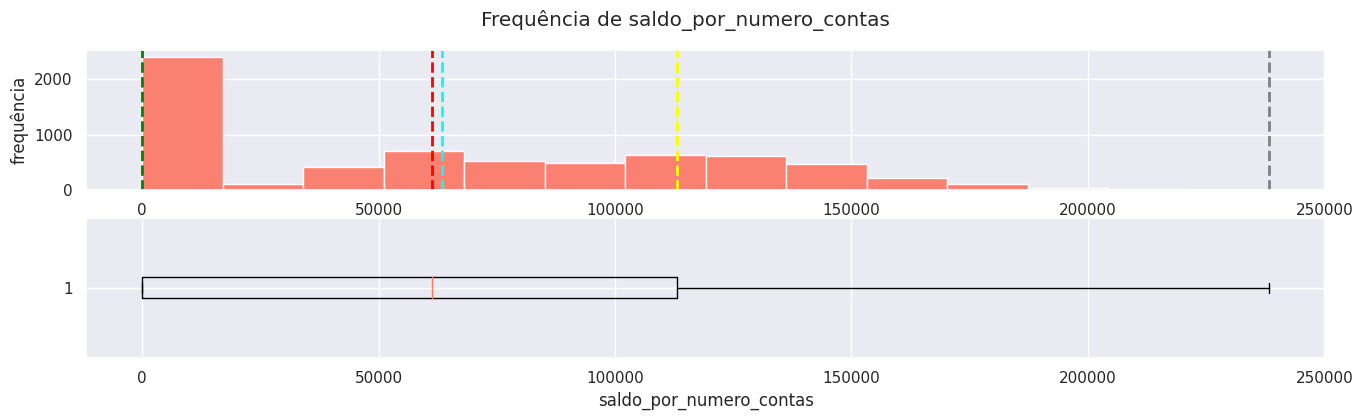

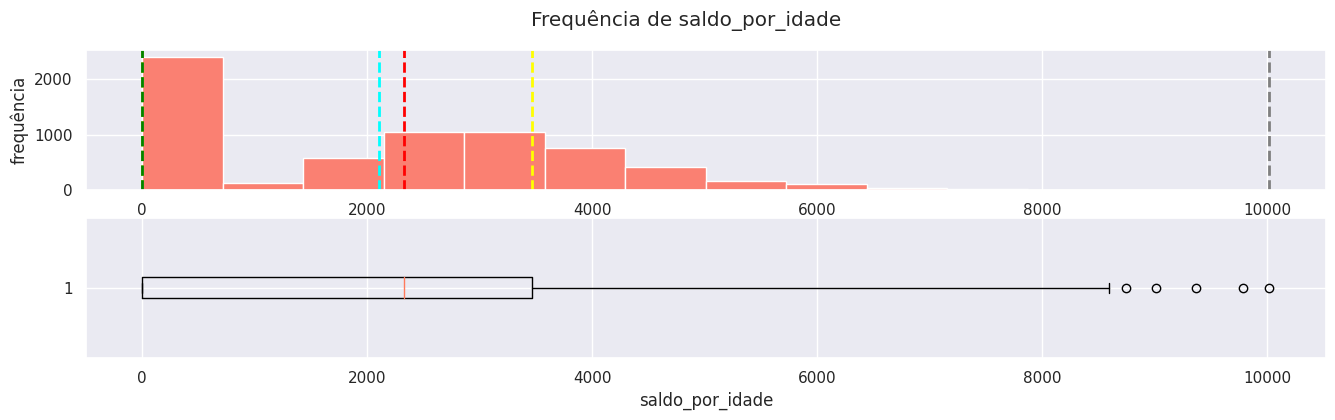

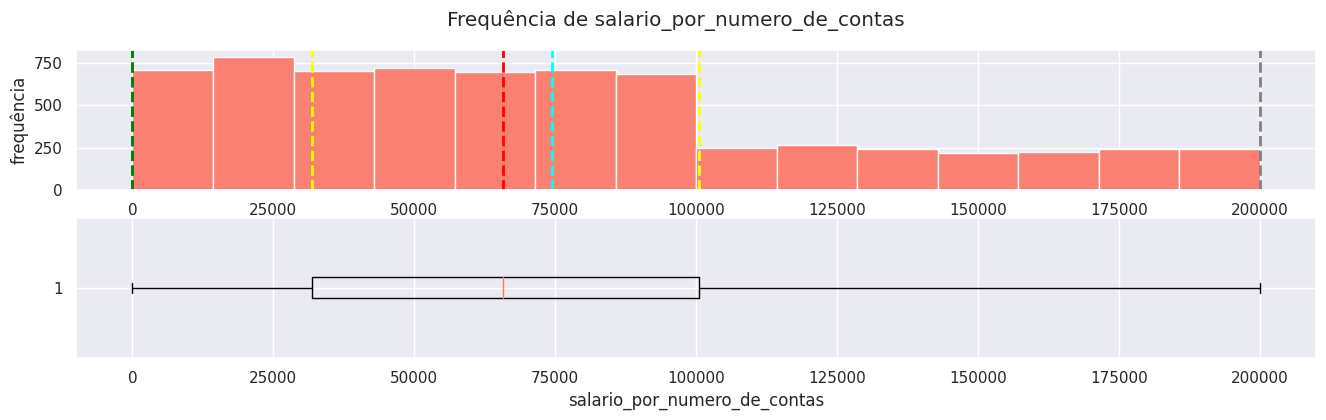

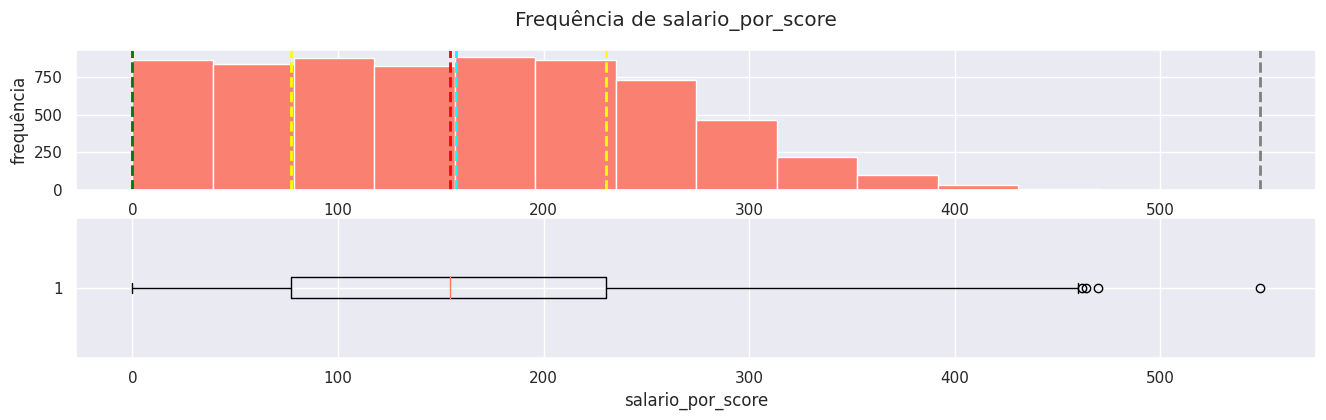

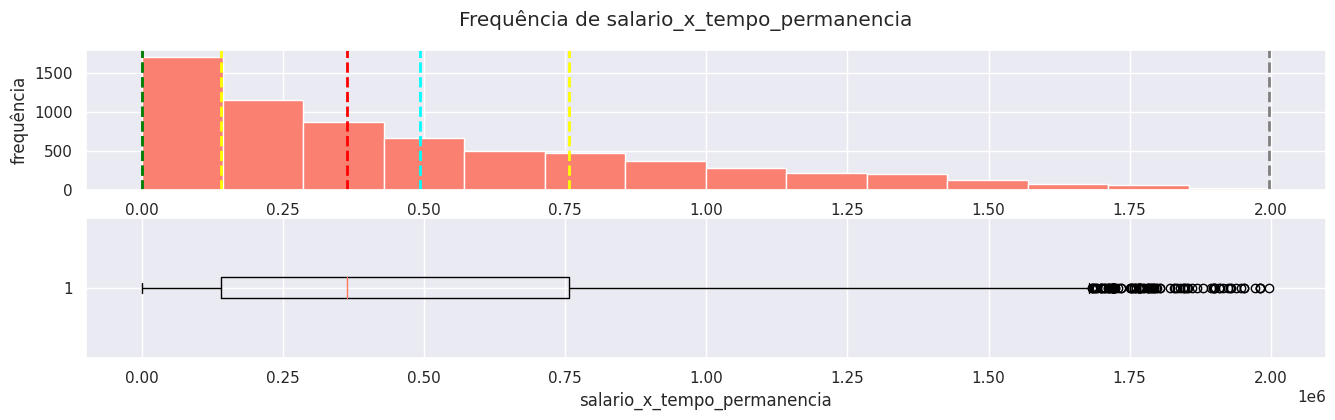

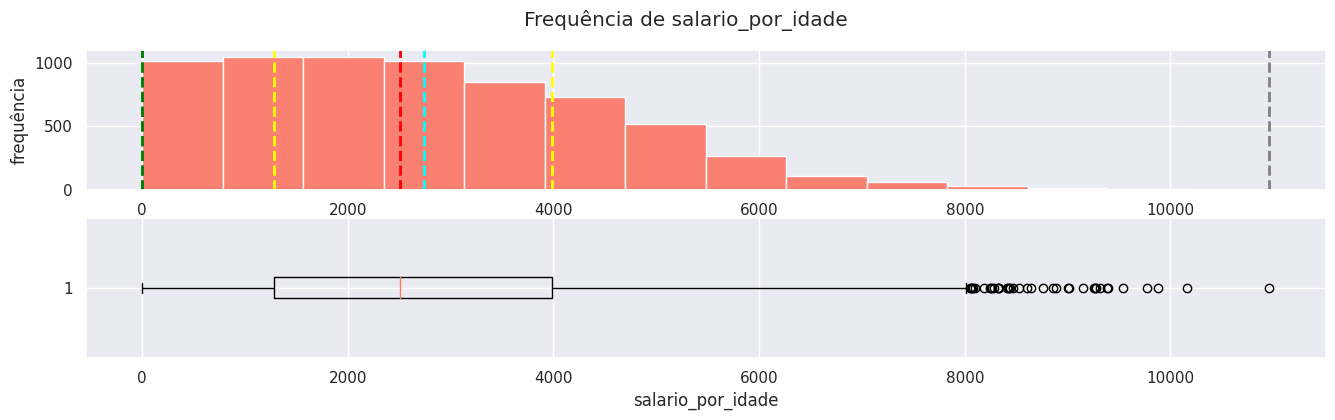

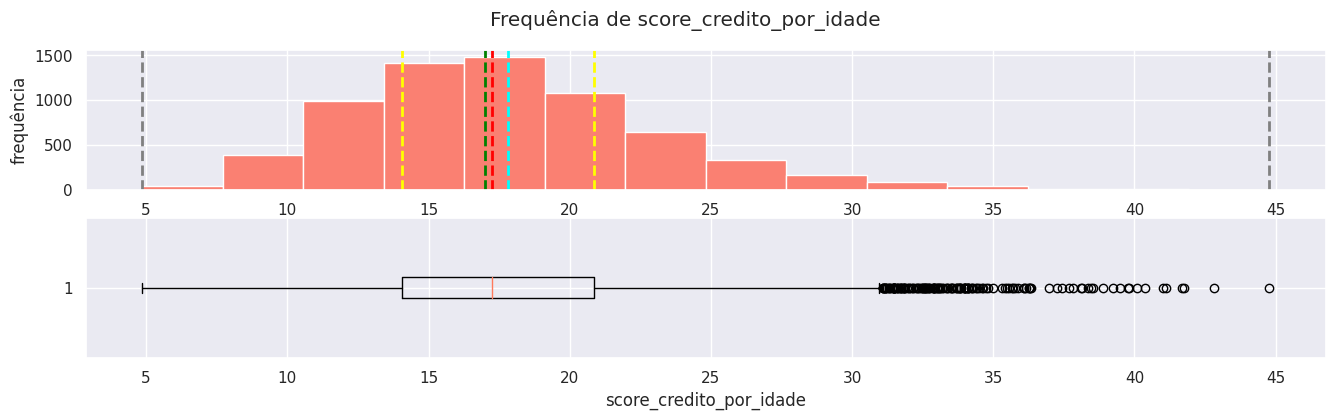

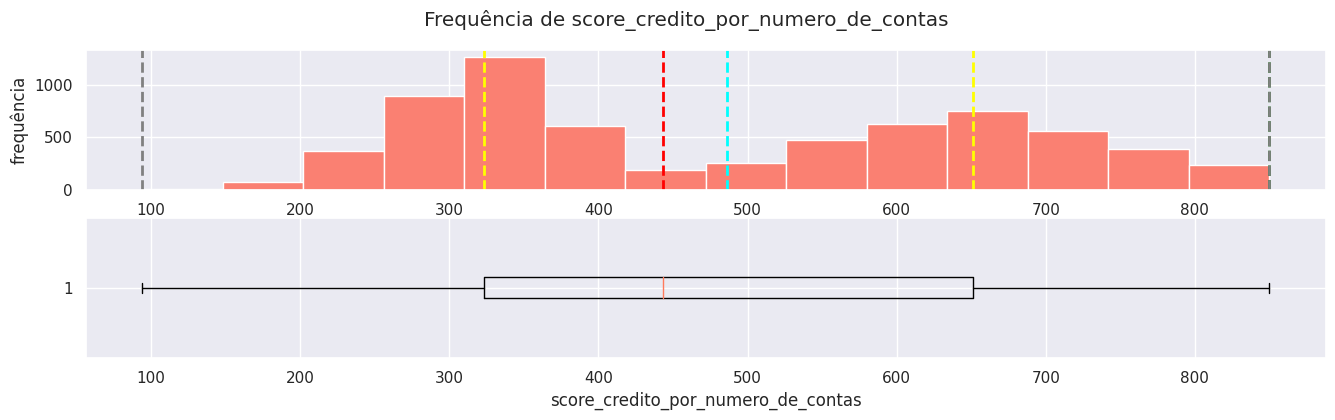

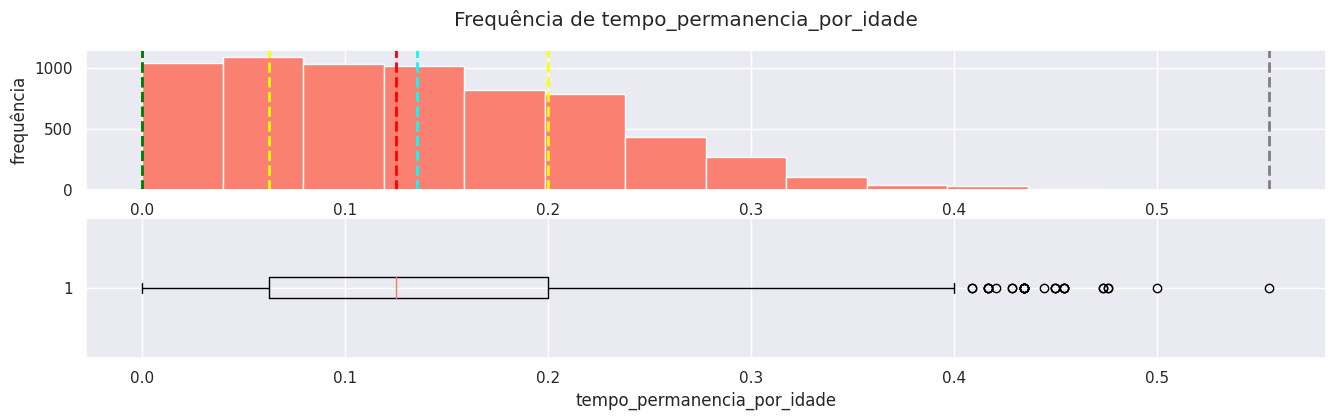

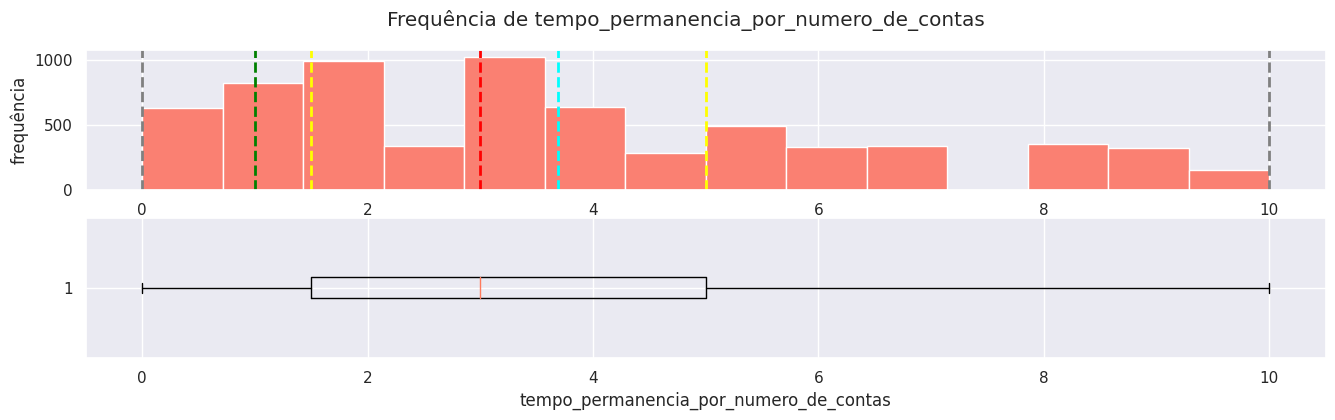

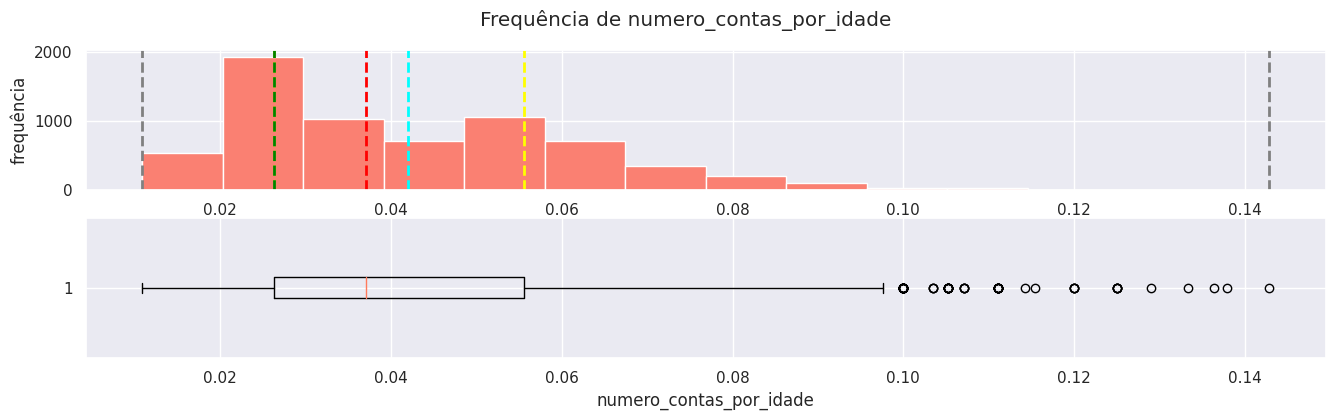

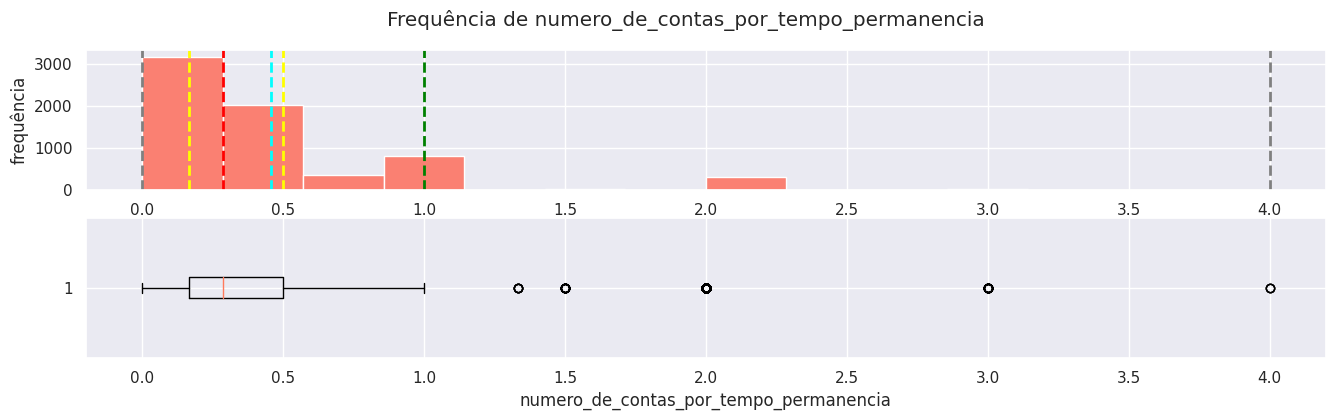

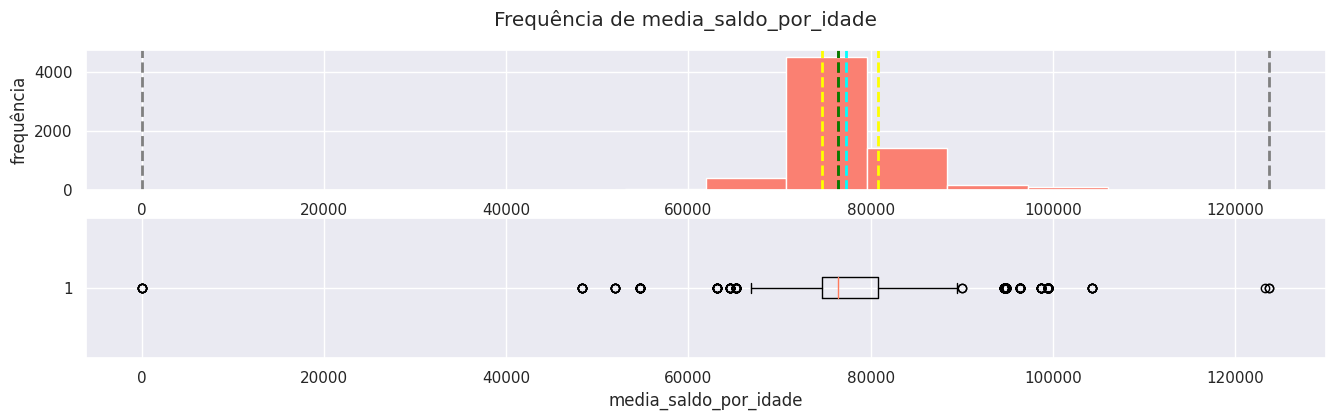

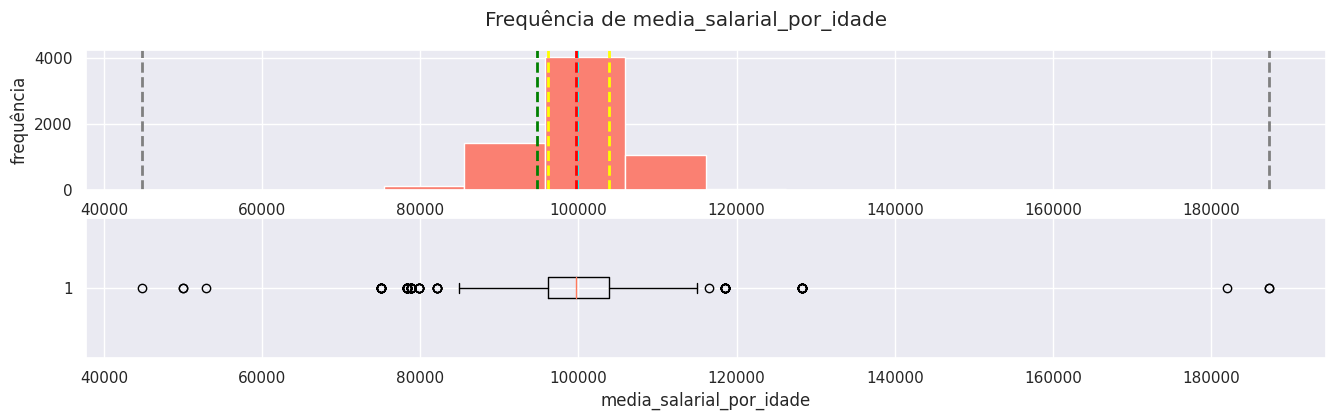

In [88]:
list_variables = ['saldo_por_salario',
       'saldo_por_score', 'saldo_por_numero_contas', 'saldo_por_idade',
       'salario_por_numero_de_contas', 'salario_por_score',
       'salario_x_tempo_permanencia', 'salario_por_idade',
       'score_credito_por_idade', 'score_credito_por_numero_de_contas',
       'tempo_permanencia_por_idade', 'tempo_permanencia_por_numero_de_contas',
       'numero_contas_por_idade', 'numero_de_contas_por_tempo_permanencia',
       'media_saldo_por_idade', 'media_salarial_por_idade']

plot_univariate_numeric_distributions(X_train, list_numerical_variables= list_variables)

#### Bivariate Analysis

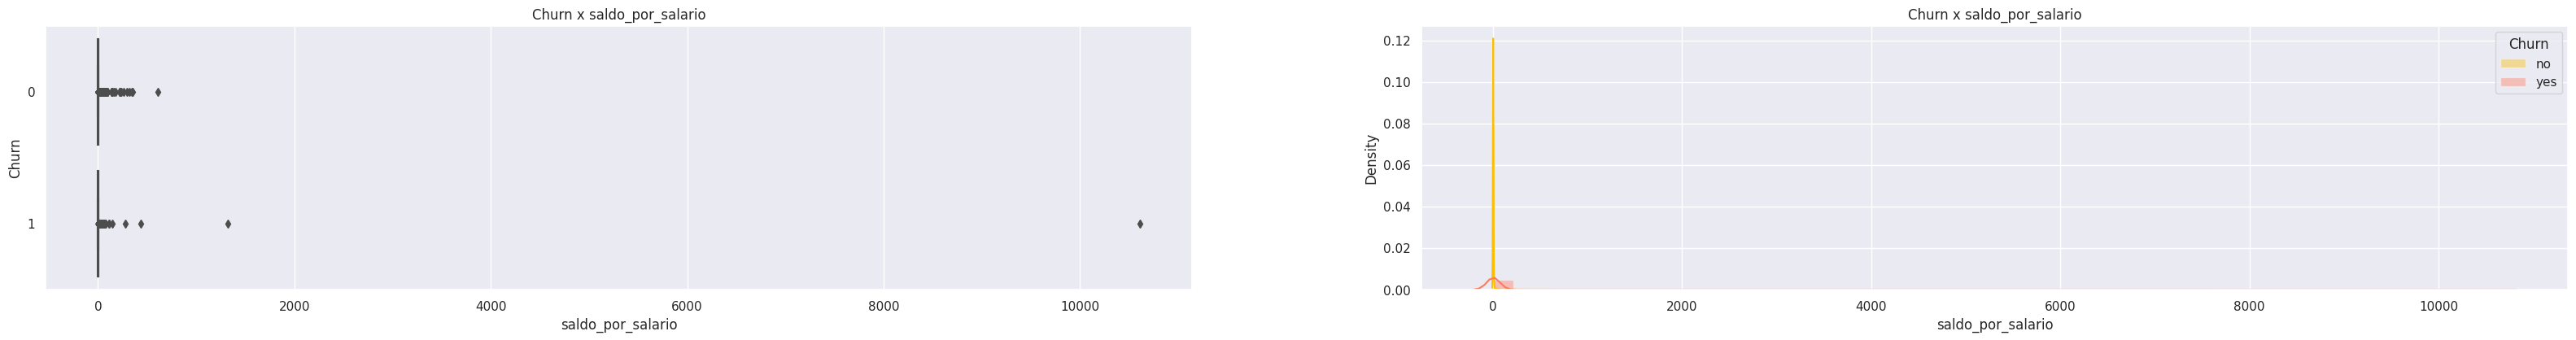

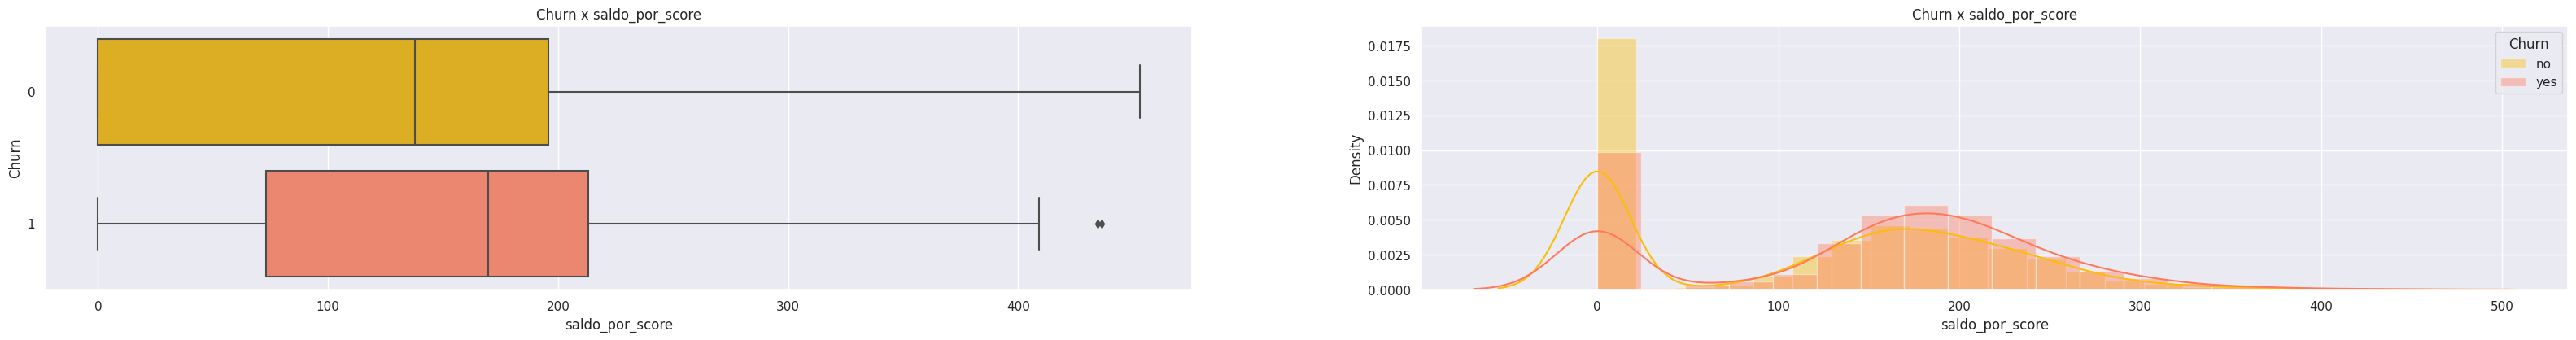

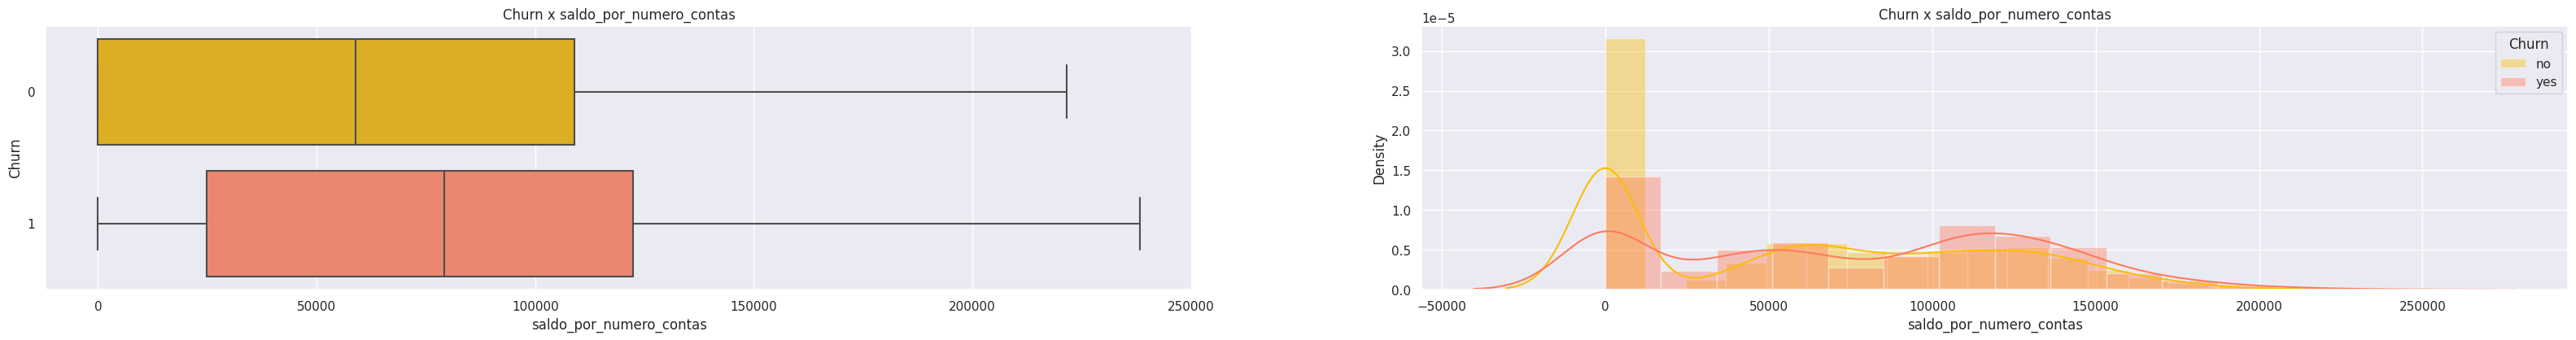

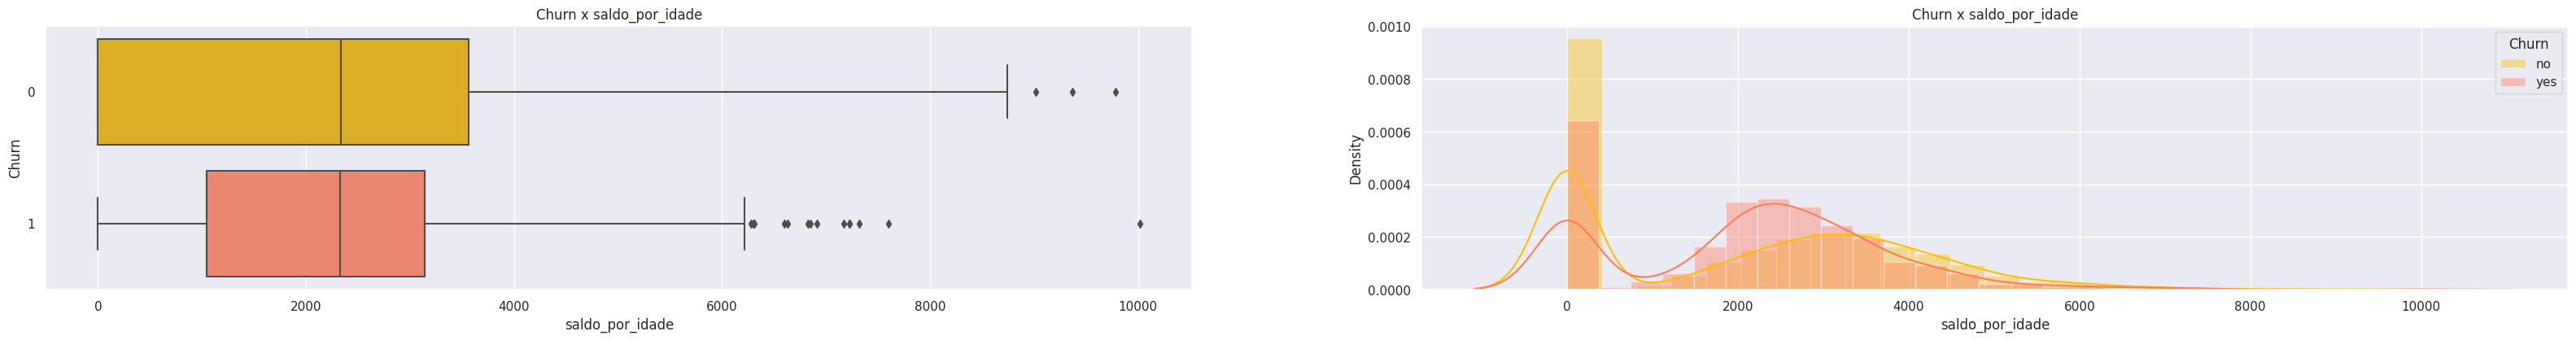

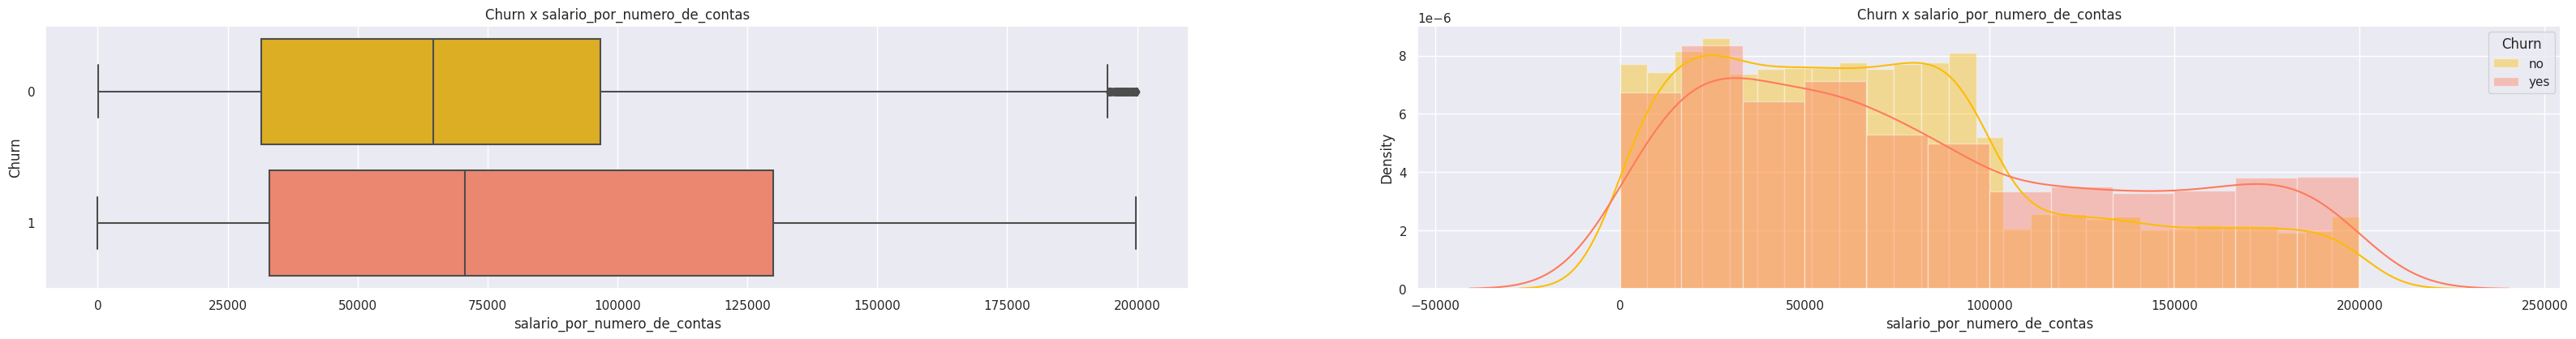

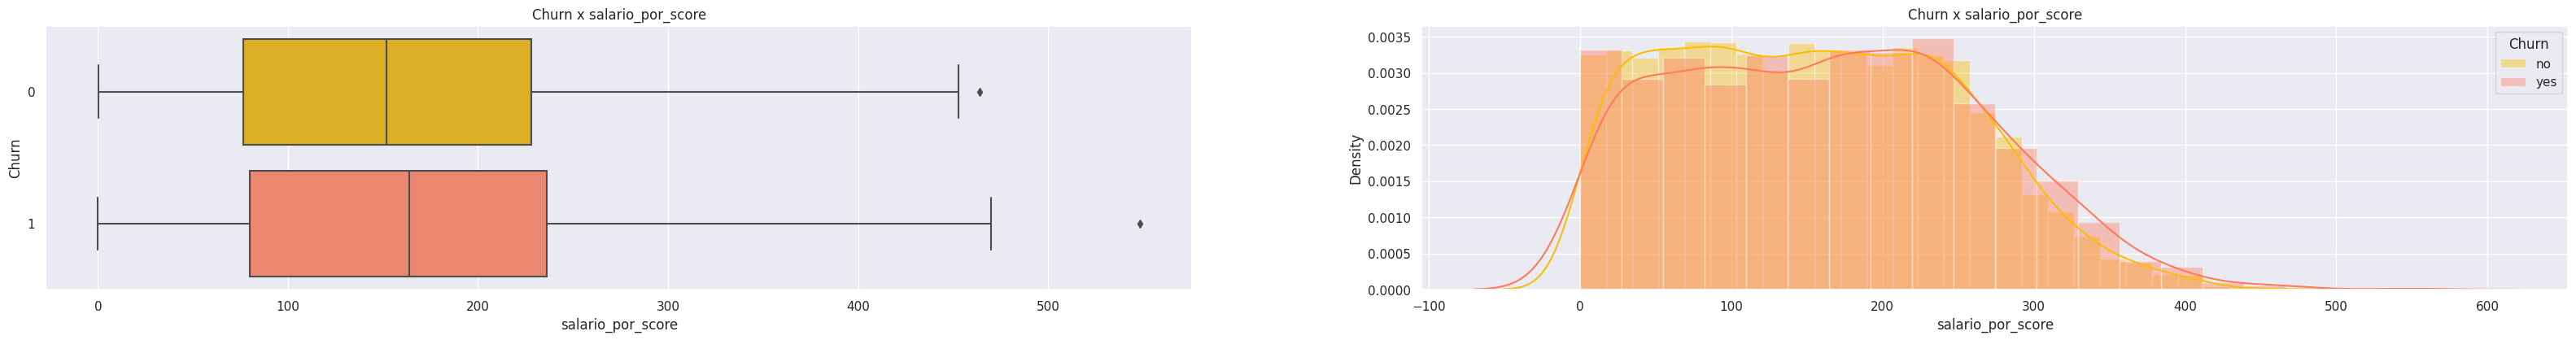

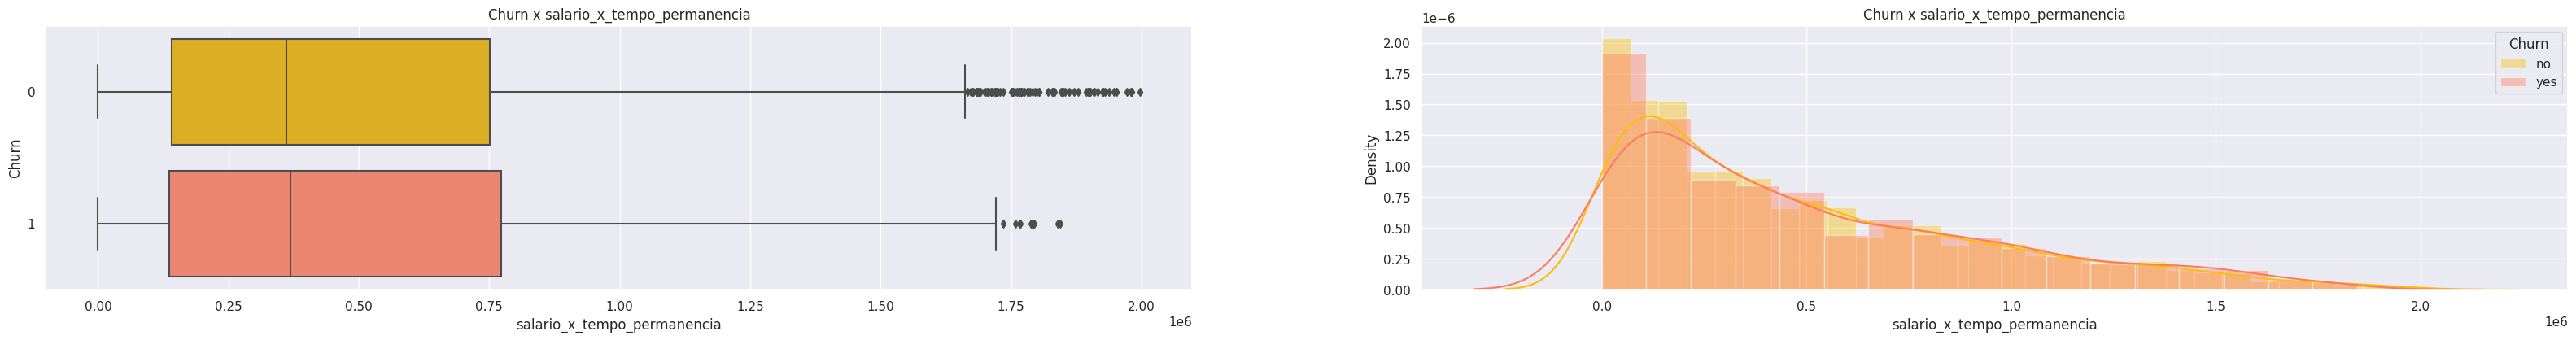

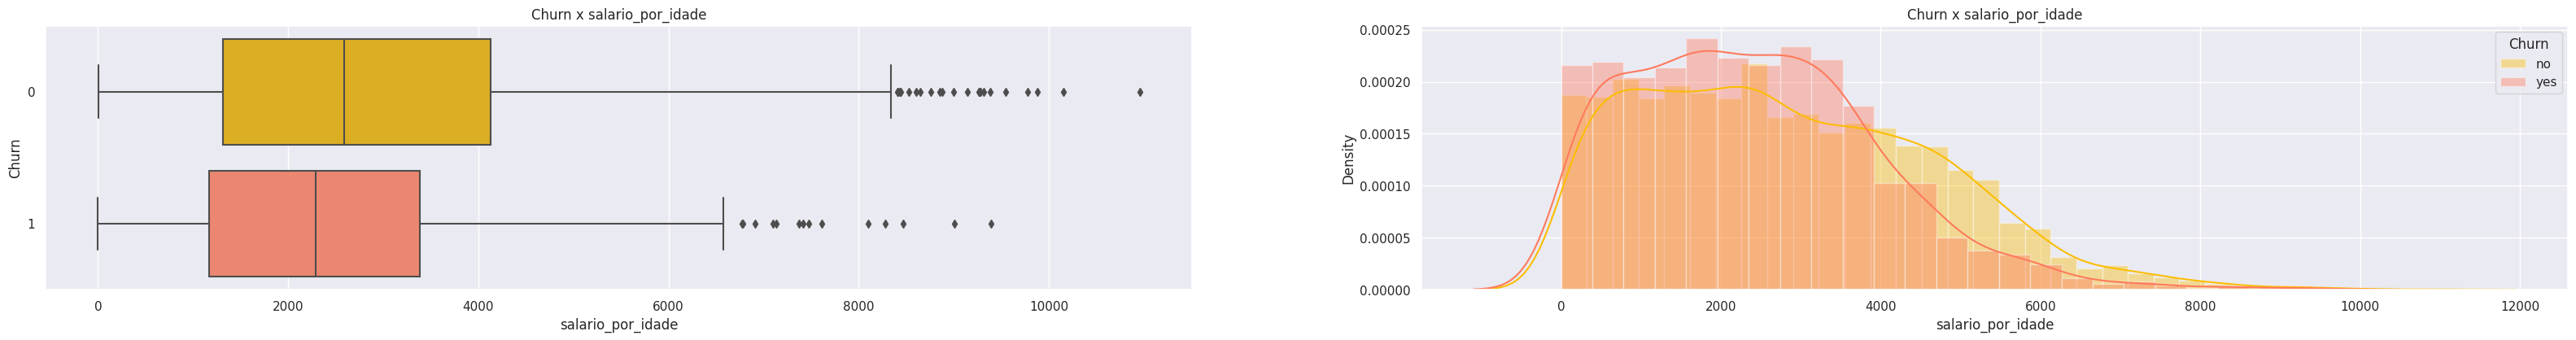

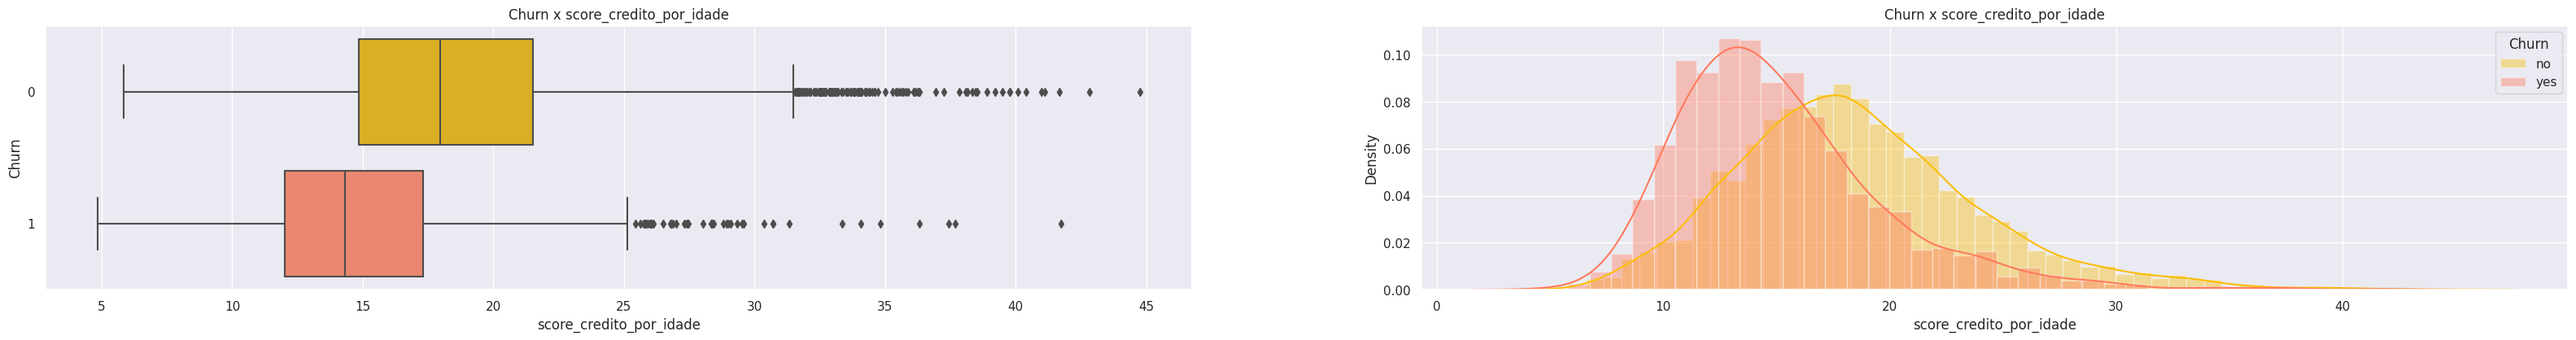

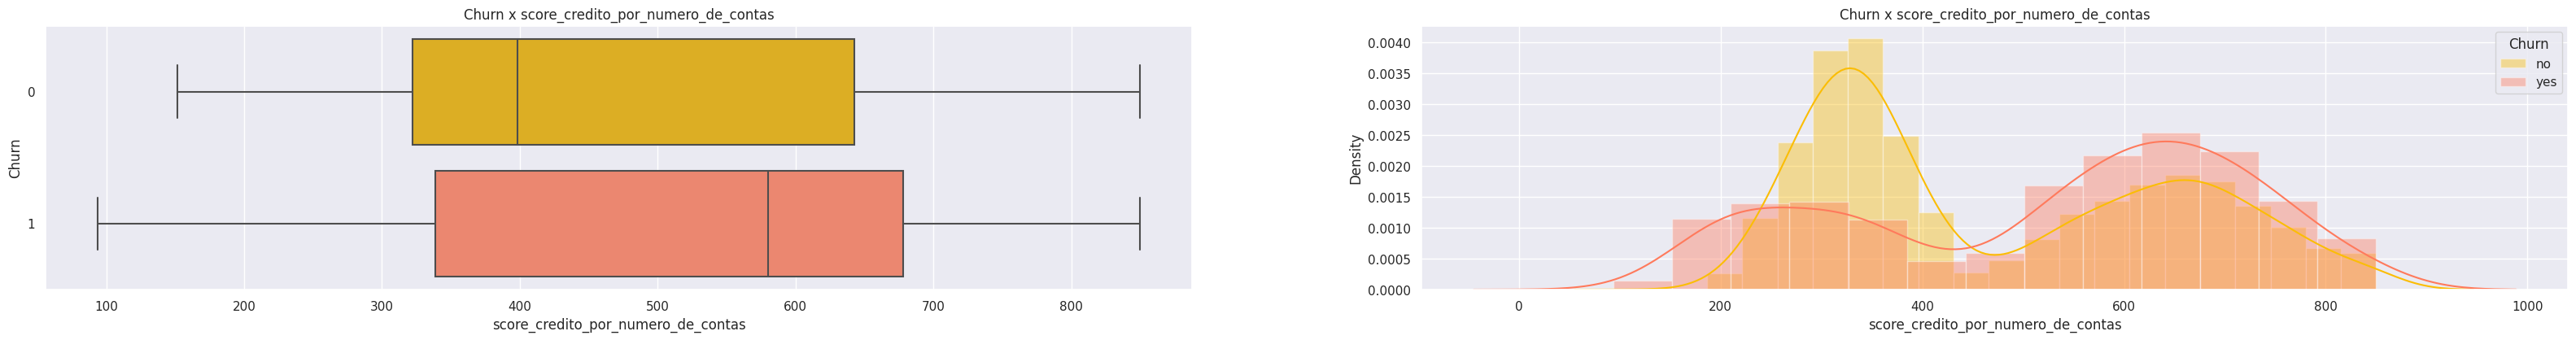

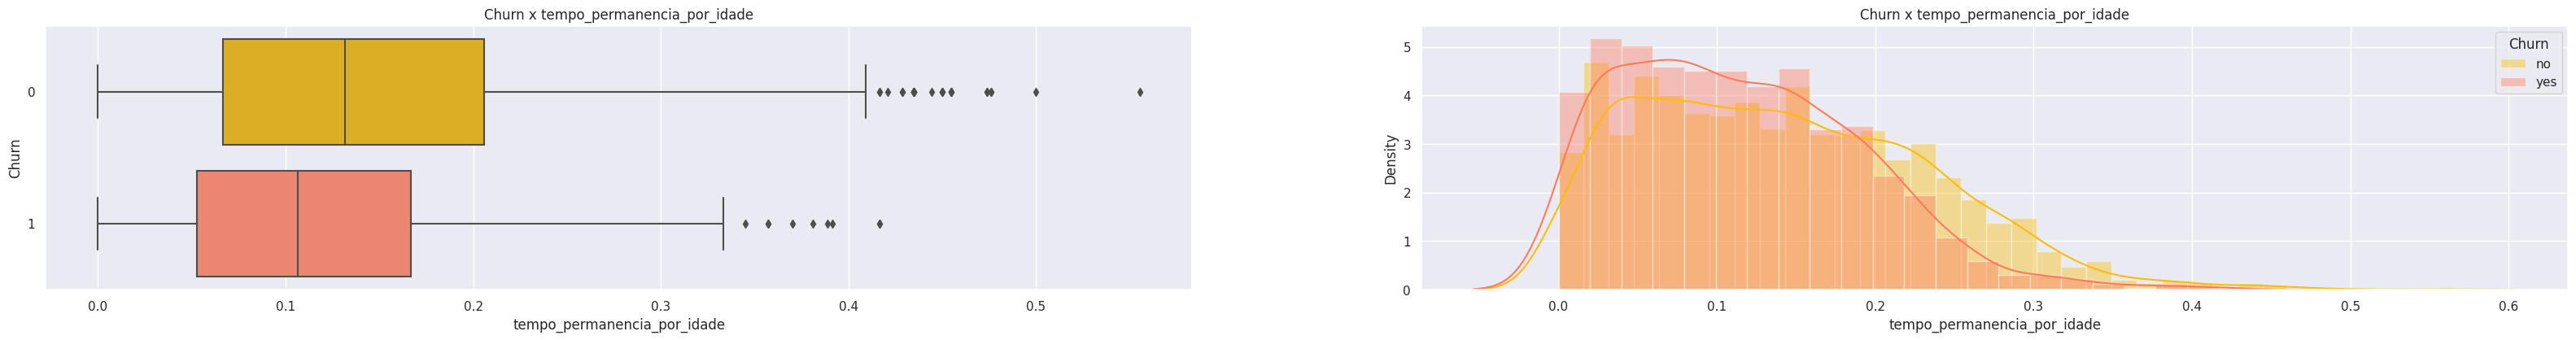

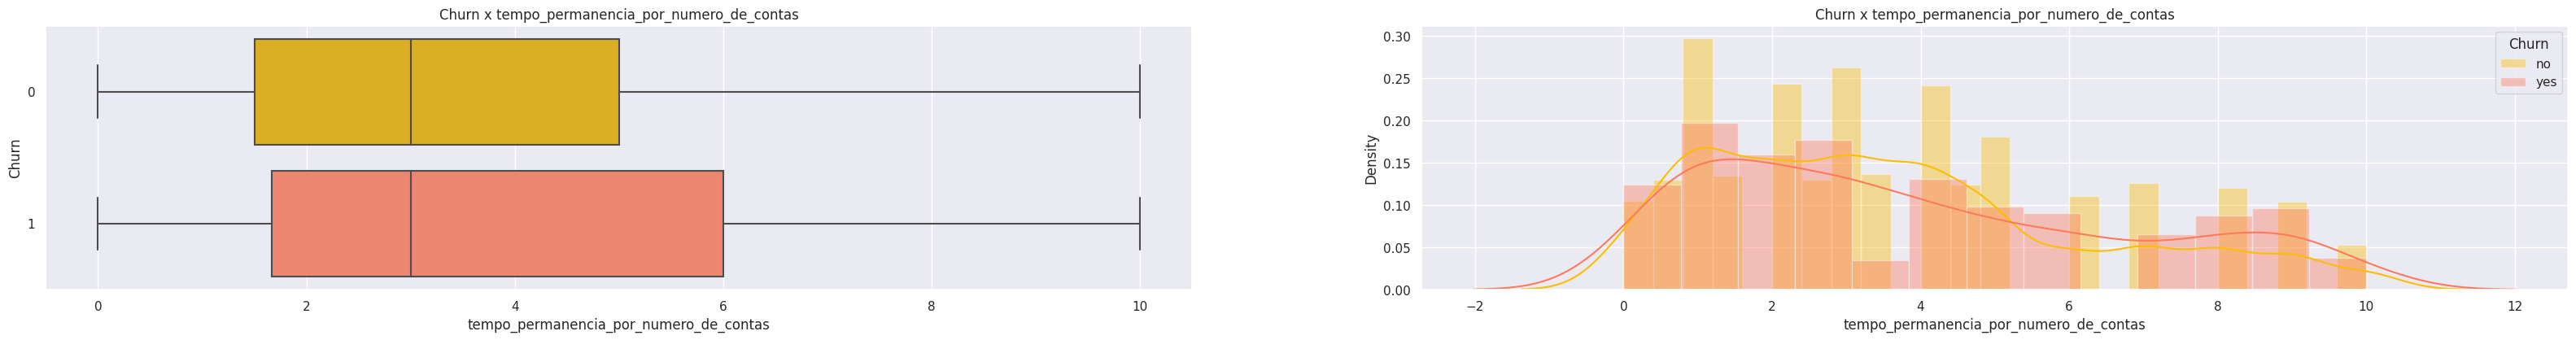

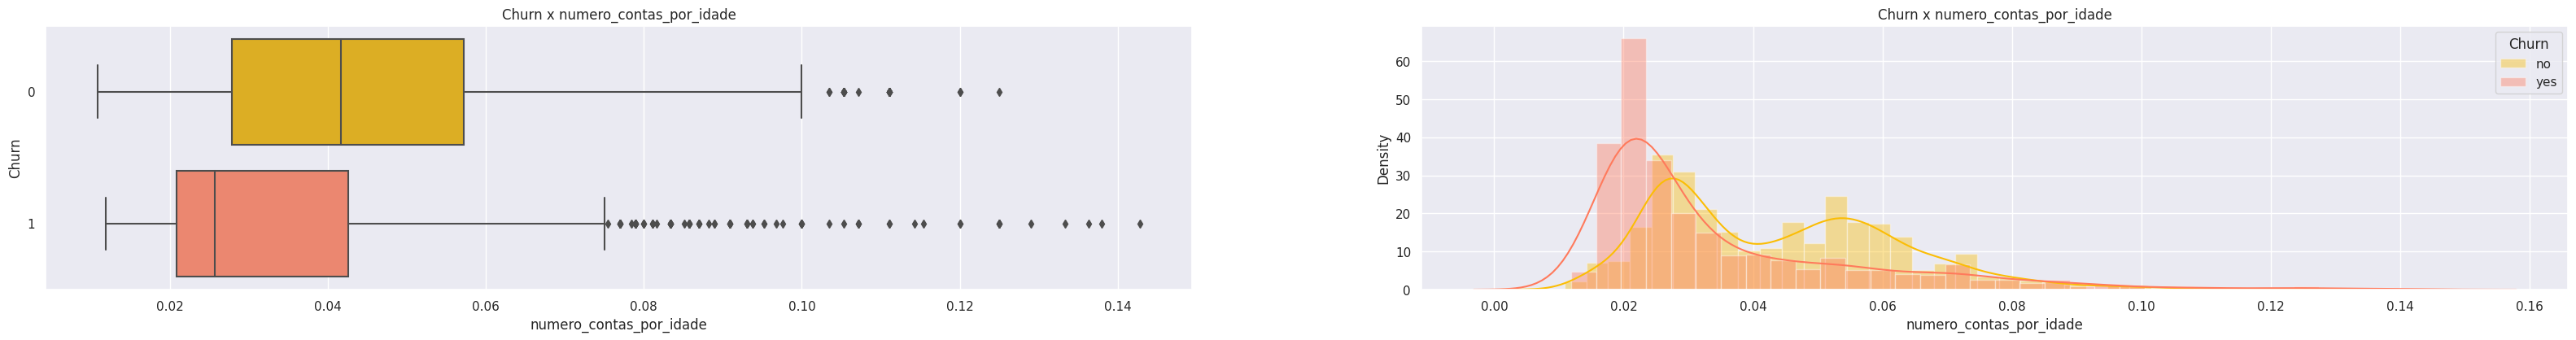

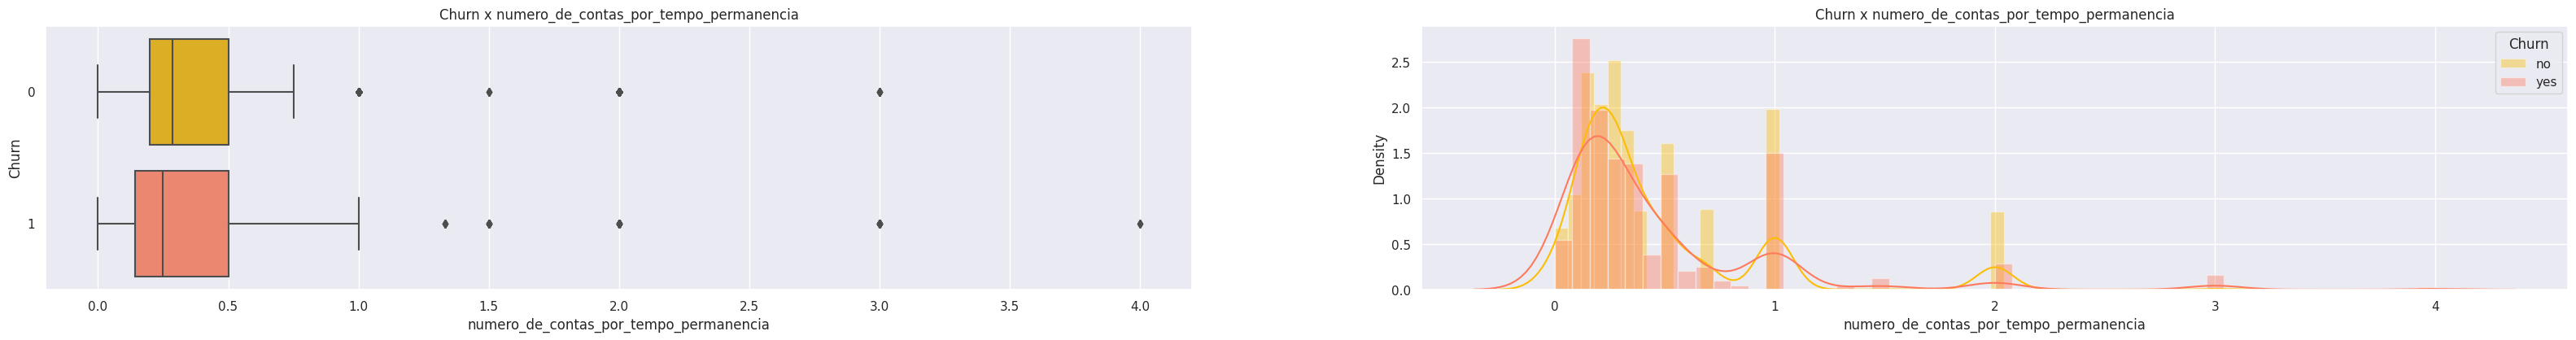

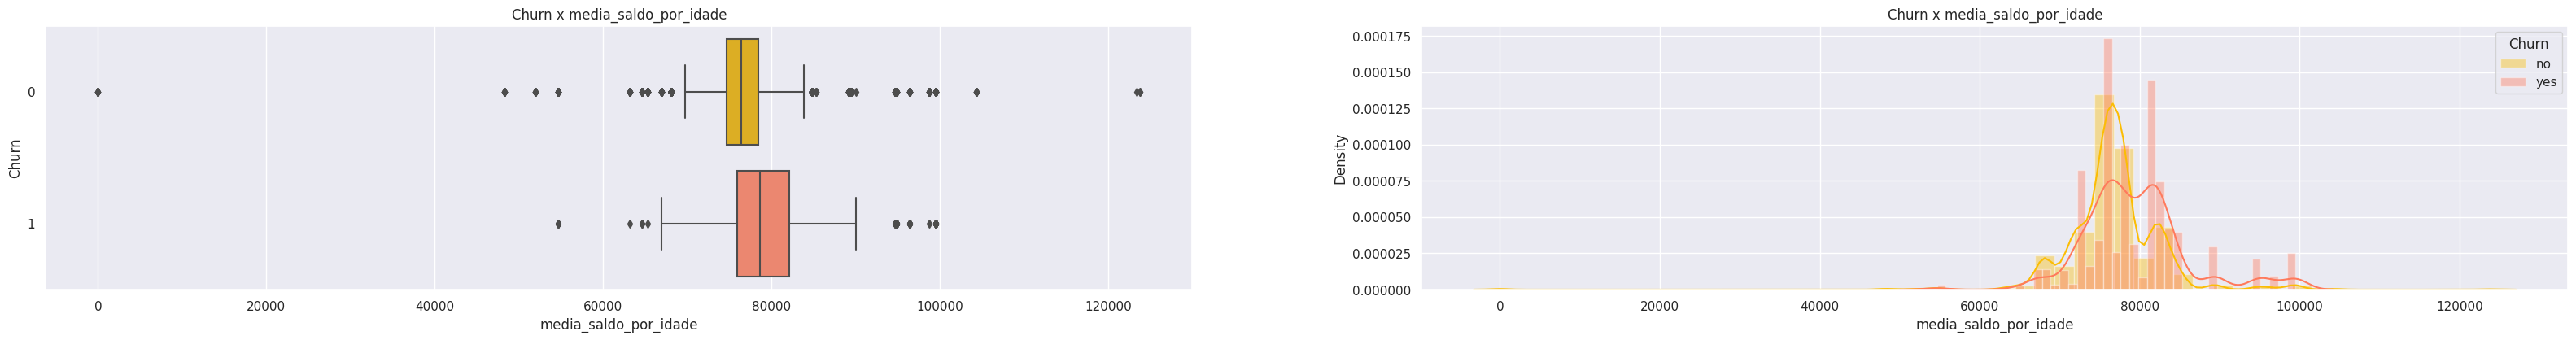

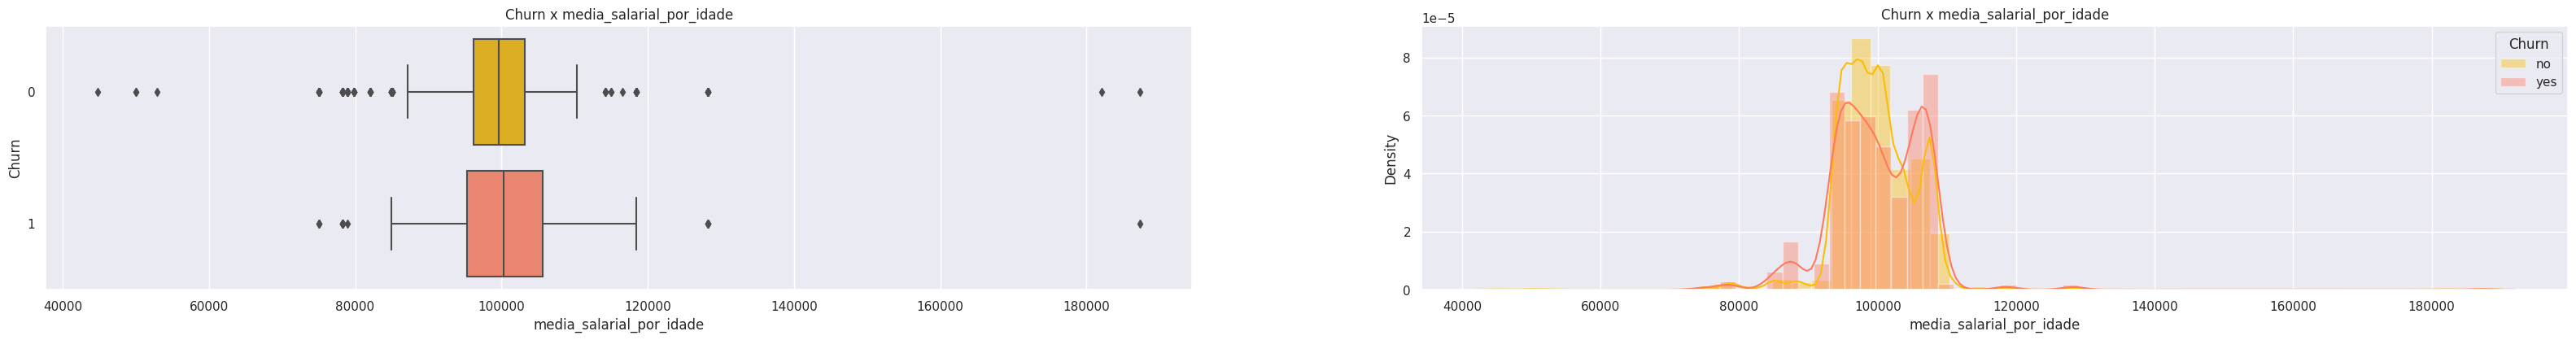

In [89]:
tuple_figsize = (40, 80)
plot_bivariate_numeric_distribuitions(X_train, list_variables, 'Churn', tuple_figsize= tuple_figsize)

#### Multivariate Analysis

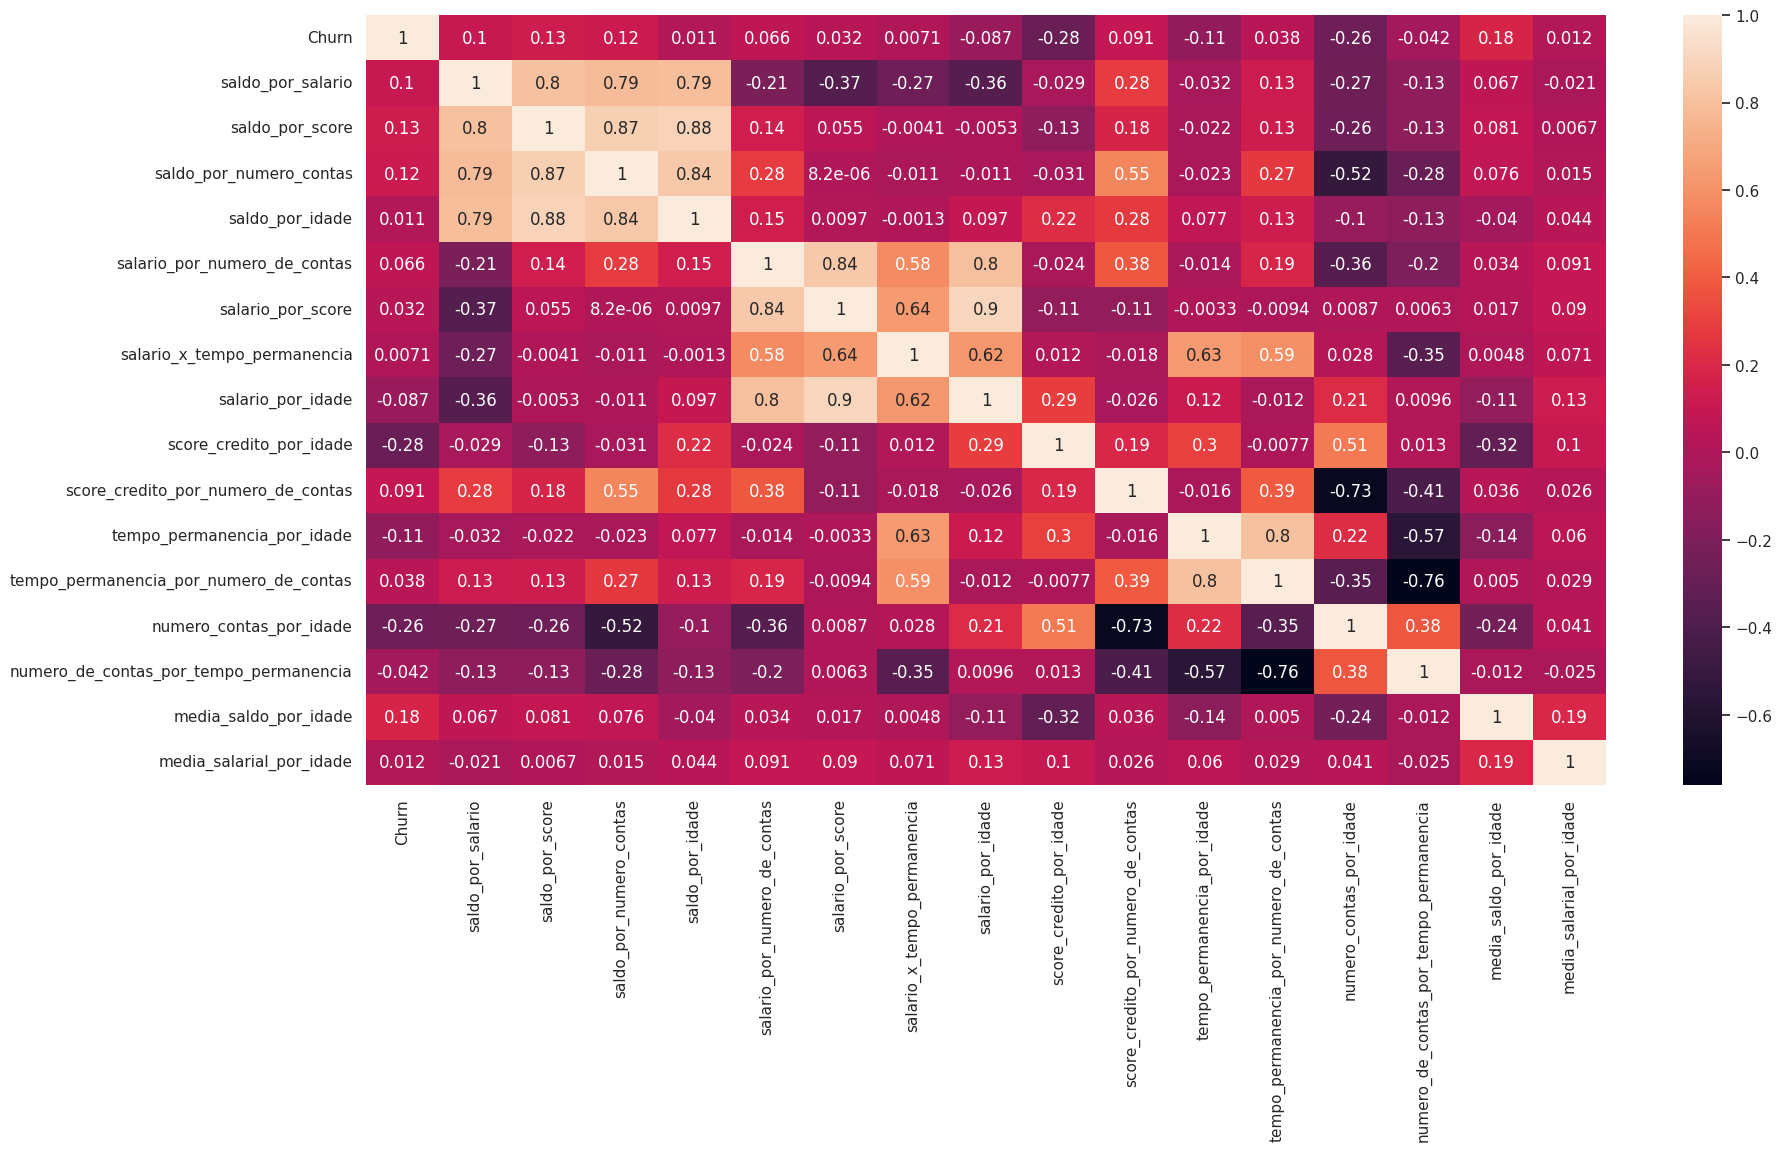

In [90]:
variables =  X_train.drop(columns= ['geografia', 'genero', 'tem_cartao_credito', 'membro_ativo', 'escala_fico', 'score_credito', 'idade', 'saldo', 'salario_estimado', 'tempo_permanencia', 'numero_de_contas'])
correlation = variables.corr(method= 'spearman')
plt.figure(figsize= (20, 10))
sns.heatmap(correlation, annot= True);

In [91]:
# Retirando variavel resposta dos dados de Teste
X_train.drop(columns= ['Churn'], inplace= True)
X_test.drop(columns= ['Churn'], inplace= True)

## Scaling I (Encoding)

### One Hot Encoding

In [92]:
one_hot_encoder = OneHotEncoder(sparse= False) #cria novas colunas com valores numéricos (1 ou 0) para substituir dados categóricos 

### *geografia e gênero*

In [93]:
df_train_encoded = pd.DataFrame(one_hot_encoder.fit_transform(X_train[['geografia', 'genero']]))
df_test_encoded = pd.DataFrame(one_hot_encoder.transform(X_test[['geografia', 'genero']]))

# Renomear as colunas codificadas
encoded_cols = one_hot_encoder.get_feature_names(['geografia', 'genero'])
df_train_encoded.columns = encoded_cols
df_test_encoded.columns = encoded_cols

# Concatenando colunas codificadas com dataframes de treino e teste
X_train = pd.concat([X_train, df_train_encoded], axis=1)
X_test = pd.concat([X_test, df_test_encoded], axis=1)

#Excluindo colunas "antigas"
X_train.drop(columns= ['geografia', 'genero'], inplace= True)
X_test.drop(columns= ['geografia', 'genero'], inplace= True)

### *tem_cartao_credito*

In [94]:
X_train['tem_cartao_credito'] = X_train['tem_cartao_credito'].apply(lambda x: 1 if x == 'yes' else 0)
X_test['tem_cartao_credito'] = X_test['tem_cartao_credito'].apply(lambda x: 1 if x == 'yes' else 0)

### *membro_ativo*

In [95]:
X_train['membro_ativo'] = X_train['membro_ativo'].apply(lambda x: 1 if x == 'yes' else 0)
X_test['membro_ativo'] = X_test['membro_ativo'].apply(lambda x: 1 if x == 'yes' else 0)

### Label Encoding

### *escala_fico*

In [96]:
escala_fico_dict = {'too bad': 0, 'bad': 1, 'good': 2, 'very good': 3, 'excellent': 4}
X_train['escala_fico'] = X_train['escala_fico'].apply(lambda x: escala_fico_dict[x])
X_test['escala_fico'] = X_test['escala_fico'].apply(lambda x: escala_fico_dict[x])

### Response Variable (Churn)

- O encoding da variável resposta foi feita no início da análise multivariada de variáveis numéricas

In [97]:
X_train.sample(5)

score_credito  idade  tempo_permanencia      saldo  numero_de_contas  tem_cartao_credito  membro_ativo  salario_estimado  escala_fico  saldo_por_salario  saldo_por_score  saldo_por_numero_contas  saldo_por_idade  salario_por_numero_de_contas  salario_por_score  salario_x_tempo_permanencia  salario_por_idade  score_credito_por_idade  score_credito_por_numero_de_contas  tempo_permanencia_por_idade  tempo_permanencia_por_numero_de_contas  numero_contas_por_idade  numero_de_contas_por_tempo_permanencia  media_saldo_por_idade  media_salarial_por_idade  geografia_France  geografia_Germany  geografia_Spain  genero_Female  genero_Male
1149            653     40                  0       0.00                 2                   1             0          35795.85            1           0.000000         0.000000                    0.000         0.000000                     17897.925          54.817534                         0.00         894.896250                16.325000                               326.5                     0.000000                                     0.0                 0.050000                                0.000000           78417.516195             107513.354545               1.0                0.0              0.0            1.0          0.0
4117            790     46                  8  182364.53                 1                   0             0         139266.48            3           1.309465       230.841177               182364.530      3964.446304                    139266.480         176.286684                   1114131.84        3027.532174                17.173913                               790.0                     0.173913                                     8.0                 0.021739                                0.125000           72952.702949              94244.243782               0.0                0.0              1.0            0.0          1.0
53              712     45                  6  112994.65                 1                   0             0         198398.68            2           0.569533       158.700351               112994.650      2510.992222                    198398.680         278.649831                   1190392.08        4408.859556                15.822222                               712.0                     0.133333                                     6.0                 0.022222                                0.166667           81365.372745             107924.568824               0.0                0.0              1.0            0.0          1.0
2632            632     44                  3  133793.89                 1                   1             1          34607.14            1           3.866078       211.699193               133793.890      3040.770227                     34607.140          54.758133                    103821.42         786.525909                14.363636                               632.0                     0.068182                                     3.0                 0.022727                                0.333333           78640.256500              96348.080813               1.0                0.0              0.0            1.0          0.0
6348            850     27                  7   43658.33                 2                   1             1           3025.49            4          14.430168        51.362741                21829.165      1616.975185                      1512.745           3.559400                     21178.43         112.055185                31.481481                               425.0                     0.259259                                     3.5                 0.074074                                0.285714           72403.467826             102290.630507               1.0                0.0              0.0            1.0          0.0

In [98]:
X_test.sample(5)

score_credito  idade  tempo_permanencia      saldo  numero_de_contas  tem_cartao_credito  membro_ativo  salario_estimado  escala_fico  saldo_por_salario  saldo_por_score  saldo_por_numero_contas  saldo_por_idade  salario_por_numero_de_contas  salario_por_score  salario_x_tempo_permanencia  salario_por_idade  score_credito_por_idade  score_credito_por_numero_de_contas  tempo_permanencia_por_idade  tempo_permanencia_por_numero_de_contas  numero_contas_por_idade  numero_de_contas_por_tempo_permanencia  media_saldo_por_idade  media_salarial_por_idade  geografia_France  geografia_Germany  geografia_Spain  genero_Female  genero_Male
3092            782     34                  9       0.00                 1                   1             0         183021.06            3           0.000000         0.000000                     0.00         0.000000                     183021.06         234.042276                   1647189.54        5382.972353                23.000000                               782.0                     0.264706                                     9.0                 0.029412                                0.111111           77740.612409             101513.882117               1.0                0.0              0.0            0.0          1.0
137             473     48                  8       0.00                 2                   1             0          71139.80            0           0.000000         0.000000                     0.00         0.000000                      35569.90         150.401268                    569118.40        1482.079167                 9.854167                               236.5                     0.166667                                     4.0                 0.041667                                0.250000           95517.346429             107074.991429               0.0                0.0              1.0            0.0          1.0
1608            434     71                  9  119496.87                 1                   1             0         125848.88            0           0.949527       275.338410                119496.87      1683.054507                     125848.88         289.974378                   1132639.92        1772.519437                 6.112676                               434.0                     0.126761                                     9.0                 0.014085                                0.111111           44389.342308             113293.426154               0.0                1.0              0.0            0.0          1.0
2465            615     44                  9  126104.98                 2                   0             1         110718.02            1           1.138974       205.048748                 63052.49      2866.022273                      55359.01         180.029301                    996462.18        2516.318636                13.977273                               307.5                     0.204545                                     4.5                 0.045455                                0.222222           77591.685258             101230.247629               0.0                1.0              0.0            1.0          0.0
3215            548     35                 10       0.00                 1                   1             1          31299.71            0           0.000000         0.000000                     0.00         0.000000                      31299.71          57.116259                    312997.10         894.277429                15.657143                               548.0                     0.285714                                    10.0                 0.028571                                0.100000           80015.104056              95850.763916               1.0                0.0              0.0            1.0          0.0

## Scaling II (Normalization) 

In [99]:
numeric_attributes_train_data = X_train.select_dtypes(include= ['int64', 'float64'])
numeric_attributes_train_data.drop(columns= ['escala_fico', 'tem_cartao_credito', 'membro_ativo'], inplace= True)
pd.options.display.max_rows = numeric_attributes_train_data.shape[1]

In [100]:
# Estatística descritiva de todo conjunto de dados antes da criação de novas features
numeric_descriptive_statistical(numeric_attributes)

Variáveis  Mínimo     Máximo      Range  Valores Únicos          Média     Mediana  Desv. Padrão  Assimetria   Curtose
0      score_credito  350.00     850.00     500.00           460.0     650.528800     652.000     96.648466   -0.071607 -0.425726
1              idade   18.00      92.00      74.00            70.0      38.921800      37.000     10.487282    1.011320  1.395347
2  tempo_permanencia    0.00      10.00      10.00            11.0       5.012800       5.000      2.892030    0.010991 -1.165225
3              saldo    0.00  250898.09  250898.09          6382.0   76485.889288   97198.540  62394.285254   -0.141109 -1.489412
4   numero_de_contas    1.00       4.00       3.00             4.0       1.530200       1.000      0.581625    0.745568  0.582981
5   salario_estimado   11.58  199992.48  199980.90          9999.0  100090.239881  100193.915  57507.617221    0.002085 -1.181518

In [101]:
# Estatística descritiva dos dados de treino depois da criação de novas features
numeric_descriptive_statistical(numeric_attributes_train_data)

Variáveis        Mínimo        Máximo         Range  Valores Únicos          Média        Mediana   Desv. Padrão  Assimetria      Curtose
0                            score_credito    350.000000  8.500000e+02  5.000000e+02           450.0     650.212687     651.000000      96.311610   -0.068427    -0.442532
1                                    idade     18.000000  9.200000e+01  7.400000e+01            69.0      39.037015      37.000000      10.501477    1.017166     1.424185
2                        tempo_permanencia      0.000000  1.000000e+01  1.000000e+01            11.0       4.941642       5.000000       2.884601    0.049998    -1.158703
3                                    saldo      0.000000  2.508981e+05  2.508981e+05          4301.0   77293.490045   97982.815000   62525.211297   -0.155284    -1.474930
4                         numero_de_contas      1.000000  4.000000e+00  3.000000e+00             4.0       1.530597       1.000000       0.581651    0.729806     0.484588
5                         salario_estimado     11.580000  1.999925e+05  1.999809e+05          6700.0   99781.280155   99675.470000   57619.618397    0.014316    -1.188065
6                        saldo_por_salario      0.000000  1.061466e+04  1.061466e+04          4303.0       4.512546       0.756829     131.643756   78.347874  6301.430727
7                          saldo_por_score      0.000000  4.530323e+02  4.530323e+02          4303.0     121.718703     146.685403     101.480458    0.032096    -1.207730
8                  saldo_por_numero_contas      0.000000  2.383876e+05  2.383876e+05          4302.0   63328.706108   61351.760000   56931.599700    0.276261    -1.206421
9                          saldo_por_idade      0.000000  1.002062e+04  1.002062e+04          4303.0    2103.269169    2331.281341    1842.497718    0.311557    -0.701302
10            salario_por_numero_de_contas     11.580000  1.999707e+05  1.999592e+05          6700.0   74458.236291   65646.402500   52087.787203    0.681858    -0.409720
11                       salario_por_score      0.016333  5.484957e+02  5.484794e+02          6700.0     157.186863     154.403429      95.180474    0.261589    -0.718270
12             salario_x_tempo_permanencia      0.000000  1.997757e+06  1.997757e+06          6424.0  492770.208045  362851.965000  438194.980518    1.013225     0.286498
13                       salario_por_idade      0.257333  1.096234e+04  1.096208e+04          6700.0    2737.413449    2511.551431    1789.185433    0.596759    -0.019165
14                 score_credito_por_idade      4.857143  4.477778e+01  3.992063e+01          4671.0      17.811751      17.236068       5.357996    0.757546     0.947961
15      score_credito_por_numero_de_contas     94.000000  8.500000e+02  7.560000e+02           982.0     485.966828     443.000000     183.272616    0.222473    -1.317499
16             tempo_permanencia_por_idade      0.000000  5.555556e-01  5.555556e-01           397.0       0.135568       0.125000       0.088689    0.582292    -0.034843
17  tempo_permanencia_por_numero_de_contas      0.000000  1.000000e+01  1.000000e+01            28.0       3.689167       3.000000       2.613452    0.698278    -0.393439
18                 numero_contas_por_idade      0.010870  1.428571e-01  1.319876e-01           154.0       0.042018       0.037037       0.019469    0.862666     0.559679
19  numero_de_contas_por_tempo_permanencia      0.000000  4.000000e+00  4.000000e+00            28.0       0.458143       0.285714       0.474891    2.387262     6.871219
20                   media_saldo_por_idade      0.000000  1.237948e+05  1.237948e+05            65.0   77293.490045   76429.267761    6245.366642   -0.994136    24.593815
21                media_salarial_por_idade  44827.470000  1.873602e+05  1.425328e+05            69.0   99781.280155   99645.824047    6041.014437    0.788592    22.444475
22                        geografia_France      0.000000  1.000000e+00  1.000000e+00             2.0

### Normalization (or Rescaling)

In [102]:
min_max_scaler = MinMaxScaler() #rescala para variáveis numéricas com distribuições que não possuem outliers 
standart_scaler = StandardScaler()
robust_scaler = RobustScaler() #rescala para variáveis numéricas com distribuições que possuem outliers 


# Neste ciclo, meu critério de normalização é a análise exploratória e valor de curtose:
    # valores < - 0.3, considero baixa presença outlier => min_max_scaler (score_credito, tempo_permanencia, saldo,  salario_estimado, 'saldo_por_score', 'saldo_por_numero_contas', 'saldo_por_idade', 'salario_por_idade', 'salario_por_numero_de_contas', 'salario_por_score', 'score_credito_por_numero_de_contas', 'tempo_permanencia_por_numero_de_contas')
    # -0.3 < valores < 0.5, considero presença razoável de outliers => standart_scaler (salario_x_tempo_permanencia)
    # valores > 0.5, considero presença significativa de outliers => robust_scaler (idade, saldo_por_salario, salario_por_idade, score_credito_por_idade, tempo_permanencia_por_idade, numero_contas_por_idade, numero_de_contas_por_tempo_permanencia, media_saldo_por_idade, media_salarial_por_idade)

#### *score_credito*

In [103]:
X_train['score_credito'] = min_max_scaler.fit_transform(X_train[['score_credito']].values)
X_test['score_credito'] = min_max_scaler.transform(X_test[['score_credito']].values)

#### *tempo_permanencia*

In [104]:
X_train['tempo_permanencia'] = min_max_scaler.fit_transform(X_train[['tempo_permanencia']].values)
X_test['tempo_permanencia'] = min_max_scaler.transform(X_test[['tempo_permanencia']].values)

#### *saldo*

In [105]:
X_train['saldo'] = min_max_scaler.fit_transform(X_train[['saldo']].values)
X_test['saldo'] = min_max_scaler.transform(X_test[['saldo']].values)

#### *salario_estimado*

In [106]:
X_train['salario_estimado'] = min_max_scaler.fit_transform(X_train[['salario_estimado']].values)
X_test['salario_estimado'] = min_max_scaler.transform(X_test[['salario_estimado']].values)

#### *saldo_por_score*

In [107]:
X_train['saldo_por_score'] = min_max_scaler.fit_transform(X_train[['saldo_por_score']].values)
X_test['saldo_por_score'] = min_max_scaler.transform(X_test[['saldo_por_score']].values)

#### *saldo_por_numero_contas*

In [108]:
X_train['saldo_por_numero_contas'] = min_max_scaler.fit_transform(X_train[['saldo_por_numero_contas']].values)
X_test['saldo_por_numero_contas'] = min_max_scaler.transform(X_test[['saldo_por_numero_contas']].values)

#### *saldo_por_idade*

In [109]:
X_train['saldo_por_idade'] = min_max_scaler.fit_transform(X_train[['saldo_por_idade']].values)
X_test['saldo_por_idade'] = min_max_scaler.transform(X_test[['saldo_por_idade']].values)

#### *salario_por_idade*

In [110]:
X_train['salario_por_idade'] = min_max_scaler.fit_transform(X_train[['salario_por_idade']].values)
X_test['salario_por_idade'] = min_max_scaler.transform(X_test[['salario_por_idade']].values)

#### *salario_por_numero_de_contas*

In [111]:
X_train['salario_por_numero_de_contas'] = min_max_scaler.fit_transform(X_train[['salario_por_numero_de_contas']].values)
X_test['salario_por_numero_de_contas'] = min_max_scaler.transform(X_test[['salario_por_numero_de_contas']].values)

#### *salario_por_score*

In [112]:
X_train['salario_por_score'] = min_max_scaler.fit_transform(X_train[['salario_por_score']].values)
X_test['salario_por_score'] = min_max_scaler.transform(X_test[['salario_por_score']].values)

#### *score_credito_por_numero_de_contas* 

In [113]:
X_train['score_credito_por_numero_de_contas'] = min_max_scaler.fit_transform(X_train[['score_credito_por_numero_de_contas']].values)
X_test['score_credito_por_numero_de_contas'] = min_max_scaler.transform(X_test[['score_credito_por_numero_de_contas']].values)

#### *tempo_permanencia_por_numero_de_contas*

In [114]:
X_train['tempo_permanencia_por_numero_de_contas'] = min_max_scaler.fit_transform(X_train[['tempo_permanencia_por_numero_de_contas']].values)
X_test['tempo_permanencia_por_numero_de_contas'] = min_max_scaler.transform(X_test[['tempo_permanencia_por_numero_de_contas']].values)

#### salario_x_tempo_permanencia

In [115]:
X_train['salario_x_tempo_permanencia'] = standart_scaler.fit_transform(X_train[['salario_x_tempo_permanencia']].values)
X_test['salario_x_tempo_permanencia'] = standart_scaler.transform(X_test[['salario_x_tempo_permanencia']].values)

#### *idade*

In [116]:
X_train['idade'] = robust_scaler.fit_transform(X_train[['idade']].values)
X_test['idade'] = robust_scaler.transform(X_test[['idade']].values)

#### *saldo_por_salario*

In [117]:
X_train['saldo_por_salario'] = robust_scaler.fit_transform(X_train[['saldo_por_salario']].values)
X_test['saldo_por_salario'] = robust_scaler.transform(X_test[['saldo_por_salario']].values)

#### salario_por_idade

In [118]:
X_train['salario_por_idade'] = robust_scaler.fit_transform(X_train[['salario_por_idade']].values)
X_test['salario_por_idade'] = robust_scaler.transform(X_test[['salario_por_idade']].values)

#### *score_credito_por_idade*

In [119]:
X_train['score_credito_por_idade'] = robust_scaler.fit_transform(X_train[['score_credito_por_idade']].values)
X_test['score_credito_por_idade'] = robust_scaler.transform(X_test[['score_credito_por_idade']].values)

#### *tempo_permanencia_por_idade*

In [120]:
X_train['tempo_permanencia_por_idade'] = robust_scaler.fit_transform(X_train[['tempo_permanencia_por_idade']].values)
X_test['tempo_permanencia_por_idade'] = robust_scaler.transform(X_test[['tempo_permanencia_por_idade']].values)

#### *numero_contas_por_idade*

In [121]:
X_train['numero_contas_por_idade'] = robust_scaler.fit_transform(X_train[['numero_contas_por_idade']].values)
X_test['numero_contas_por_idade'] = robust_scaler.transform(X_test[['numero_contas_por_idade']].values)

#### *numero_de_contas_por_tempo_permanencia*

In [122]:
X_train['numero_de_contas_por_tempo_permanencia'] = robust_scaler.fit_transform(X_train[['numero_de_contas_por_tempo_permanencia']].values)
X_test['numero_de_contas_por_tempo_permanencia'] = robust_scaler.transform(X_test[['numero_de_contas_por_tempo_permanencia']].values)

#### *media_saldo_por_idade*

In [123]:
X_train['media_saldo_por_idade'] = robust_scaler.fit_transform(X_train[['media_saldo_por_idade']].values)
X_test['media_saldo_por_idade'] = robust_scaler.transform(X_test[['media_saldo_por_idade']].values)

#### *media_salarial_por_idade*

In [124]:
X_train['media_salarial_por_idade'] = robust_scaler.fit_transform(X_train[['media_salarial_por_idade']].values)
X_test['media_salarial_por_idade'] = robust_scaler.transform(X_test[['media_salarial_por_idade']].values)

In [125]:
X_train.sample(5)

score_credito     idade  tempo_permanencia     saldo  numero_de_contas  tem_cartao_credito  membro_ativo  salario_estimado  escala_fico  saldo_por_salario  saldo_por_score  saldo_por_numero_contas  saldo_por_idade  salario_por_numero_de_contas  salario_por_score  salario_x_tempo_permanencia  salario_por_idade  score_credito_por_idade  score_credito_por_numero_de_contas  tempo_permanencia_por_idade  tempo_permanencia_por_numero_de_contas  numero_contas_por_idade  numero_de_contas_por_tempo_permanencia  media_saldo_por_idade  media_salarial_por_idade  geografia_France  geografia_Germany  geografia_Spain  genero_Female  genero_Male
6268          0.480 -0.250000                0.6  0.000000                 2                   1             0          0.855131            1          -0.486153         0.000000                 0.000000         0.000000                      0.427583           0.528462                     1.217171           0.934370                 0.017161                            0.265873                     0.374332                                    0.30                 0.745098                                0.142857              -1.353554                  0.107225               0.0                0.0              1.0            1.0          0.0
381           0.508 -0.833333                0.9  0.403960                 1                   0             0          0.151218            1           1.665895         0.370399                 0.425160         0.374608                      0.151234           0.091289                    -0.503200          -0.516102                 0.753885                            0.674603                     1.515152                                    0.90                 0.000000                               -0.523810              -0.654205                  0.344039               0.0                0.0              1.0            0.0          1.0
4053          0.592 -0.083333                0.6  0.577020                 2                   1             0          0.266054            1           1.261319         0.494683                 0.303651         0.401320                      0.133013           0.150167                    -0.395866          -0.383356                 0.104013                            0.302910                     0.303030                                    0.30                 0.633333                                0.142857              -0.292742                 -0.572902               0.0                1.0              0.0            1.0          0.0
5089          0.694  0.833333                0.6  0.511174                 1                   1             1          0.840289            2           0.004070         0.406167                 0.538001         0.272316                      0.840381           0.439567                     1.176531           0.394768                -0.353322                            0.797619                     0.019342                                    0.60                -0.539007                               -0.357143               0.737856                  0.768735               1.0                0.0              0.0            1.0          0.0
5442          0.728 -0.666667                0.9  0.000000                 2                   1             0          0.645967            2          -0.486153         0.000000                 0.000000         0.000000                      0.322989           0.329868                     1.528915           0.720996                 1.084307                            0.347884                     1.347962                                    0.45                 1.091954                               -0.190476              -0.907474                  0.458454               0.0                0.0              1.0            0.0          1.0

In [126]:
X_test.sample(5)

score_credito     idade  tempo_permanencia     saldo  numero_de_contas  tem_cartao_credito  membro_ativo  salario_estimado  escala_fico  saldo_por_salario  saldo_por_score  saldo_por_numero_contas  saldo_por_idade  salario_por_numero_de_contas  salario_por_score  salario_x_tempo_permanencia  salario_por_idade  score_credito_por_idade  score_credito_por_numero_de_contas  tempo_permanencia_por_idade  tempo_permanencia_por_numero_de_contas  numero_contas_por_idade  numero_de_contas_por_tempo_permanencia  media_saldo_por_idade  media_salarial_por_idade  geografia_France  geografia_Germany  geografia_Spain  genero_Female  genero_Male
2918          0.748  0.000000                0.6  0.500161                 1                   1             0          0.592851            2           0.193685         0.382595                 0.526409         0.338463                      0.592916           0.298562                     0.498986           0.257127                 0.342341                            0.833333                     0.270270                                     0.6                -0.342342                               -0.357143              -0.370358                 -0.099193               0.0                1.0              0.0            0.0          1.0
102           0.390  0.833333                0.8  0.421655                 1                   0             1          0.339125            0           0.515706         0.428479                 0.443784         0.224627                      0.339162           0.226887                     0.113811          -0.396364                -0.828186                            0.596561                     0.328820                                     0.8                -0.539007                               -0.482143               0.947196                  0.411828               1.0                0.0              0.0            0.0          1.0
988           0.740  0.583333                0.3  0.343176                 1                   1             0          0.900703            2          -0.179115         0.263969                 0.361186         0.195284                      0.900800           0.456117                     0.108706           0.587085                -0.128102                            0.828042                    -0.413223                                     0.3                -0.489394                                0.142857               0.188896                  0.206103               1.0                0.0              0.0            0.0          1.0
360           0.458  0.666667                0.2  0.000000                 2                   0             0          0.057520            0          -0.486153         0.000000                 0.000000         0.000000                      0.028734           0.036228                    -1.071992          -0.836865                -0.641573                            0.258598                    -0.585859                                     0.1                 0.253333                                2.142857               0.051418                  1.355254               1.0                0.0              0.0            1.0          0.0
1954          0.654  0.000000                0.3  0.352187                 1                   0             1          0.589730            2          -0.004913         0.288106                 0.370670         0.238328                      0.589794           0.317610                    -0.317054           0.250868                 0.155824                            0.771164                    -0.319410                                     0.3                -0.342342                                0.142857              -0.370358                 -0.099193               1.0                0.0              0.0            0.0          1.0

## Balancing Response Variable *only Train Data

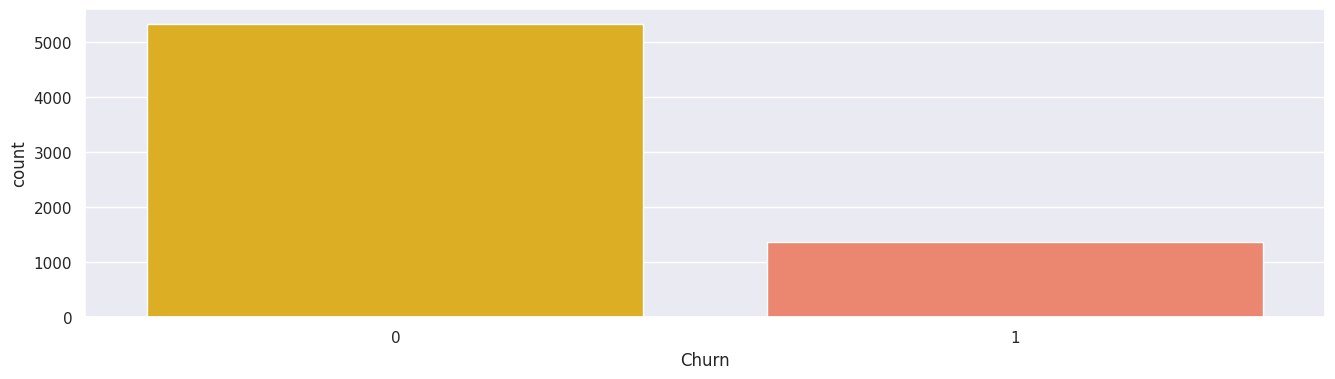

In [127]:
# Visualizando proporção da variável resposta
sns.countplot(x= y_train);

- Como a variável resposta está desbalanceada, aplico uma técnica (algoritmo) que irá balancear os dados e evitar enviesamento do modelo.

In [128]:
# Over-Sampling Sintético
smote = SMOTE()

# Over-Sampling Sintético Adaptativo
adasyn = ADASYN()

# Over-sampling Under-sampling combination
smoteenn = SMOTEENN()

X_train_balanced, y_train_balanced = smoteenn.fit_resample(X_train, y_train)

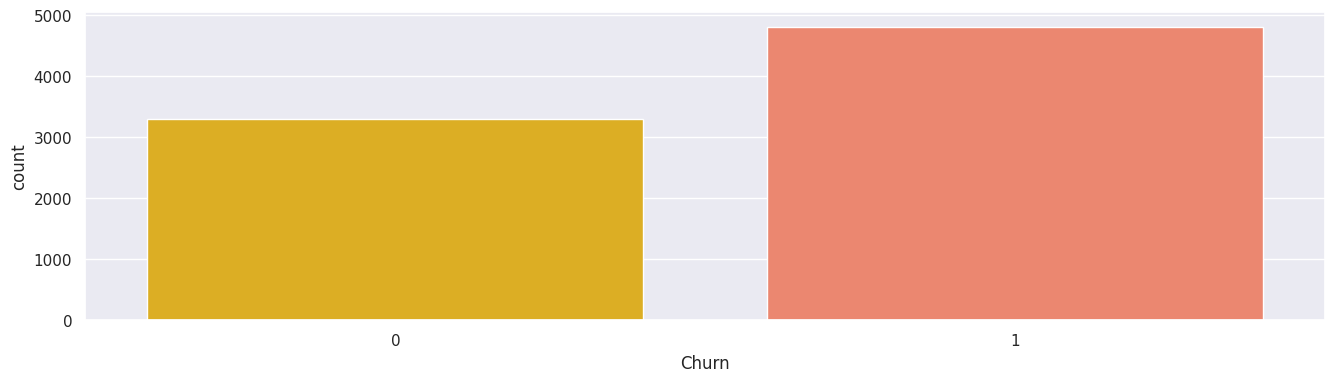

In [129]:
# Visualizando proporção da variável resposta
sns.countplot(x= y_train_balanced);

## Note:

Observações:

- Ao escalar os dados usa-se métricas que são definidas por todo o conjunto de dados, então decidi dividir os dados de treino e teste antes de escalar, pois assim, eu teria dois conjuntos de dados, com métricas únicas para cada conjunto, anulando o enviesamento do modelo. 
		Ex.: A normalização MinMaxScaler utiliza o valor mínimo e máximo do conjunto de dados. Se a normalização tivesse sido feita antes da divisão dos dados em conjuntos de treino e teste, a normalização dos dois conjuntos teriam o mesmo padrão escalar, de um único conjunto, pois iriam dividir os elementos mínimos e máximo, logo estaria injetando informações futuras no conjunto de dados de treinamneto, e assim, enviesando o modelo. Com normalização realizada depois da divisão dos dados em treino e teste, os valores mínimo e máximo seriam únicos para cada conjunto, assim, isolando os dados de treino com os dados de teste, evitando o enviesamento do modelo.
        
- Como as novas features foram criadas a partir de divisões diretamenete associadas a elementos de mesma linha, mas de colunas diferentes, não terá vazamento dados pela criação das features depois da divisão de dados de treino, por mais que deu mais trabalho realizar depois da divisão dos dados...
        
Próximos Passos:

- Teste estatísticos para validar comportamento das distribuições das variáveis numéricas.

# Feature Selection

In [130]:
df6 = df5.copy()

## Feature Importance

In [131]:
X_train_balanced = X_train_balanced.assign(random = np.random.normal(size= X_train_balanced.shape[0]))

In [132]:
X_train_balanced.head(1)

score_credito     idade  tempo_permanencia     saldo  numero_de_contas  tem_cartao_credito  membro_ativo  salario_estimado  escala_fico  saldo_por_salario  saldo_por_score  saldo_por_numero_contas  saldo_por_idade  salario_por_numero_de_contas  salario_por_score  salario_x_tempo_permanencia  salario_por_idade  score_credito_por_idade  score_credito_por_numero_de_contas  tempo_permanencia_por_idade  tempo_permanencia_por_numero_de_contas  numero_contas_por_idade  numero_de_contas_por_tempo_permanencia  media_saldo_por_idade  media_salarial_por_idade  geografia_France  geografia_Germany  geografia_Spain  genero_Female  genero_Male    random
0            0.2 -0.666667                0.7  0.467121                 1                   1             1          0.217366            0            1.24528         0.574891                 0.491636         0.403306                       0.21739           0.176137                    -0.429959          -0.375537                -0.252381                            0.470899                     0.846395                                     0.7                -0.087356                               -0.428571              -0.907474                  0.458454               1.0                0.0              0.0            0.0          1.0  0.060534

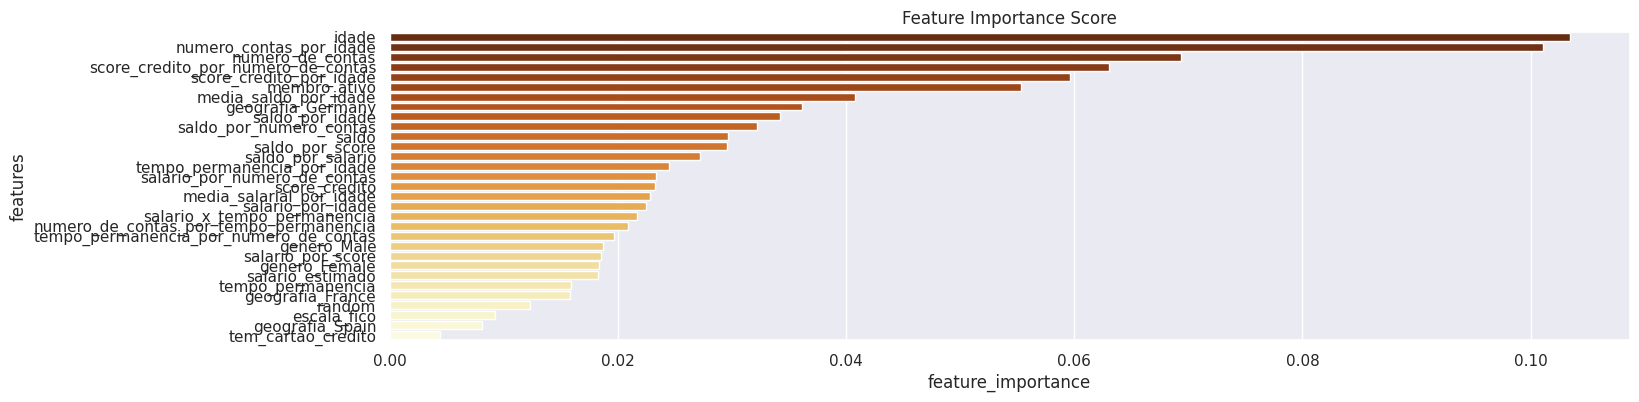

In [133]:
random_forest_importance = RandomForestClassifier(n_estimators= 700, n_jobs= -1, criterion= 'entropy', random_state= 33).fit(X_train_balanced, y_train_balanced)

feature_selection = pd.DataFrame({'features': X_train_balanced.columns,'feature_importance': random_forest_importance.feature_importances_})\
                                .sort_values('feature_importance', ascending = False).reset_index(drop = True)

plot = sns.barplot(x = 'feature_importance', y= 'features', data = feature_selection, palette= "YlOrBr_r")
plot.set_title('Feature Importance Score');

## Boruta Feature Selector

In [134]:
X_train_boruta= X_train_balanced.values
y_train_boruta = y_train_balanced.values

In [135]:
# Instanciando Boruta e treinando modelo.
random_forest_boruta = RandomForestClassifier(n_estimators= 700, n_jobs= -1, criterion= 'entropy', random_state= 33)

boruta = BorutaPy(random_forest_boruta, verbose= 1, random_state= 33).fit(X_train_boruta, y_train_boruta)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	27
Tentative: 	0
Rejected: 	4


### Best Features from Boruta 

In [136]:
features_selected = boruta.support_.tolist()

features_selected_boruta = X_train_balanced.iloc[:, features_selected].columns.to_list()

features_not_selected_boruta = list(np.setdiff1d(X_train_balanced.columns, features_selected_boruta))

In [137]:
features_selected_boruta

['score_credito',
 'idade',
 'tempo_permanencia',
 'saldo',
 'numero_de_contas',
 'membro_ativo',
 'salario_estimado',
 'saldo_por_salario',
 'saldo_por_score',
 'saldo_por_numero_contas',
 'saldo_por_idade',
 'salario_por_numero_de_contas',
 'salario_por_score',
 'salario_x_tempo_permanencia',
 'salario_por_idade',
 'score_credito_por_idade',
 'score_credito_por_numero_de_contas',
 'tempo_permanencia_por_idade',
 'tempo_permanencia_por_numero_de_contas',
 'numero_contas_por_idade',
 'numero_de_contas_por_tempo_permanencia',
 'media_saldo_por_idade',
 'media_salarial_por_idade',
 'geografia_France',
 'geografia_Germany',
 'genero_Female',
 'genero_Male']

In [138]:
features_not_selected_boruta

['escala_fico', 'geografia_Spain', 'random', 'tem_cartao_credito']

## Selecting Variables

Minha estratégia para seleção de features:

	- Como a maioria dos modelos usados nesse projeto, são algoritmos baseados em árvore de decisão, vou manter todas as variáveis padrão para que os modelos possam fazer a suas próprias interações entre features;
    - Preferência para análise bivariada e depois para análise multivariada (>= correlação fraca).
    - Ordenação de features através da etapa de feature importance.

In [139]:
best_features = ['idade', 'numero_contas_por_idade', 'numero_de_contas', 'score_credito_por_numero_de_contas', 
                 'score_credito_por_idade', 'saldo_por_numero_contas', 'saldo_por_score', 'saldo', 'score_credito', 
                 'salario_por_idade', 'tempo_permanencia_por_idade', 'salario_estimado', 'membro_ativo', 
                 'numero_de_contas_por_tempo_permanencia', 'tempo_permanencia', 'escala_fico', 
                 'tem_cartao_credito', 'geografia_France', 'geografia_Germany', 'genero_Female', 'genero_Male']

# Machine Learning and Model Metrics 

In [140]:
df7 = df6.copy()

## Filtering Data Selecting Best Features to Model

In [141]:
X_train_model = X_train_balanced[best_features]
y_train_model = y_train_balanced

X_test_model = X_test[best_features]
y_test_model = y_test

In [142]:
X_train_model.sample(5)

idade  numero_contas_por_idade  numero_de_contas  score_credito_por_numero_de_contas  score_credito_por_idade  saldo_por_numero_contas  saldo_por_score     saldo  score_credito  salario_por_idade  tempo_permanencia_por_idade  salario_estimado  membro_ativo  numero_de_contas_por_tempo_permanencia  tempo_permanencia  escala_fico  tem_cartao_credito  geografia_France  geografia_Germany  genero_Female  genero_Male
3239 -0.083333                 0.633333                 2                            0.314153                 0.173351                 0.000000         0.000000  0.000000       0.626000           0.473377                     1.111111          0.681755             0                               -0.257143           1.000000            1                   1               1.0                0.0        0.00000      1.00000
3114 -1.000000                 1.469333                 2                            0.302249                 1.257468                 0.330143         0.538675  0.627362       0.590000           0.449423                    -0.618182          0.465352             0                                5.142857           0.100000            1                   1               0.0                1.0        0.00000      1.00000
7609  0.757969                -0.514261                 1                            0.587175                -0.791132                 0.590462         0.577562  0.561020       0.375809           0.540466                     0.245283          0.893491             0                               -0.434349           0.738972            0                   1               0.0                1.0        0.00000      1.00000
4091  0.500000                -0.471318                 1                            0.857143                 0.002899                 0.407184         0.288763  0.386881       0.784000          -0.406178                     0.105708          0.304571             1                               -0.357143           0.600000            3                   0               0.0                1.0        1.00000      0.00000
7703  0.192992                 0.474588                 2                            0.113578                -1.190084                 0.233091         0.684821  0.442937       0.019459           0.253924                    -0.909091          0.628891             0                               -0.857143           0.000000            0                   0               0.0                1.0        0.06318      0.93682

In [143]:
X_test_model.sample(5)

idade  numero_contas_por_idade  numero_de_contas  score_credito_por_numero_de_contas  score_credito_por_idade  saldo_por_numero_contas  saldo_por_score     saldo  score_credito  salario_por_idade  tempo_permanencia_por_idade  salario_estimado  membro_ativo  numero_de_contas_por_tempo_permanencia  tempo_permanencia  escala_fico  tem_cartao_credito  geografia_France  geografia_Germany  genero_Female  genero_Male
1974 -1.000000                 1.469333                 2                            0.318122                 1.398428                 0.329775         0.518772  0.626663          0.638           0.914066                     1.127273          0.621916             0                                0.000000                0.7            1                   1               0.0                0.0            0.0          1.0
254   0.333333                -0.432520                 1                            0.911376                 0.273329                 0.447341         0.300629  0.425035          0.866           0.669367                    -0.022173          0.884756             0                               -0.257143                0.5            3                   1               0.0                1.0            1.0          0.0
2298 -0.416667                 0.870833                 2                            0.286376                 0.318654                 0.000000         0.000000  0.000000          0.542           1.025012                    -0.681818          0.843920             1                                5.142857                0.1            1                   1               1.0                0.0            0.0          1.0
2726 -1.166667                 1.707246                 2                            0.339286                 1.944392                 0.390333         0.586006  0.741740          0.702           0.303992                     0.671937          0.383035             1                                0.342857                0.5            2                   1               0.0                1.0            0.0          1.0
1277 -0.833333                 0.000000                 1                            0.617725                 0.520040                 0.568977         0.533686  0.540606          0.422           1.171665                     1.515152          0.765417             0                               -0.523810                0.9            0                   1               1.0                0.0            1.0          0.0

## Cross Validation (Real Performance)

### Logistic Regression

In [144]:
kfold = KFold(5, shuffle= True, random_state= 33)

logistic_regression_cv = LogisticRegression(random_state= 33)

accuracy_logistic = cross_val_score(logistic_regression_cv, X_train_model, y_train_model, cv= kfold)

print(f'Acurácia (Cross Validation): {round(accuracy_logistic.mean(), 3)} +/-{round(accuracy_logistic.std(), 3)}')

Acurácia (Cross Validation): 0.839 +/-0.004


### Random Forest

In [145]:
kfold = KFold(5, shuffle= True, random_state= 33)

random_forest_cv = RandomForestClassifier(n_jobs= -1, random_state= 33)

accuracy_rf = cross_val_score(random_forest_cv, X_train_model, y_train_model, cv= kfold)

print(f'Acurácia (Cross Validation): {round(accuracy_rf.mean(), 3)} +/-{round(accuracy_rf.std(), 3)}')

Acurácia (Cross Validation): 0.947 +/-0.002


### Gradient Boosting

In [146]:
kfold = KFold(5, shuffle= True, random_state= 33)

gradient_boosting_cv = GradientBoostingClassifier(random_state = 33)

accuracy_gb = cross_val_score(gradient_boosting_cv, X_train_model, y_train_model, cv= kfold)

print(f'Acurácia (Cross Validation): {round(accuracy_gb.mean(), 3)} +/-{round(accuracy_gb.std(), 3)}')

Acurácia (Cross Validation): 0.913 +/-0.004


### XGB

In [147]:
kfold = KFold(5, shuffle= True, random_state= 33)

xg_boost_cv = XGBClassifier(random_state= 33, n_jobs= -1)

accuracy_xgb = cross_val_score(xg_boost_cv, X_train_model, y_train_model, cv= kfold)

print(f'Acurácia (Cross Validation): {round(accuracy_xgb.mean(), 3)} +/-{round(accuracy_xgb.std(), 3)}')

Acurácia (Cross Validation): 0.951 +/-0.003


### CatBoost

In [148]:
kfold = KFold(5, shuffle= True, random_state= 33)

cat_boost_cv = CatBoostClassifier(random_state = 33, allow_writing_files=False)

accuracy_cb = cross_val_score(cat_boost_cv, X_train_model, y_train_model, cv= kfold)

print(f'Acurácia (Cross Validation): {round(accuracy_cb.mean(), 3)} +/-{round(accuracy_cb.std(), 3)}')

Learning rate set to 0.022886
0:	learn: 0.6727983	total: 71.7ms	remaining: 1m 11s
1:	learn: 0.6500371	total: 75.9ms	remaining: 37.9s
2:	learn: 0.6307940	total: 80.6ms	remaining: 26.8s
3:	learn: 0.6124647	total: 85.5ms	remaining: 21.3s
4:	learn: 0.5922689	total: 88.1ms	remaining: 17.5s
5:	learn: 0.5743415	total: 90.7ms	remaining: 15s
6:	learn: 0.5581424	total: 92.9ms	remaining: 13.2s
7:	learn: 0.5418712	total: 95.1ms	remaining: 11.8s
8:	learn: 0.5298328	total: 97.6ms	remaining: 10.7s
9:	learn: 0.5173938	total: 100ms	remaining: 9.94s
10:	learn: 0.5055611	total: 103ms	remaining: 9.24s
11:	learn: 0.4933351	total: 105ms	remaining: 8.62s
12:	learn: 0.4827797	total: 106ms	remaining: 8.07s
13:	learn: 0.4721761	total: 108ms	remaining: 7.61s
14:	learn: 0.4634073	total: 110ms	remaining: 7.22s
15:	learn: 0.4540617	total: 112ms	remaining: 6.87s
16:	learn: 0.4456191	total: 114ms	remaining: 6.58s
17:	learn: 0.4372068	total: 115ms	remaining: 6.3s
18:	learn: 0.4294065	total: 118ms	remaining: 6.08s
19:	

233:	learn: 0.1986379	total: 522ms	remaining: 1.71s
234:	learn: 0.1981947	total: 524ms	remaining: 1.71s
235:	learn: 0.1978579	total: 526ms	remaining: 1.7s
236:	learn: 0.1976221	total: 528ms	remaining: 1.7s
237:	learn: 0.1972226	total: 530ms	remaining: 1.7s
238:	learn: 0.1969239	total: 532ms	remaining: 1.7s
239:	learn: 0.1967472	total: 535ms	remaining: 1.69s
240:	learn: 0.1964621	total: 537ms	remaining: 1.69s
241:	learn: 0.1962506	total: 539ms	remaining: 1.69s
242:	learn: 0.1960998	total: 541ms	remaining: 1.68s
243:	learn: 0.1958937	total: 544ms	remaining: 1.69s
244:	learn: 0.1955834	total: 546ms	remaining: 1.68s
245:	learn: 0.1952901	total: 548ms	remaining: 1.68s
246:	learn: 0.1949757	total: 549ms	remaining: 1.67s
247:	learn: 0.1945357	total: 551ms	remaining: 1.67s
248:	learn: 0.1943291	total: 553ms	remaining: 1.67s
249:	learn: 0.1938596	total: 555ms	remaining: 1.66s
250:	learn: 0.1936396	total: 556ms	remaining: 1.66s
251:	learn: 0.1933277	total: 558ms	remaining: 1.66s
252:	learn: 0.19

451:	learn: 0.1468147	total: 921ms	remaining: 1.12s
452:	learn: 0.1466281	total: 924ms	remaining: 1.11s
453:	learn: 0.1463852	total: 926ms	remaining: 1.11s
454:	learn: 0.1462484	total: 928ms	remaining: 1.11s
455:	learn: 0.1461498	total: 931ms	remaining: 1.11s
456:	learn: 0.1459295	total: 933ms	remaining: 1.11s
457:	learn: 0.1457294	total: 935ms	remaining: 1.11s
458:	learn: 0.1455183	total: 937ms	remaining: 1.1s
459:	learn: 0.1453520	total: 938ms	remaining: 1.1s
460:	learn: 0.1452574	total: 940ms	remaining: 1.1s
461:	learn: 0.1451650	total: 942ms	remaining: 1.1s
462:	learn: 0.1450251	total: 944ms	remaining: 1.09s
463:	learn: 0.1447714	total: 946ms	remaining: 1.09s
464:	learn: 0.1445014	total: 948ms	remaining: 1.09s
465:	learn: 0.1443918	total: 949ms	remaining: 1.09s
466:	learn: 0.1440421	total: 951ms	remaining: 1.08s
467:	learn: 0.1438831	total: 953ms	remaining: 1.08s
468:	learn: 0.1436793	total: 954ms	remaining: 1.08s
469:	learn: 0.1434785	total: 956ms	remaining: 1.08s
470:	learn: 0.14

656:	learn: 0.1161955	total: 1.32s	remaining: 691ms
657:	learn: 0.1160762	total: 1.32s	remaining: 689ms
658:	learn: 0.1159862	total: 1.33s	remaining: 687ms
659:	learn: 0.1157847	total: 1.33s	remaining: 685ms
660:	learn: 0.1156242	total: 1.33s	remaining: 683ms
661:	learn: 0.1155299	total: 1.33s	remaining: 681ms
662:	learn: 0.1155156	total: 1.34s	remaining: 680ms
663:	learn: 0.1153550	total: 1.34s	remaining: 678ms
664:	learn: 0.1151913	total: 1.34s	remaining: 676ms
665:	learn: 0.1150189	total: 1.34s	remaining: 673ms
666:	learn: 0.1149298	total: 1.34s	remaining: 671ms
667:	learn: 0.1147493	total: 1.35s	remaining: 669ms
668:	learn: 0.1145686	total: 1.35s	remaining: 667ms
669:	learn: 0.1143838	total: 1.35s	remaining: 665ms
670:	learn: 0.1142682	total: 1.35s	remaining: 663ms
671:	learn: 0.1141066	total: 1.35s	remaining: 661ms
672:	learn: 0.1139828	total: 1.35s	remaining: 659ms
673:	learn: 0.1138942	total: 1.36s	remaining: 656ms
674:	learn: 0.1137902	total: 1.36s	remaining: 654ms
675:	learn: 

877:	learn: 0.0942278	total: 1.72s	remaining: 239ms
878:	learn: 0.0941073	total: 1.72s	remaining: 237ms
879:	learn: 0.0940319	total: 1.72s	remaining: 235ms
880:	learn: 0.0938947	total: 1.73s	remaining: 233ms
881:	learn: 0.0938605	total: 1.73s	remaining: 231ms
882:	learn: 0.0938110	total: 1.73s	remaining: 229ms
883:	learn: 0.0937201	total: 1.73s	remaining: 228ms
884:	learn: 0.0936225	total: 1.74s	remaining: 226ms
885:	learn: 0.0935116	total: 1.74s	remaining: 224ms
886:	learn: 0.0934572	total: 1.74s	remaining: 222ms
887:	learn: 0.0933689	total: 1.74s	remaining: 220ms
888:	learn: 0.0932999	total: 1.74s	remaining: 218ms
889:	learn: 0.0932473	total: 1.75s	remaining: 216ms
890:	learn: 0.0931922	total: 1.75s	remaining: 214ms
891:	learn: 0.0931217	total: 1.75s	remaining: 212ms
892:	learn: 0.0930481	total: 1.75s	remaining: 210ms
893:	learn: 0.0928678	total: 1.75s	remaining: 208ms
894:	learn: 0.0927920	total: 1.75s	remaining: 206ms
895:	learn: 0.0926822	total: 1.76s	remaining: 204ms
896:	learn: 

79:	learn: 0.2748797	total: 148ms	remaining: 1.7s
80:	learn: 0.2740897	total: 150ms	remaining: 1.7s
81:	learn: 0.2730997	total: 152ms	remaining: 1.7s
82:	learn: 0.2722561	total: 154ms	remaining: 1.7s
83:	learn: 0.2715541	total: 156ms	remaining: 1.7s
84:	learn: 0.2705424	total: 158ms	remaining: 1.7s
85:	learn: 0.2697671	total: 160ms	remaining: 1.7s
86:	learn: 0.2689752	total: 162ms	remaining: 1.7s
87:	learn: 0.2682070	total: 164ms	remaining: 1.7s
88:	learn: 0.2672631	total: 166ms	remaining: 1.7s
89:	learn: 0.2663950	total: 168ms	remaining: 1.7s
90:	learn: 0.2658908	total: 170ms	remaining: 1.69s
91:	learn: 0.2650357	total: 172ms	remaining: 1.69s
92:	learn: 0.2640770	total: 173ms	remaining: 1.69s
93:	learn: 0.2632911	total: 175ms	remaining: 1.69s
94:	learn: 0.2620827	total: 177ms	remaining: 1.68s
95:	learn: 0.2612621	total: 178ms	remaining: 1.68s
96:	learn: 0.2606129	total: 180ms	remaining: 1.68s
97:	learn: 0.2597529	total: 182ms	remaining: 1.67s
98:	learn: 0.2591294	total: 183ms	remainin

301:	learn: 0.1765279	total: 546ms	remaining: 1.26s
302:	learn: 0.1762676	total: 549ms	remaining: 1.26s
303:	learn: 0.1760253	total: 551ms	remaining: 1.26s
304:	learn: 0.1757535	total: 554ms	remaining: 1.26s
305:	learn: 0.1755259	total: 556ms	remaining: 1.26s
306:	learn: 0.1753032	total: 558ms	remaining: 1.26s
307:	learn: 0.1750270	total: 560ms	remaining: 1.26s
308:	learn: 0.1747447	total: 562ms	remaining: 1.26s
309:	learn: 0.1745487	total: 564ms	remaining: 1.25s
310:	learn: 0.1743340	total: 566ms	remaining: 1.25s
311:	learn: 0.1741191	total: 568ms	remaining: 1.25s
312:	learn: 0.1738222	total: 570ms	remaining: 1.25s
313:	learn: 0.1735887	total: 571ms	remaining: 1.25s
314:	learn: 0.1734410	total: 573ms	remaining: 1.25s
315:	learn: 0.1732310	total: 575ms	remaining: 1.24s
316:	learn: 0.1730120	total: 576ms	remaining: 1.24s
317:	learn: 0.1727329	total: 578ms	remaining: 1.24s
318:	learn: 0.1725032	total: 580ms	remaining: 1.24s
319:	learn: 0.1722323	total: 582ms	remaining: 1.24s
320:	learn: 

514:	learn: 0.1325949	total: 945ms	remaining: 890ms
515:	learn: 0.1323929	total: 947ms	remaining: 889ms
516:	learn: 0.1322778	total: 949ms	remaining: 887ms
517:	learn: 0.1321810	total: 952ms	remaining: 886ms
518:	learn: 0.1319912	total: 954ms	remaining: 885ms
519:	learn: 0.1318282	total: 957ms	remaining: 883ms
520:	learn: 0.1316609	total: 960ms	remaining: 882ms
521:	learn: 0.1315324	total: 962ms	remaining: 881ms
522:	learn: 0.1313998	total: 964ms	remaining: 879ms
523:	learn: 0.1312061	total: 966ms	remaining: 877ms
524:	learn: 0.1309617	total: 968ms	remaining: 876ms
525:	learn: 0.1307848	total: 970ms	remaining: 874ms
526:	learn: 0.1306218	total: 971ms	remaining: 872ms
527:	learn: 0.1303942	total: 974ms	remaining: 870ms
528:	learn: 0.1302493	total: 977ms	remaining: 870ms
529:	learn: 0.1300988	total: 979ms	remaining: 868ms
530:	learn: 0.1299985	total: 981ms	remaining: 866ms
531:	learn: 0.1297803	total: 982ms	remaining: 864ms
532:	learn: 0.1296387	total: 984ms	remaining: 862ms
533:	learn: 

726:	learn: 0.1059445	total: 1.34s	remaining: 504ms
727:	learn: 0.1057422	total: 1.34s	remaining: 503ms
728:	learn: 0.1056461	total: 1.35s	remaining: 501ms
729:	learn: 0.1055658	total: 1.35s	remaining: 499ms
730:	learn: 0.1053921	total: 1.35s	remaining: 498ms
731:	learn: 0.1052859	total: 1.36s	remaining: 497ms
732:	learn: 0.1051211	total: 1.36s	remaining: 495ms
733:	learn: 0.1049729	total: 1.36s	remaining: 493ms
734:	learn: 0.1048698	total: 1.36s	remaining: 492ms
735:	learn: 0.1047624	total: 1.36s	remaining: 490ms
736:	learn: 0.1047226	total: 1.37s	remaining: 488ms
737:	learn: 0.1044430	total: 1.37s	remaining: 486ms
738:	learn: 0.1043340	total: 1.37s	remaining: 484ms
739:	learn: 0.1041979	total: 1.37s	remaining: 483ms
740:	learn: 0.1041758	total: 1.38s	remaining: 481ms
741:	learn: 0.1040050	total: 1.38s	remaining: 479ms
742:	learn: 0.1039012	total: 1.38s	remaining: 477ms
743:	learn: 0.1038371	total: 1.38s	remaining: 475ms
744:	learn: 0.1036093	total: 1.38s	remaining: 473ms
745:	learn: 

933:	learn: 0.0865970	total: 1.74s	remaining: 123ms
934:	learn: 0.0864760	total: 1.74s	remaining: 121ms
935:	learn: 0.0864076	total: 1.74s	remaining: 119ms
936:	learn: 0.0863191	total: 1.75s	remaining: 117ms
937:	learn: 0.0862419	total: 1.75s	remaining: 116ms
938:	learn: 0.0861598	total: 1.75s	remaining: 114ms
939:	learn: 0.0861094	total: 1.75s	remaining: 112ms
940:	learn: 0.0860328	total: 1.75s	remaining: 110ms
941:	learn: 0.0859815	total: 1.76s	remaining: 108ms
942:	learn: 0.0859349	total: 1.76s	remaining: 106ms
943:	learn: 0.0858316	total: 1.76s	remaining: 104ms
944:	learn: 0.0857756	total: 1.76s	remaining: 103ms
945:	learn: 0.0856695	total: 1.76s	remaining: 101ms
946:	learn: 0.0855206	total: 1.76s	remaining: 98.8ms
947:	learn: 0.0854735	total: 1.77s	remaining: 97ms
948:	learn: 0.0854314	total: 1.77s	remaining: 95.1ms
949:	learn: 0.0853443	total: 1.77s	remaining: 93.2ms
950:	learn: 0.0852263	total: 1.77s	remaining: 91.3ms
951:	learn: 0.0851950	total: 1.77s	remaining: 89.5ms
952:	lea

121:	learn: 0.2395003	total: 257ms	remaining: 1.85s
122:	learn: 0.2390122	total: 262ms	remaining: 1.87s
123:	learn: 0.2385587	total: 264ms	remaining: 1.87s
124:	learn: 0.2380011	total: 266ms	remaining: 1.86s
125:	learn: 0.2375585	total: 269ms	remaining: 1.86s
126:	learn: 0.2370943	total: 271ms	remaining: 1.86s
127:	learn: 0.2366355	total: 273ms	remaining: 1.86s
128:	learn: 0.2362881	total: 275ms	remaining: 1.86s
129:	learn: 0.2354307	total: 277ms	remaining: 1.85s
130:	learn: 0.2350054	total: 279ms	remaining: 1.85s
131:	learn: 0.2346157	total: 281ms	remaining: 1.85s
132:	learn: 0.2341722	total: 283ms	remaining: 1.84s
133:	learn: 0.2336672	total: 285ms	remaining: 1.84s
134:	learn: 0.2334027	total: 287ms	remaining: 1.84s
135:	learn: 0.2327834	total: 289ms	remaining: 1.83s
136:	learn: 0.2321497	total: 291ms	remaining: 1.83s
137:	learn: 0.2318023	total: 293ms	remaining: 1.83s
138:	learn: 0.2314540	total: 294ms	remaining: 1.82s
139:	learn: 0.2309332	total: 296ms	remaining: 1.82s
140:	learn: 

327:	learn: 0.1701434	total: 655ms	remaining: 1.34s
328:	learn: 0.1699358	total: 657ms	remaining: 1.34s
329:	learn: 0.1696846	total: 660ms	remaining: 1.34s
330:	learn: 0.1695476	total: 661ms	remaining: 1.34s
331:	learn: 0.1693495	total: 663ms	remaining: 1.33s
332:	learn: 0.1690872	total: 665ms	remaining: 1.33s
333:	learn: 0.1688737	total: 668ms	remaining: 1.33s
334:	learn: 0.1685842	total: 670ms	remaining: 1.33s
335:	learn: 0.1683238	total: 671ms	remaining: 1.33s
336:	learn: 0.1679679	total: 673ms	remaining: 1.32s
337:	learn: 0.1677427	total: 675ms	remaining: 1.32s
338:	learn: 0.1673572	total: 677ms	remaining: 1.32s
339:	learn: 0.1671872	total: 678ms	remaining: 1.32s
340:	learn: 0.1667689	total: 680ms	remaining: 1.31s
341:	learn: 0.1665852	total: 682ms	remaining: 1.31s
342:	learn: 0.1664514	total: 683ms	remaining: 1.31s
343:	learn: 0.1662623	total: 685ms	remaining: 1.31s
344:	learn: 0.1660695	total: 687ms	remaining: 1.3s
345:	learn: 0.1658718	total: 689ms	remaining: 1.3s
346:	learn: 0.

550:	learn: 0.1303554	total: 1.05s	remaining: 856ms
551:	learn: 0.1301988	total: 1.05s	remaining: 854ms
552:	learn: 0.1301177	total: 1.05s	remaining: 853ms
553:	learn: 0.1300676	total: 1.06s	remaining: 853ms
554:	learn: 0.1298857	total: 1.06s	remaining: 851ms
555:	learn: 0.1297099	total: 1.06s	remaining: 850ms
556:	learn: 0.1295294	total: 1.07s	remaining: 849ms
557:	learn: 0.1294593	total: 1.07s	remaining: 847ms
558:	learn: 0.1293157	total: 1.07s	remaining: 845ms
559:	learn: 0.1291845	total: 1.07s	remaining: 843ms
560:	learn: 0.1291408	total: 1.07s	remaining: 841ms
561:	learn: 0.1289620	total: 1.08s	remaining: 839ms
562:	learn: 0.1288831	total: 1.08s	remaining: 837ms
563:	learn: 0.1287254	total: 1.08s	remaining: 836ms
564:	learn: 0.1285413	total: 1.08s	remaining: 834ms
565:	learn: 0.1284262	total: 1.08s	remaining: 832ms
566:	learn: 0.1283472	total: 1.09s	remaining: 830ms
567:	learn: 0.1282044	total: 1.09s	remaining: 828ms
568:	learn: 0.1279877	total: 1.09s	remaining: 826ms
569:	learn: 

758:	learn: 0.1049466	total: 1.45s	remaining: 460ms
759:	learn: 0.1048008	total: 1.45s	remaining: 458ms
760:	learn: 0.1047239	total: 1.45s	remaining: 456ms
761:	learn: 0.1045995	total: 1.46s	remaining: 455ms
762:	learn: 0.1045354	total: 1.46s	remaining: 453ms
763:	learn: 0.1043760	total: 1.46s	remaining: 451ms
764:	learn: 0.1042564	total: 1.46s	remaining: 449ms
765:	learn: 0.1041737	total: 1.46s	remaining: 447ms
766:	learn: 0.1040476	total: 1.47s	remaining: 445ms
767:	learn: 0.1039711	total: 1.47s	remaining: 443ms
768:	learn: 0.1038409	total: 1.47s	remaining: 442ms
769:	learn: 0.1037605	total: 1.47s	remaining: 440ms
770:	learn: 0.1036748	total: 1.47s	remaining: 438ms
771:	learn: 0.1035361	total: 1.48s	remaining: 436ms
772:	learn: 0.1033802	total: 1.48s	remaining: 434ms
773:	learn: 0.1033250	total: 1.48s	remaining: 432ms
774:	learn: 0.1032444	total: 1.48s	remaining: 430ms
775:	learn: 0.1030598	total: 1.48s	remaining: 428ms
776:	learn: 0.1029746	total: 1.48s	remaining: 426ms
777:	learn: 

979:	learn: 0.0850520	total: 1.85s	remaining: 37.7ms
980:	learn: 0.0849806	total: 1.85s	remaining: 35.8ms
981:	learn: 0.0849126	total: 1.85s	remaining: 33.9ms
982:	learn: 0.0848345	total: 1.85s	remaining: 32.1ms
983:	learn: 0.0847653	total: 1.85s	remaining: 30.2ms
984:	learn: 0.0846813	total: 1.86s	remaining: 28.3ms
985:	learn: 0.0845510	total: 1.86s	remaining: 26.4ms
986:	learn: 0.0843700	total: 1.86s	remaining: 24.5ms
987:	learn: 0.0843483	total: 1.86s	remaining: 22.6ms
988:	learn: 0.0843164	total: 1.87s	remaining: 20.8ms
989:	learn: 0.0841750	total: 1.87s	remaining: 18.9ms
990:	learn: 0.0840780	total: 1.87s	remaining: 17ms
991:	learn: 0.0840209	total: 1.87s	remaining: 15.1ms
992:	learn: 0.0839676	total: 1.87s	remaining: 13.2ms
993:	learn: 0.0838999	total: 1.88s	remaining: 11.3ms
994:	learn: 0.0837572	total: 1.88s	remaining: 9.43ms
995:	learn: 0.0836394	total: 1.88s	remaining: 7.54ms
996:	learn: 0.0835621	total: 1.88s	remaining: 5.66ms
997:	learn: 0.0835065	total: 1.88s	remaining: 3.

183:	learn: 0.2167149	total: 345ms	remaining: 1.53s
184:	learn: 0.2164654	total: 347ms	remaining: 1.53s
185:	learn: 0.2161196	total: 349ms	remaining: 1.53s
186:	learn: 0.2156424	total: 351ms	remaining: 1.53s
187:	learn: 0.2152405	total: 353ms	remaining: 1.52s
188:	learn: 0.2147647	total: 356ms	remaining: 1.52s
189:	learn: 0.2143585	total: 358ms	remaining: 1.52s
190:	learn: 0.2140220	total: 360ms	remaining: 1.52s
191:	learn: 0.2138124	total: 362ms	remaining: 1.52s
192:	learn: 0.2134947	total: 365ms	remaining: 1.52s
193:	learn: 0.2129396	total: 367ms	remaining: 1.52s
194:	learn: 0.2126906	total: 368ms	remaining: 1.52s
195:	learn: 0.2122803	total: 370ms	remaining: 1.52s
196:	learn: 0.2119716	total: 372ms	remaining: 1.51s
197:	learn: 0.2117664	total: 373ms	remaining: 1.51s
198:	learn: 0.2113376	total: 375ms	remaining: 1.51s
199:	learn: 0.2110304	total: 377ms	remaining: 1.51s
200:	learn: 0.2105641	total: 379ms	remaining: 1.5s
201:	learn: 0.2102991	total: 381ms	remaining: 1.5s
202:	learn: 0.

400:	learn: 0.1573333	total: 742ms	remaining: 1.11s
401:	learn: 0.1571457	total: 744ms	remaining: 1.11s
402:	learn: 0.1569882	total: 746ms	remaining: 1.1s
403:	learn: 0.1568377	total: 748ms	remaining: 1.1s
404:	learn: 0.1565904	total: 751ms	remaining: 1.1s
405:	learn: 0.1564483	total: 753ms	remaining: 1.1s
406:	learn: 0.1562920	total: 755ms	remaining: 1.1s
407:	learn: 0.1560828	total: 757ms	remaining: 1.1s
408:	learn: 0.1559084	total: 759ms	remaining: 1.1s
409:	learn: 0.1556698	total: 761ms	remaining: 1.09s
410:	learn: 0.1554341	total: 763ms	remaining: 1.09s
411:	learn: 0.1553066	total: 764ms	remaining: 1.09s
412:	learn: 0.1551981	total: 766ms	remaining: 1.09s
413:	learn: 0.1549287	total: 769ms	remaining: 1.09s
414:	learn: 0.1548203	total: 772ms	remaining: 1.09s
415:	learn: 0.1546847	total: 774ms	remaining: 1.09s
416:	learn: 0.1544875	total: 776ms	remaining: 1.08s
417:	learn: 0.1543047	total: 778ms	remaining: 1.08s
418:	learn: 0.1541111	total: 779ms	remaining: 1.08s
419:	learn: 0.15397

620:	learn: 0.1210314	total: 1.14s	remaining: 696ms
621:	learn: 0.1207992	total: 1.14s	remaining: 695ms
622:	learn: 0.1206119	total: 1.15s	remaining: 693ms
623:	learn: 0.1204048	total: 1.15s	remaining: 691ms
624:	learn: 0.1202089	total: 1.15s	remaining: 690ms
625:	learn: 0.1200877	total: 1.15s	remaining: 688ms
626:	learn: 0.1199034	total: 1.15s	remaining: 686ms
627:	learn: 0.1197327	total: 1.16s	remaining: 685ms
628:	learn: 0.1194896	total: 1.16s	remaining: 683ms
629:	learn: 0.1193809	total: 1.16s	remaining: 681ms
630:	learn: 0.1192880	total: 1.16s	remaining: 679ms
631:	learn: 0.1191459	total: 1.16s	remaining: 677ms
632:	learn: 0.1190393	total: 1.17s	remaining: 676ms
633:	learn: 0.1189382	total: 1.17s	remaining: 674ms
634:	learn: 0.1188565	total: 1.17s	remaining: 672ms
635:	learn: 0.1187424	total: 1.17s	remaining: 670ms
636:	learn: 0.1186742	total: 1.17s	remaining: 668ms
637:	learn: 0.1185776	total: 1.17s	remaining: 666ms
638:	learn: 0.1184569	total: 1.18s	remaining: 664ms
639:	learn: 

834:	learn: 0.0978018	total: 1.54s	remaining: 304ms
835:	learn: 0.0976293	total: 1.54s	remaining: 302ms
836:	learn: 0.0975660	total: 1.54s	remaining: 300ms
837:	learn: 0.0974847	total: 1.54s	remaining: 299ms
838:	learn: 0.0973474	total: 1.55s	remaining: 297ms
839:	learn: 0.0972782	total: 1.55s	remaining: 295ms
840:	learn: 0.0972129	total: 1.55s	remaining: 293ms
841:	learn: 0.0971591	total: 1.55s	remaining: 291ms
842:	learn: 0.0970702	total: 1.55s	remaining: 290ms
843:	learn: 0.0969909	total: 1.56s	remaining: 288ms
844:	learn: 0.0969451	total: 1.56s	remaining: 286ms
845:	learn: 0.0969083	total: 1.56s	remaining: 284ms
846:	learn: 0.0968401	total: 1.56s	remaining: 282ms
847:	learn: 0.0967179	total: 1.56s	remaining: 281ms
848:	learn: 0.0966546	total: 1.57s	remaining: 279ms
849:	learn: 0.0965414	total: 1.57s	remaining: 277ms
850:	learn: 0.0964690	total: 1.57s	remaining: 275ms
851:	learn: 0.0963657	total: 1.57s	remaining: 273ms
852:	learn: 0.0963062	total: 1.57s	remaining: 271ms
853:	learn: 

41:	learn: 0.3265315	total: 75.8ms	remaining: 1.73s
42:	learn: 0.3238255	total: 78.6ms	remaining: 1.75s
43:	learn: 0.3215944	total: 80.4ms	remaining: 1.75s
44:	learn: 0.3196769	total: 82.3ms	remaining: 1.75s
45:	learn: 0.3176891	total: 86.4ms	remaining: 1.79s
46:	learn: 0.3157666	total: 88.9ms	remaining: 1.8s
47:	learn: 0.3137477	total: 91.5ms	remaining: 1.81s
48:	learn: 0.3119566	total: 93.5ms	remaining: 1.81s
49:	learn: 0.3100593	total: 95.4ms	remaining: 1.81s
50:	learn: 0.3084288	total: 97.3ms	remaining: 1.81s
51:	learn: 0.3061652	total: 99.3ms	remaining: 1.81s
52:	learn: 0.3047172	total: 101ms	remaining: 1.8s
53:	learn: 0.3028998	total: 103ms	remaining: 1.8s
54:	learn: 0.3012625	total: 105ms	remaining: 1.8s
55:	learn: 0.2996377	total: 107ms	remaining: 1.81s
56:	learn: 0.2982249	total: 109ms	remaining: 1.81s
57:	learn: 0.2964713	total: 111ms	remaining: 1.8s
58:	learn: 0.2947158	total: 113ms	remaining: 1.79s
59:	learn: 0.2927870	total: 114ms	remaining: 1.79s
60:	learn: 0.2917891	tota

257:	learn: 0.1880722	total: 473ms	remaining: 1.36s
258:	learn: 0.1877652	total: 475ms	remaining: 1.36s
259:	learn: 0.1874262	total: 478ms	remaining: 1.36s
260:	learn: 0.1872565	total: 480ms	remaining: 1.36s
261:	learn: 0.1869593	total: 482ms	remaining: 1.36s
262:	learn: 0.1868125	total: 484ms	remaining: 1.35s
263:	learn: 0.1864676	total: 486ms	remaining: 1.35s
264:	learn: 0.1862268	total: 488ms	remaining: 1.35s
265:	learn: 0.1857024	total: 490ms	remaining: 1.35s
266:	learn: 0.1855444	total: 492ms	remaining: 1.35s
267:	learn: 0.1853743	total: 494ms	remaining: 1.35s
268:	learn: 0.1850562	total: 496ms	remaining: 1.35s
269:	learn: 0.1848673	total: 498ms	remaining: 1.34s
270:	learn: 0.1846291	total: 500ms	remaining: 1.34s
271:	learn: 0.1843949	total: 502ms	remaining: 1.34s
272:	learn: 0.1840875	total: 504ms	remaining: 1.34s
273:	learn: 0.1838329	total: 507ms	remaining: 1.34s
274:	learn: 0.1836033	total: 509ms	remaining: 1.34s
275:	learn: 0.1833323	total: 511ms	remaining: 1.34s
276:	learn: 

473:	learn: 0.1393124	total: 871ms	remaining: 966ms
474:	learn: 0.1391680	total: 873ms	remaining: 965ms
475:	learn: 0.1390153	total: 876ms	remaining: 965ms
476:	learn: 0.1388733	total: 878ms	remaining: 963ms
477:	learn: 0.1387049	total: 881ms	remaining: 962ms
478:	learn: 0.1383871	total: 884ms	remaining: 962ms
479:	learn: 0.1383008	total: 886ms	remaining: 960ms
480:	learn: 0.1381666	total: 889ms	remaining: 959ms
481:	learn: 0.1379640	total: 891ms	remaining: 957ms
482:	learn: 0.1377419	total: 893ms	remaining: 956ms
483:	learn: 0.1376065	total: 895ms	remaining: 954ms
484:	learn: 0.1374369	total: 897ms	remaining: 952ms
485:	learn: 0.1373694	total: 898ms	remaining: 950ms
486:	learn: 0.1371781	total: 900ms	remaining: 948ms
487:	learn: 0.1370265	total: 901ms	remaining: 946ms
488:	learn: 0.1368398	total: 903ms	remaining: 944ms
489:	learn: 0.1367573	total: 905ms	remaining: 942ms
490:	learn: 0.1366720	total: 907ms	remaining: 940ms
491:	learn: 0.1364827	total: 908ms	remaining: 938ms
492:	learn: 

692:	learn: 0.1075625	total: 1.27s	remaining: 562ms
693:	learn: 0.1074218	total: 1.27s	remaining: 561ms
694:	learn: 0.1072466	total: 1.27s	remaining: 559ms
695:	learn: 0.1070835	total: 1.28s	remaining: 557ms
696:	learn: 0.1069320	total: 1.28s	remaining: 556ms
697:	learn: 0.1067783	total: 1.28s	remaining: 555ms
698:	learn: 0.1066797	total: 1.28s	remaining: 553ms
699:	learn: 0.1065752	total: 1.28s	remaining: 551ms
700:	learn: 0.1064738	total: 1.29s	remaining: 549ms
701:	learn: 0.1063880	total: 1.29s	remaining: 548ms
702:	learn: 0.1062155	total: 1.29s	remaining: 546ms
703:	learn: 0.1060970	total: 1.29s	remaining: 544ms
704:	learn: 0.1059575	total: 1.29s	remaining: 542ms
705:	learn: 0.1058642	total: 1.3s	remaining: 540ms
706:	learn: 0.1057684	total: 1.3s	remaining: 539ms
707:	learn: 0.1057266	total: 1.3s	remaining: 537ms
708:	learn: 0.1056734	total: 1.3s	remaining: 535ms
709:	learn: 0.1055455	total: 1.3s	remaining: 533ms
710:	learn: 0.1054305	total: 1.31s	remaining: 531ms
711:	learn: 0.105

898:	learn: 0.0883160	total: 1.67s	remaining: 187ms
899:	learn: 0.0881825	total: 1.67s	remaining: 185ms
900:	learn: 0.0881053	total: 1.67s	remaining: 184ms
901:	learn: 0.0880130	total: 1.67s	remaining: 182ms
902:	learn: 0.0879583	total: 1.67s	remaining: 180ms
903:	learn: 0.0878700	total: 1.68s	remaining: 178ms
904:	learn: 0.0878218	total: 1.68s	remaining: 176ms
905:	learn: 0.0877163	total: 1.68s	remaining: 174ms
906:	learn: 0.0875774	total: 1.68s	remaining: 173ms
907:	learn: 0.0875111	total: 1.69s	remaining: 171ms
908:	learn: 0.0874286	total: 1.69s	remaining: 169ms
909:	learn: 0.0873800	total: 1.69s	remaining: 167ms
910:	learn: 0.0873311	total: 1.69s	remaining: 165ms
911:	learn: 0.0872527	total: 1.69s	remaining: 163ms
912:	learn: 0.0871864	total: 1.69s	remaining: 161ms
913:	learn: 0.0871135	total: 1.7s	remaining: 160ms
914:	learn: 0.0870669	total: 1.7s	remaining: 158ms
915:	learn: 0.0869532	total: 1.7s	remaining: 156ms
916:	learn: 0.0868773	total: 1.7s	remaining: 154ms
917:	learn: 0.08

## Training Model and Testing Model

- Random Forest, XGBoost e o CatBoost, tiveram ótimas performances.
- Nesse ciclo irei trabalhar apenas com XGBoost, pois ele é um modelo robusto, rápido e não dá muita margem para hiperparametrização. A Random Forest e o CatBoost vou trabalhar no próximo cíclo.

### XGB

In [149]:
# Instanciando o Modelo
xg_boost = XGBClassifier(random_state= 33, n_jobs= -1)

# Treinando o modelo
xg_boost.fit(X_train_model, y_train_model)

#Testando o modelo
yhat_xgb = xg_boost.predict(X_test_model)

## Metrics

Como meu principal objetivo é prever os clientes que irão sair do banco (1) para tentar criar um plano de ação para evitar a rotatividade desse grupo, a métrica de Recall é a mais importante nesse caso, pois ela tenta responder: de quantos exemplos que foram preditos como positivos, quantos de fato são positivos?

### Important Metrics

#### XGB

In [150]:
print(classification_report(y_test_model, yhat_xgb))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87      2636
           1       0.50      0.71      0.59       664

    accuracy                           0.80      3300
   macro avg       0.71      0.77      0.73      3300
weighted avg       0.83      0.80      0.81      3300



### Confusion Matrix

#### XGB

In [151]:
matrix_absolute = confusion_matrix(y_test_model, yhat_xgb)
matrix_percentage = confusion_matrix(y_test_model, yhat_xgb, normalize= 'true')

print('- Matriz Absoluta')
print(matrix_absolute)

- Matriz Absoluta
[[2166  470]
 [ 191  473]]


In [152]:
print('- Matriz Percentual')
print(matrix_percentage)

- Matriz Percentual
[[0.82169954 0.17830046]
 [0.2876506  0.7123494 ]]


In [153]:
true_negative_abs = matrix_absolute[0][0]
false_positive_abs = matrix_absolute[0][1]
false_negative_abs = matrix_absolute[1][0]
true_positive_abs = matrix_absolute[1][1]

print(f'True Negative: {true_negative_abs}')
print(f'False Positive: {false_positive_abs}')
print(f'False Negative: {false_negative_abs}')
print(f'True Positive: {true_positive_abs}')

True Negative: 2166
False Positive: 470
False Negative: 191
True Positive: 473


In [154]:
true_negative_perc = matrix_percentage[0][0]
false_positive_perc = matrix_percentage[0][1]
false_negative_perc = matrix_percentage[1][0]
true_positive_perc = matrix_percentage[1][1]

print(f'True Negative: {true_negative_perc * 100:.2f}%')
print(f'False Positive: {false_positive_perc * 100:.2f}%')
print(f'False Negative: {false_negative_perc * 100:.2f}%')
print(f'True Positive: {true_positive_perc * 100 :.2f}%')

True Negative: 82.17%
False Positive: 17.83%
False Negative: 28.77%
True Positive: 71.23%


### ROC AUC

In [155]:
roc_auc_score_xgb = roc_auc_score(y_test, yhat_xgb)

pred_prob_xgb = xg_boost.predict_proba(X_test_model)

fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob_xgb[:, 1], pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

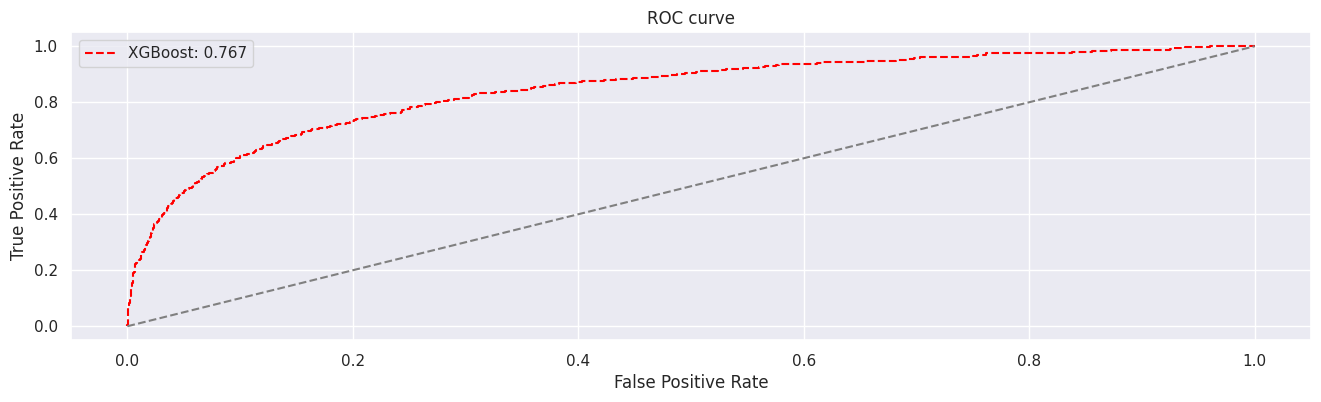

In [156]:
plt.plot(fpr1, tpr1, linestyle='--',color='red', label=f'XGBoost: {roc_auc_score_xgb:.3f}')
plt.plot(p_fpr, p_tpr, linestyle='--', color='gray')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show();

## Hyperparameter Optimization

In [157]:
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(X_train_model, y_train_model, test_size= 0.33, random_state= 33)

### RandomSearch

In [158]:
def xgb_fit(params):
    learning_rate = params[0]
    max_depth = params[1]
    min_child_weight= params[2]
    gamma = params[3]
    subsample = params[4]
    colsample_bytree = params[5]
    reg_alpha = params[6]
    reg_lambda = params[7]
    n_estimators = params[8]
    
    print(f"Parameters: {params}")
    
    model = XGBClassifier(learning_rate= learning_rate, max_depth= max_depth, 
                          min_child_weight= min_child_weight,gamma= gamma, 
                          subsample= subsample, colsample_bytree= colsample_bytree, 
                          reg_alpha= reg_alpha, reg_lambda= reg_lambda, n_estimators= n_estimators,
                          random_state= 0, n_jobs= -1)

    
    model.fit(X_train_xgb, y_train_xgb)
    predict = model.predict_proba(X_val_xgb)[:,1]
    
    return -roc_auc_score(y_val_xgb, predict)

space = [(0.05, 0.3, 'log-uniform'),
         (3, 10),
         (3, 10),
         (0, 5),
         (0.5, 0.9),
         (0.5, 0.9),
         (0.01, 10),
         (0.01, 10),
         (500, 1800)]
    
result_dummy = dummy_minimize(xgb_fit, space, random_state= 33, verbose= 1, n_calls= 50)

Iteration No: 1 started. Evaluating function at random point.
Parameters: [0.17204710274875218, 5, 5, 1, 0.6041198763547599, 0.8481582753387799, 1.858548872347431, 0.20641764004613972, 1313]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.3577
Function value obtained: -0.9861
Current minimum: -0.9861
Iteration No: 2 started. Evaluating function at random point.
Parameters: [0.24187853742275298, 8, 10, 4, 0.8860107279463817, 0.6573594956486534, 0.8047801371560734, 3.520560169893825, 1770]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.5070
Function value obtained: -0.9833
Current minimum: -0.9861
Iteration No: 3 started. Evaluating function at random point.
Parameters: [0.29108678904500984, 3, 3, 3, 0.5710937988786675, 0.6454105480053767, 8.310014160883128, 7.742191580945293, 710]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.8193
Function value obtained: -0.9727
Current minimum: -0.9861
Iteration No: 4 started. Evalua

Iteration No: 26 ended. Evaluation done at random point.
Time taken: 3.0118
Function value obtained: -0.9803
Current minimum: -0.9861
Iteration No: 27 started. Evaluating function at random point.
Parameters: [0.07390123395976728, 8, 8, 4, 0.6711762168070778, 0.7109759916734433, 8.277359480570524, 9.391069524629975, 1452]
Iteration No: 27 ended. Evaluation done at random point.
Time taken: 3.9737
Function value obtained: -0.9726
Current minimum: -0.9861
Iteration No: 28 started. Evaluating function at random point.
Parameters: [0.12457310886660414, 4, 3, 1, 0.6510001446154272, 0.8751090011058384, 5.9721346135250855, 5.597860217333153, 964]
Iteration No: 28 ended. Evaluation done at random point.
Time taken: 1.3068
Function value obtained: -0.9834
Current minimum: -0.9861
Iteration No: 29 started. Evaluating function at random point.
Parameters: [0.0960426263827329, 3, 8, 1, 0.5010685258625903, 0.7011638608920928, 6.883347918535577, 0.48418324531124607, 1449]
Iteration No: 29 ended. Eva

### Bayesian Optimization

In [159]:
result_gp = gp_minimize(xgb_fit, space, random_state= 33, verbose= 1, n_calls= 80, n_random_starts= 50)

Iteration No: 1 started. Evaluating function at random point.
Parameters: [0.17204710274875218, 8, 9, 1, 0.80036945696187, 0.7451825500120564, 8.506114826448172, 8.799328576830803, 535]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 21.8981
Function value obtained: -0.9799
Current minimum: -0.9799
Iteration No: 2 started. Evaluating function at random point.
Parameters: [0.2162826905761976, 5, 10, 2, 0.5428605889190291, 0.7983065843080486, 9.641882052253752, 0.9903703438169813, 731]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 19.5405
Function value obtained: -0.9752
Current minimum: -0.9799
Iteration No: 3 started. Evaluating function at random point.
Parameters: [0.09590660191844694, 9, 8, 1, 0.6022533152772451, 0.6686992859875449, 5.613057580972948, 1.208021269479306, 656]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 10.0772
Function value obtained: -0.9823
Current minimum: -0.9823
Iteration No: 4 started. Evaluating

Iteration No: 26 ended. Evaluation done at random point.
Time taken: 2.5108
Function value obtained: -0.9836
Current minimum: -0.9864
Iteration No: 27 started. Evaluating function at random point.
Parameters: [0.10730990078206128, 6, 5, 3, 0.5617535918224013, 0.8618814577260732, 8.077744549180538, 7.790529798331701, 988]
Iteration No: 27 ended. Evaluation done at random point.
Time taken: 2.6553
Function value obtained: -0.9736
Current minimum: -0.9864
Iteration No: 28 started. Evaluating function at random point.
Parameters: [0.2827601728196458, 9, 6, 4, 0.8033434030951123, 0.5543942549307275, 3.01454410503247, 6.743279801784625, 1239]
Iteration No: 28 ended. Evaluation done at random point.
Time taken: 2.8786
Function value obtained: -0.9808
Current minimum: -0.9864
Iteration No: 29 started. Evaluating function at random point.
Parameters: [0.2007429426052066, 7, 9, 2, 0.850035807280622, 0.5250915101889445, 0.4111036432875097, 6.1890037766053805, 1185]
Iteration No: 29 ended. Evaluat

Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 3.0457
Function value obtained: -0.9842
Current minimum: -0.9884
Iteration No: 53 started. Searching for the next optimal point.
Parameters: [0.1750752731064532, 3, 7, 0, 0.8677824603127267, 0.8769551000310996, 8.032364288812776, 0.34884629732767747, 1178]
Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 2.4734
Function value obtained: -0.9839
Current minimum: -0.9884
Iteration No: 54 started. Searching for the next optimal point.
Parameters: [0.057367396448356305, 9, 8, 0, 0.8911171647036462, 0.5127516139545576, 0.6300508468275764, 9.888038726699351, 529]
Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 2.6718
Function value obtained: -0.9866
Current minimum: -0.9884
Iteration No: 55 started. Searching for the next optimal point.
Parameters: [0.07478866227649714, 9, 9, 5, 0.8332090726961947, 0.580316164044054, 0.056509920910944804, 0.24681627466

Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 3.6400
Function value obtained: -0.9857
Current minimum: -0.9891
Iteration No: 79 started. Searching for the next optimal point.
Parameters: [0.29999999999999993, 10, 3, 0, 0.5, 0.9, 0.01, 0.01, 1800]
Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 3.0263
Function value obtained: -0.9880
Current minimum: -0.9891
Iteration No: 80 started. Searching for the next optimal point.
Parameters: [0.050596253213647975, 10, 3, 0, 0.7356999430305673, 0.5593296935087757, 5.0732149405954825, 9.77817957751967, 1721]
Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 5.1046
Function value obtained: -0.9862
Current minimum: -0.9891


### Plot Convergence

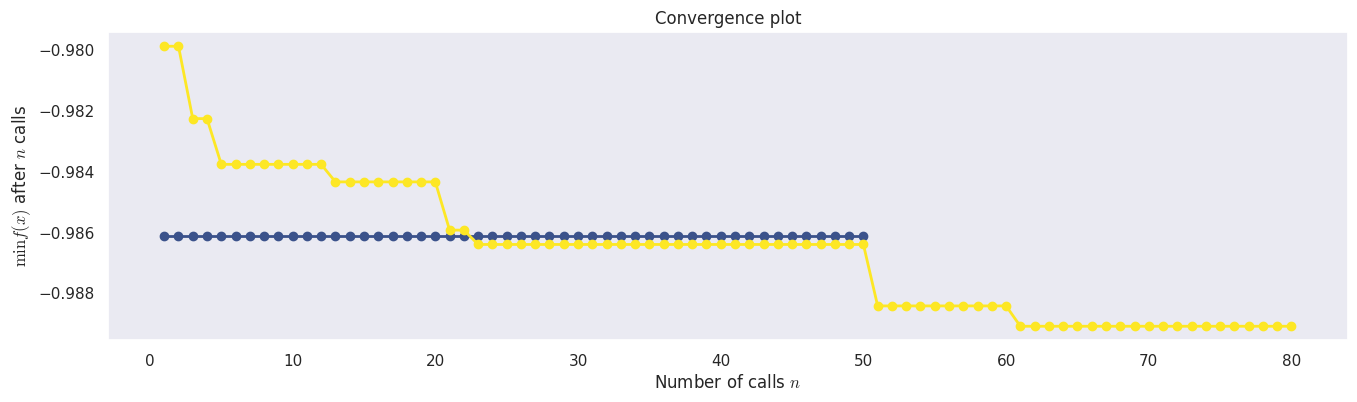

In [160]:
plot_convergence(result_dummy, result_gp);

In [161]:
#Amarelo - Otimização Bayesiana
#Azul - Otimização Randômica

## Final Model

In [163]:
parameters = [0.05, 10, 3, 0, 0.7726291401595758, 0.5, 0.01, 0.01, 1800]

learning_rate = parameters[0]
max_depth = parameters[1]
min_child_weight= parameters[2]
gamma = parameters[3]
subsample = parameters[4]
colsample_bytree = parameters[5]
reg_alpha = parameters[6]
reg_lambda = parameters[7]
n_estimators = parameters[8]

### Real Performance (Cross-Validation)

In [164]:
kfold = KFold(5, shuffle= True, random_state= 33)

# Instaciando Modelo
xg_boost_final_cv = XGBClassifier(learning_rate= learning_rate, max_depth= max_depth, 
                          min_child_weight= min_child_weight, gamma= gamma, 
                          subsample= subsample, colsample_bytree= colsample_bytree, 
                          reg_alpha= reg_alpha, reg_lambda= reg_lambda,
                          random_state= 33, n_jobs= -1, n_estimators= n_estimators)

# Encapsulando métrica de avaliação (Recall)
scorer = make_scorer(recall_score)

# Validação cruzada
accuracy_xgb = cross_val_score(xg_boost_final_cv, X_train_model, y_train_model, cv= kfold)
recall_xgb = cross_val_score(xg_boost_final_cv, X_train_model, y_train_model, cv= kfold, scoring= scorer)
confusion_xgb = cross_val_predict(xg_boost_final_cv, X_train_model, y_train_model, cv= kfold)

# Calcular a matriz de confusão
confusion_mat = confusion_matrix(y_train_model, confusion_xgb, normalize= 'true')

# Métricas
print(f'Accuracy List: {accuracy_xgb}')
print(f'Accuracy Mean/Standard Deviation: {round(accuracy_xgb.mean(), 3)} +/-{round(accuracy_xgb.std(), 3)}')
print(f'Recall List: {recall_xgb}')
print(f'Recall Mean/Standard Deviation: {round(recall_xgb.mean(), 3)} +/-{round(recall_xgb.std(), 3)}')
print(confusion_mat)

Accuracy List: [0.96298581 0.94941394 0.95003085 0.95619988 0.95185185]
Accuracy Mean/Standard Deviation: 0.954 +/-0.005
Recall List: [0.97631308 0.95193312 0.95723014 0.96684492 0.96361746]
Recall Mean/Standard Deviation: 0.963 +/-0.008
[[0.94085532 0.05914468]
 [0.0368213  0.9631787 ]]


### Test Data Performance

In [166]:
# Instanciando o Modelo
xg_boost_final_test = XGBClassifier(learning_rate= learning_rate, max_depth= max_depth, 
                          min_child_weight= min_child_weight, gamma= gamma, 
                          subsample= subsample, colsample_bytree= colsample_bytree, 
                          reg_alpha= reg_alpha, reg_lambda= reg_lambda,
                          random_state= 33, n_jobs= -1, n_estimators= n_estimators)

# Treinando o modelo
xg_boost_final_test.fit(X_train_model, y_train_model)

#Testando o modelo
yhat_xgb_final = xg_boost_final_test.predict(X_test_model)

# Métricas
print(classification_report(y_test_model, yhat_xgb_final))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87      2636
           1       0.50      0.72      0.59       664

    accuracy                           0.80      3300
   macro avg       0.71      0.77      0.73      3300
weighted avg       0.84      0.80      0.81      3300



#### Confusion Matrix

In [167]:
matrix_absolute = confusion_matrix(y_test_model, yhat_xgb_final)
matrix_percentage = confusion_matrix(y_test_model, yhat_xgb_final, normalize= 'true')

print('- Matriz Absoluta')
print(matrix_absolute)

- Matriz Absoluta
[[2158  478]
 [ 185  479]]


In [168]:
print('- Matriz Percentual')
print(matrix_percentage)

- Matriz Percentual
[[0.81866464 0.18133536]
 [0.27861446 0.72138554]]


In [169]:
true_negative_abs = matrix_absolute[0][0]
false_positive_abs = matrix_absolute[0][1]
false_negative_abs = matrix_absolute[1][0]
true_positive_abs = matrix_absolute[1][1]

print(f'True Negative: {true_negative_abs}')
print(f'False Positive: {false_positive_abs}')
print(f'False Negative: {false_negative_abs}')
print(f'True Positive: {true_positive_abs}')

True Negative: 2158
False Positive: 478
False Negative: 185
True Positive: 479


In [170]:
true_negative_perc = matrix_percentage[0][0]
false_positive_perc = matrix_percentage[0][1]
false_negative_perc = matrix_percentage[1][0]
true_positive_perc = matrix_percentage[1][1]

print(f'True Negative: {true_negative_perc * 100:.2f}%')
print(f'False Positive: {false_positive_perc * 100:.2f}%')
print(f'False Negative: {false_negative_perc * 100:.2f}%')
print(f'True Positive: {true_positive_perc * 100 :.2f}%')

True Negative: 81.87%
False Positive: 18.13%
False Negative: 27.86%
True Positive: 72.14%


#### ROC Curve

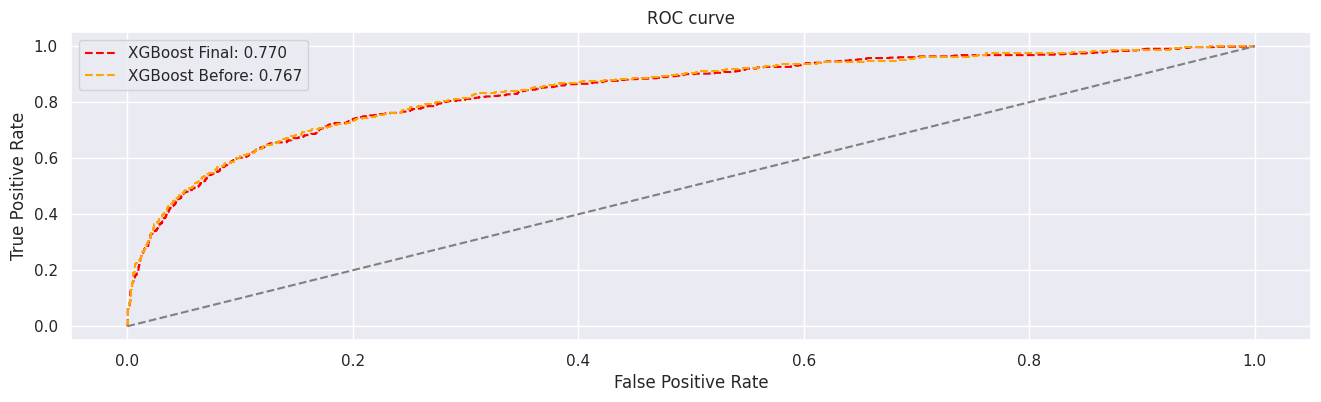

In [171]:
roc_auc_score_xgb_final = roc_auc_score(y_test, yhat_xgb_final)

pred_prob_xgb_final = xg_boost_final_test.predict_proba(X_test_model)

fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob_xgb_final[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob_xgb[:,1], pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

plt.plot(fpr1, tpr1, linestyle='--',color='red', label=f'XGBoost Final: {roc_auc_score_xgb_final:.3f}' )
plt.plot(fpr2, tpr2, linestyle='--',color='orange', label=f'XGBoost Before: {roc_auc_score_xgb:.3f}')
plt.plot(p_fpr, p_tpr, linestyle='--', color='gray')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show();

## Note:

Observações importantes:

Neste 2º ciclo, conseguimos aumentar a acurária real em 8,7% e a recall real em 9,9% em relação ao primeiro ciclo! Porém ainda possuimos um overfitting pelo balanceamento de dados, mesmo trocando a técnica de balanceamento. Para dados de teste, a acurácia se manteve em 80%, mas conseguimos aumentar consideravelmente a métrica principal do problema (Recall: 70% => aumento de 16% em relação ao ciclo anterior) sem perder na métrica de precisão.

Como existe ainda um overfitting considerável de certa forma, irei utilizar as métricas de teste como parâmetros reais para calculo de negócio.

- A hiperparametrização não teve efeito significativo na performance do modelo, aumentou apenas 2% o Recall para dados de teste.

Para a próxima versão:
1. Melhorar a visualização das métricas;
2. Estudar sobre parametrização da Random Forest e aplicar hiperparametrização para Feature Importance, Boruta e modelo;
3. Estudar sobre parametrização do CatBoost e aplicar hiperparametrização.
4. Aplicar técnica de hiperparametrização Optuna.

# Business Translation

In [174]:
df8 = df7.copy()

## Qual é a atual taxa de rotatividade (churn) do Top Bank?

- Foi respondida na análise univariada da variável resposta. 20.37% de Churn Rate.

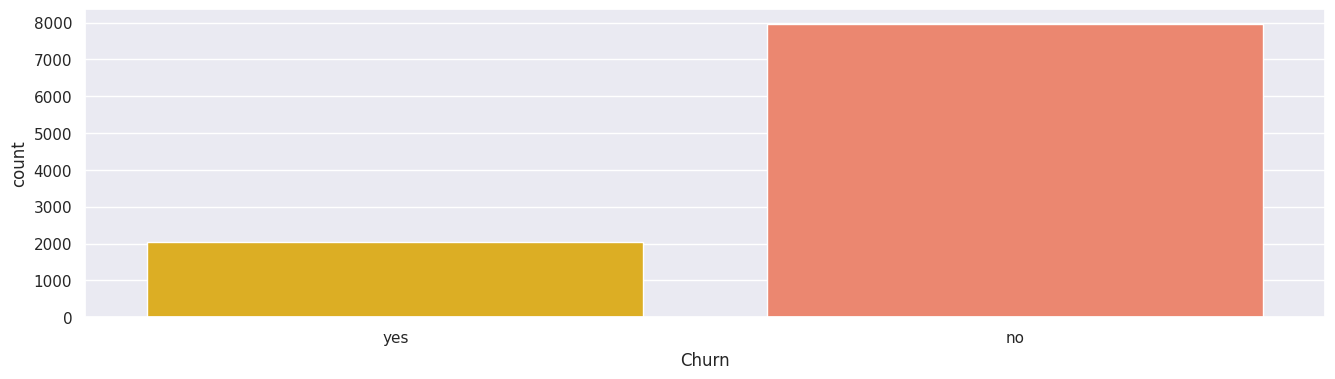

In [172]:
sns.countplot(x=df3['Churn']);

In [175]:
percentage_no_churn = df8[['id_cliente', 'Churn']].loc[df8['Churn'] == 0].shape[0] / df8.shape[0] * 100
percentage_yes_churn = df8[['id_cliente', 'Churn']].loc[df8['Churn'] == 1].shape[0] / df8.shape[0] * 100
print(f'R: Clientes que irão dar Churn correspondem a {percentage_yes_churn:.2f}% da base de dados e clientes que não irão dar Churn correspondem a {percentage_no_churn:.2f}% da base de dados.')

R: Clientes que irão dar Churn correspondem a 20.37% da base de dados e clientes que não irão dar Churn correspondem a 79.63% da base de dados.


## Qual é o desempenho do modelo na classificação de clientes como churns?

    R: O modelo escolhido (XGBoost) possui uma performance real de 96% nesse segundo ciclo.

## Qual é o retorno esperado, em termos de receita, se a empresa utilizar seu modelo para evitar o churn de clientes?

Condiderando a base de dados atual, que temos 20,37% dos clientes como positivos para rotatividade e 79,63% negativos para rotatividade, e considerando o modelo XGBoost que acerta aproximadamente 70% dos clientes que são positivos para rotatividade, temos que:

In [176]:
recall = recall_score(y_test_model, yhat_xgb_final)

receita_não_churn = df3.loc[df3['Churn'] == 'no']['salario_estimado'].sum()
receita_sim_churn = df3.loc[df3['Churn'] == 'yes']['salario_estimado'].sum() * recall
print(f'Se a empresa usar o modelo desenvolvido com um recall de {(recall * 100):.2f}% para clientes com rotatividade positiva, a receita média anual será de US${(receita_não_churn + receita_sim_churn):.2f}')
print('Obs.: Considerando que a empresa vá converter todos os clientes que foram identificados')

Se a empresa usar o modelo desenvolvido com um recall de 72.14% para clientes com rotatividade positiva, a receita média anual será de US$943316806.57
Obs.: Considerando que a empresa vá converter todos os clientes que foram identificados


# Referências

- **Alura - Lidando com desbalanceamento de dados** (https://www.alura.com.br/artigos/lidando-com-desbalanceamento-dados#:~:text=%C3%89%20uma%20t%C3%A9cnica%20que%20consiste%20em%20aumentar%20a%20quantidade%20de,da%20classe%20com%20menor%20frequ%C3%AAncia)
- **Practicing Machine Learning with Imbalanced Dataset** (https://www.analyticsvidhya.com/blog/2023/01/practicing-machine-learning-with-imbalanced-dataset/?utm_source=related_WP&utm_medium=https://www.analyticsvidhya.com/blog/2023/02/building-customer-churn-prediction-model-with-imbalance-dataset/)
- **Mastering XGBoost Parameter Tuning** (https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/?utm_source=reading_list&utm_medium=https://wwUnderstandw.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/#)
- **Understand Random Forest Algorithms With Examples (Updated 2023)** (https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/?utm_source=reading_list&utm_medium=https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)
- **Feature Engineering for Machine Learning** (book) - Alice Zheng, Amanda Casari

In [ ]:
#Erro de sincronicidade da função - corrigir no próximo ciclo

#def xgb_fit(params):
#    learning_rate = params[0]
#    max_depth = params[1]
#    min_child_weight= params[2]
#    gamma = params[3]
#    subsample = params[4]
#    colsample_bytree = params[5]
#    reg_alpha = params[6]
#    
#    print(f"Parameters: {params}")
#    
#    model = XGBClassifier(learning_rate= learning_rate, max_depth= max_depth, 
#                          min_child_weight= min_child_weight,gamma= gamma, 
#                          subsample= subsample, colsample_bytree= colsample_bytree, 
#                          reg_alpha= reg_alpha, random_state= 0, n_jobs= -1,
#                          n_estimators= 700)
#    
#    xgb_params = model.get_xgb_params()
#    xgtrain = xgb.DMatrix(X_train_model.values, label= y_train.values)
#    cvresult = xgb.cv(params= xgb_params, dtrain= xgtrain, num_boost_round= model.get_params()['n_estimators'], 
#                      nfold= 5, metrics='auc', early_stopping_rounds= 50)
#    
#    model.set_params(n_estimators= cvresult.shape[0])
#    
#    print(f"n_estimators: {cvresult.shape[0]} => for learning_rate: {learning_rate}")
#    
#    model.fit(X_train_model, y_train_model)
#    predict = model.predict_proba(X_test_model)[:,1]
#    
#    return -roc_auc_score(y_test_model, predict)
#
#
## Acredito que essa função possa ter erro de sincronicidade ao executar dentro da gp_minimize e dummy_minimize